In [3]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

import shutil
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


In [18]:
def train_and_validate(datadir, architecture = "resnet18"):
    # First part
    splits = {
    'train': ('X_train.npy', 'y_train.npy'),
    'val':   ('X_test.npy',  'y_test.npy')
    }

    # Output directory
    root = 'dataset'

    # Safely remove if it exists
    if os.path.exists(root) and os.path.isdir(root):
        shutil.rmtree(root)


    # Create folders
    for split in ['train', 'val']:
        for cls in ['class1', 'class2']:
            os.makedirs(os.path.join(root, split, cls), exist_ok=True)

    # Save images
    for split, (x_file, y_file) in splits.items():
        print(f"Processing {split}: {x_file}, {y_file}")
        X = np.load(os.path.join(datadir,x_file))  # Shape: (N, H, W) or (N, H, W, C)
        y = np.load(os.path.join(datadir,y_file))  # Shape: (N,), values 0 or 1

        for i in tqdm(range(len(X))):
            img_arr = X[i]
            label = y[i]
            class_folder = 'class1' if label == 0 else 'class2'

            # Convert grayscale to RGB if needed
            if img_arr.ndim == 2:
                img_arr = np.stack([img_arr]*3, axis=-1)
            elif img_arr.shape[-1] == 1:
                img_arr = np.repeat(img_arr, 3, axis=-1)

            img = Image.fromarray(np.uint8(img_arr*255))
            out_path = os.path.join(root, split, class_folder, f"{class_folder}_{i}.png")
            img.save(out_path)

    print("All images saved in 'dataset/' folder structure.")




    # Second part
    # Configuration
    data_dir = 'dataset'
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    batch_size = 32
    num_epochs = 80
    num_classes = len(os.listdir(train_dir))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transforms
    train_transforms = transforms.Compose([
        transforms.Resize((230, 230)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.63], [0.15])
    ])

    # Validation transforms (revised to use CenterCrop)
    val_transforms = transforms.Compose([
        transforms.Resize((230, 230)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.63], [0.15])
    ])

    # Datasets and Dataloaders
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model from TIMM
    modelarc = architecture # "efficientnet_b0", "vit_base_patch16_224"
    model = timm.create_model(modelarc, pretrained=True, num_classes=num_classes)
    model.to(device)

    print(len(train_dataset),len(val_dataset))







    # Third part
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=1e-4)

    # StepLR: decay LR by 0.1 every 10 epochs
    from torch.optim.lr_scheduler import StepLR
    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

    # Training Loop
    train_losses, val_losses = [], []

    for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):

        # Training
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        scheduler.step()

        # Update epoch-level progress bar postfix
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        tqdm.set_postfix = {'Train Loss': f'{avg_train_loss:.4f}', 'Val Loss': f'{avg_val_loss:.4f}'}

    # Plotting Loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



    # Last part, Evaluation
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(probs[:,1])
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels,dtype=np.int8)
    all_preds = (np.array(all_probs) > 0.5).astype(int)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')  # in case only one class is present

    # Display results
    print("\n Final Validation Metrics:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1":f1, "auc":auc}





In [5]:
# For reproducibility
import torch
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)                          # Python built-in RNG
    np.random.seed(seed)                       # NumPy RNG
    torch.manual_seed(seed)                    # PyTorch CPU RNG
    torch.cuda.manual_seed(seed)               # PyTorch CUDA RNG
    torch.cuda.manual_seed_all(seed)           # If multiple GPUs

set_seed(42)

In [ ]:
results = {} # Dictionary to save results of all architectures

# ResNet18

Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 49.95it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 48.67it/s]


All images saved in 'dataset/' folder structure.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:18,  4.03s/epoch]

Epoch 1/80 | Train Loss: 0.6983 | Val Loss: 0.7135


Training Progress:   2%|▎         | 2/80 [00:06<04:09,  3.20s/epoch]

Epoch 2/80 | Train Loss: 0.6957 | Val Loss: 0.7017


Training Progress:   4%|▍         | 3/80 [00:09<03:44,  2.92s/epoch]

Epoch 3/80 | Train Loss: 0.6909 | Val Loss: 0.6985


Training Progress:   5%|▌         | 4/80 [00:12<03:51,  3.05s/epoch]

Epoch 4/80 | Train Loss: 0.6943 | Val Loss: 0.6946


Training Progress:   6%|▋         | 5/80 [00:15<03:48,  3.05s/epoch]

Epoch 5/80 | Train Loss: 0.6908 | Val Loss: 0.6946


Training Progress:   8%|▊         | 6/80 [00:18<03:33,  2.89s/epoch]

Epoch 6/80 | Train Loss: 0.6904 | Val Loss: 0.6942


Training Progress:   9%|▉         | 7/80 [00:20<03:23,  2.79s/epoch]

Epoch 7/80 | Train Loss: 0.6880 | Val Loss: 0.6955


Training Progress:  10%|█         | 8/80 [00:23<03:15,  2.72s/epoch]

Epoch 8/80 | Train Loss: 0.6957 | Val Loss: 0.6965


Training Progress:  11%|█▏        | 9/80 [00:26<03:31,  2.98s/epoch]

Epoch 9/80 | Train Loss: 0.6960 | Val Loss: 0.6973


Training Progress:  12%|█▎        | 10/80 [00:29<03:21,  2.88s/epoch]

Epoch 10/80 | Train Loss: 0.6898 | Val Loss: 0.6983


Training Progress:  14%|█▍        | 11/80 [00:32<03:13,  2.81s/epoch]

Epoch 11/80 | Train Loss: 0.6871 | Val Loss: 0.6988


Training Progress:  15%|█▌        | 12/80 [00:34<03:06,  2.75s/epoch]

Epoch 12/80 | Train Loss: 0.6798 | Val Loss: 0.6995


Training Progress:  16%|█▋        | 13/80 [00:37<03:06,  2.79s/epoch]

Epoch 13/80 | Train Loss: 0.6837 | Val Loss: 0.6991


Training Progress:  18%|█▊        | 14/80 [00:40<03:15,  2.97s/epoch]

Epoch 14/80 | Train Loss: 0.6904 | Val Loss: 0.6983


Training Progress:  19%|█▉        | 15/80 [00:43<03:06,  2.87s/epoch]

Epoch 15/80 | Train Loss: 0.6789 | Val Loss: 0.6996


Training Progress:  20%|██        | 16/80 [00:46<02:58,  2.80s/epoch]

Epoch 16/80 | Train Loss: 0.6850 | Val Loss: 0.6990


Training Progress:  21%|██▏       | 17/80 [00:48<02:52,  2.74s/epoch]

Epoch 17/80 | Train Loss: 0.6772 | Val Loss: 0.7002


Training Progress:  22%|██▎       | 18/80 [00:52<03:00,  2.91s/epoch]

Epoch 18/80 | Train Loss: 0.6872 | Val Loss: 0.6980


Training Progress:  24%|██▍       | 19/80 [00:55<02:58,  2.93s/epoch]

Epoch 19/80 | Train Loss: 0.6820 | Val Loss: 0.6979


Training Progress:  25%|██▌       | 20/80 [00:57<02:50,  2.84s/epoch]

Epoch 20/80 | Train Loss: 0.6880 | Val Loss: 0.6976


Training Progress:  26%|██▋       | 21/80 [01:00<02:43,  2.77s/epoch]

Epoch 21/80 | Train Loss: 0.6761 | Val Loss: 0.6966


Training Progress:  28%|██▊       | 22/80 [01:02<02:37,  2.71s/epoch]

Epoch 22/80 | Train Loss: 0.6748 | Val Loss: 0.6971


Training Progress:  29%|██▉       | 23/80 [01:06<02:50,  2.99s/epoch]

Epoch 23/80 | Train Loss: 0.6781 | Val Loss: 0.6978


Training Progress:  30%|███       | 24/80 [01:09<02:41,  2.89s/epoch]

Epoch 24/80 | Train Loss: 0.6754 | Val Loss: 0.6990


Training Progress:  31%|███▏      | 25/80 [01:11<02:34,  2.81s/epoch]

Epoch 25/80 | Train Loss: 0.6751 | Val Loss: 0.6982


Training Progress:  32%|███▎      | 26/80 [01:14<02:29,  2.77s/epoch]

Epoch 26/80 | Train Loss: 0.6705 | Val Loss: 0.6966


Training Progress:  34%|███▍      | 27/80 [01:17<02:29,  2.82s/epoch]

Epoch 27/80 | Train Loss: 0.6682 | Val Loss: 0.6956


Training Progress:  35%|███▌      | 28/80 [01:20<02:34,  2.98s/epoch]

Epoch 28/80 | Train Loss: 0.6724 | Val Loss: 0.6971


Training Progress:  36%|███▋      | 29/80 [01:23<02:26,  2.88s/epoch]

Epoch 29/80 | Train Loss: 0.6738 | Val Loss: 0.6990


Training Progress:  38%|███▊      | 30/80 [01:26<02:20,  2.81s/epoch]

Epoch 30/80 | Train Loss: 0.6761 | Val Loss: 0.6957


Training Progress:  39%|███▉      | 31/80 [01:28<02:14,  2.74s/epoch]

Epoch 31/80 | Train Loss: 0.6574 | Val Loss: 0.6965


Training Progress:  40%|████      | 32/80 [01:32<02:20,  2.94s/epoch]

Epoch 32/80 | Train Loss: 0.6703 | Val Loss: 0.6975


Training Progress:  41%|████▏     | 33/80 [01:35<02:18,  2.94s/epoch]

Epoch 33/80 | Train Loss: 0.6507 | Val Loss: 0.6970


Training Progress:  42%|████▎     | 34/80 [01:37<02:11,  2.85s/epoch]

Epoch 34/80 | Train Loss: 0.6617 | Val Loss: 0.6977


Training Progress:  44%|████▍     | 35/80 [01:40<02:05,  2.79s/epoch]

Epoch 35/80 | Train Loss: 0.6644 | Val Loss: 0.6997


Training Progress:  45%|████▌     | 36/80 [01:42<02:00,  2.75s/epoch]

Epoch 36/80 | Train Loss: 0.6579 | Val Loss: 0.6971


Training Progress:  46%|████▋     | 37/80 [01:46<02:08,  2.99s/epoch]

Epoch 37/80 | Train Loss: 0.6540 | Val Loss: 0.6948


Training Progress:  48%|████▊     | 38/80 [01:49<02:00,  2.88s/epoch]

Epoch 38/80 | Train Loss: 0.6621 | Val Loss: 0.6976


Training Progress:  49%|████▉     | 39/80 [01:51<01:55,  2.81s/epoch]

Epoch 39/80 | Train Loss: 0.6353 | Val Loss: 0.6973


Training Progress:  50%|█████     | 40/80 [01:54<01:50,  2.75s/epoch]

Epoch 40/80 | Train Loss: 0.6512 | Val Loss: 0.6968


Training Progress:  51%|█████▏    | 41/80 [01:57<01:51,  2.85s/epoch]

Epoch 41/80 | Train Loss: 0.6439 | Val Loss: 0.6964


Training Progress:  52%|█████▎    | 42/80 [02:00<01:51,  2.94s/epoch]

Epoch 42/80 | Train Loss: 0.6500 | Val Loss: 0.6959


Training Progress:  54%|█████▍    | 43/80 [02:03<01:45,  2.84s/epoch]

Epoch 43/80 | Train Loss: 0.6364 | Val Loss: 0.6990


Training Progress:  55%|█████▌    | 44/80 [02:05<01:39,  2.78s/epoch]

Epoch 44/80 | Train Loss: 0.6334 | Val Loss: 0.6972


Training Progress:  56%|█████▋    | 45/80 [02:08<01:35,  2.72s/epoch]

Epoch 45/80 | Train Loss: 0.6302 | Val Loss: 0.6971


Training Progress:  57%|█████▊    | 46/80 [02:11<01:39,  2.93s/epoch]

Epoch 46/80 | Train Loss: 0.6390 | Val Loss: 0.6945


Training Progress:  59%|█████▉    | 47/80 [02:14<01:36,  2.92s/epoch]

Epoch 47/80 | Train Loss: 0.6368 | Val Loss: 0.6931


Training Progress:  60%|██████    | 48/80 [02:17<01:30,  2.83s/epoch]

Epoch 48/80 | Train Loss: 0.6234 | Val Loss: 0.6945


Training Progress:  61%|██████▏   | 49/80 [02:20<01:25,  2.76s/epoch]

Epoch 49/80 | Train Loss: 0.6309 | Val Loss: 0.6964


Training Progress:  62%|██████▎   | 50/80 [02:22<01:22,  2.74s/epoch]

Epoch 50/80 | Train Loss: 0.6117 | Val Loss: 0.6944


Training Progress:  64%|██████▍   | 51/80 [02:26<01:26,  2.97s/epoch]

Epoch 51/80 | Train Loss: 0.6301 | Val Loss: 0.6967


Training Progress:  65%|██████▌   | 52/80 [02:28<01:20,  2.86s/epoch]

Epoch 52/80 | Train Loss: 0.6106 | Val Loss: 0.6963


Training Progress:  66%|██████▋   | 53/80 [02:31<01:15,  2.79s/epoch]

Epoch 53/80 | Train Loss: 0.6126 | Val Loss: 0.6959


Training Progress:  68%|██████▊   | 54/80 [02:34<01:11,  2.73s/epoch]

Epoch 54/80 | Train Loss: 0.6141 | Val Loss: 0.6968


Training Progress:  69%|██████▉   | 55/80 [02:37<01:11,  2.85s/epoch]

Epoch 55/80 | Train Loss: 0.6143 | Val Loss: 0.6968


Training Progress:  70%|███████   | 56/80 [02:40<01:10,  2.94s/epoch]

Epoch 56/80 | Train Loss: 0.6060 | Val Loss: 0.6960


Training Progress:  71%|███████▏  | 57/80 [02:42<01:05,  2.84s/epoch]

Epoch 57/80 | Train Loss: 0.6172 | Val Loss: 0.6963


Training Progress:  72%|███████▎  | 58/80 [02:45<01:01,  2.80s/epoch]

Epoch 58/80 | Train Loss: 0.6123 | Val Loss: 0.6967


Training Progress:  74%|███████▍  | 59/80 [02:48<00:57,  2.74s/epoch]

Epoch 59/80 | Train Loss: 0.6054 | Val Loss: 0.6969


Training Progress:  75%|███████▌  | 60/80 [02:51<00:59,  2.97s/epoch]

Epoch 60/80 | Train Loss: 0.6231 | Val Loss: 0.6968


Training Progress:  76%|███████▋  | 61/80 [02:54<00:56,  2.98s/epoch]

Epoch 61/80 | Train Loss: 0.6106 | Val Loss: 0.6962


Training Progress:  78%|███████▊  | 62/80 [02:57<00:52,  2.89s/epoch]

Epoch 62/80 | Train Loss: 0.6134 | Val Loss: 0.6962


Training Progress:  79%|███████▉  | 63/80 [03:00<00:47,  2.81s/epoch]

Epoch 63/80 | Train Loss: 0.6115 | Val Loss: 0.6966


Training Progress:  80%|████████  | 64/80 [03:03<00:45,  2.86s/epoch]

Epoch 64/80 | Train Loss: 0.6063 | Val Loss: 0.6967


Training Progress:  81%|████████▏ | 65/80 [03:06<00:44,  2.99s/epoch]

Epoch 65/80 | Train Loss: 0.6134 | Val Loss: 0.6969


Training Progress:  82%|████████▎ | 66/80 [03:08<00:40,  2.87s/epoch]

Epoch 66/80 | Train Loss: 0.6202 | Val Loss: 0.6964


Training Progress:  84%|████████▍ | 67/80 [03:11<00:36,  2.80s/epoch]

Epoch 67/80 | Train Loss: 0.6002 | Val Loss: 0.6966


Training Progress:  85%|████████▌ | 68/80 [03:14<00:33,  2.77s/epoch]

Epoch 68/80 | Train Loss: 0.6117 | Val Loss: 0.6969


Training Progress:  86%|████████▋ | 69/80 [03:17<00:32,  2.98s/epoch]

Epoch 69/80 | Train Loss: 0.6125 | Val Loss: 0.6958


Training Progress:  88%|████████▊ | 70/80 [03:20<00:29,  2.97s/epoch]

Epoch 70/80 | Train Loss: 0.6041 | Val Loss: 0.6969


Training Progress:  89%|████████▉ | 71/80 [03:23<00:25,  2.86s/epoch]

Epoch 71/80 | Train Loss: 0.5983 | Val Loss: 0.6966


Training Progress:  90%|█████████ | 72/80 [03:25<00:22,  2.79s/epoch]

Epoch 72/80 | Train Loss: 0.5941 | Val Loss: 0.6963


Training Progress:  91%|█████████▏| 73/80 [03:28<00:19,  2.75s/epoch]

Epoch 73/80 | Train Loss: 0.6032 | Val Loss: 0.6964


Training Progress:  92%|█████████▎| 74/80 [03:32<00:17,  2.99s/epoch]

Epoch 74/80 | Train Loss: 0.5919 | Val Loss: 0.6957


Training Progress:  94%|█████████▍| 75/80 [03:34<00:14,  2.90s/epoch]

Epoch 75/80 | Train Loss: 0.5956 | Val Loss: 0.6951


Training Progress:  95%|█████████▌| 76/80 [03:37<00:11,  2.82s/epoch]

Epoch 76/80 | Train Loss: 0.6111 | Val Loss: 0.6958


Training Progress:  96%|█████████▋| 77/80 [03:40<00:08,  2.76s/epoch]

Epoch 77/80 | Train Loss: 0.6093 | Val Loss: 0.6962


Training Progress:  98%|█████████▊| 78/80 [03:43<00:05,  2.89s/epoch]

Epoch 78/80 | Train Loss: 0.6124 | Val Loss: 0.6960


Training Progress:  99%|█████████▉| 79/80 [03:46<00:03,  3.00s/epoch]

Epoch 79/80 | Train Loss: 0.6179 | Val Loss: 0.6967


Training Progress: 100%|██████████| 80/80 [03:49<00:00,  2.87s/epoch]


Epoch 80/80 | Train Loss: 0.5859 | Val Loss: 0.6963


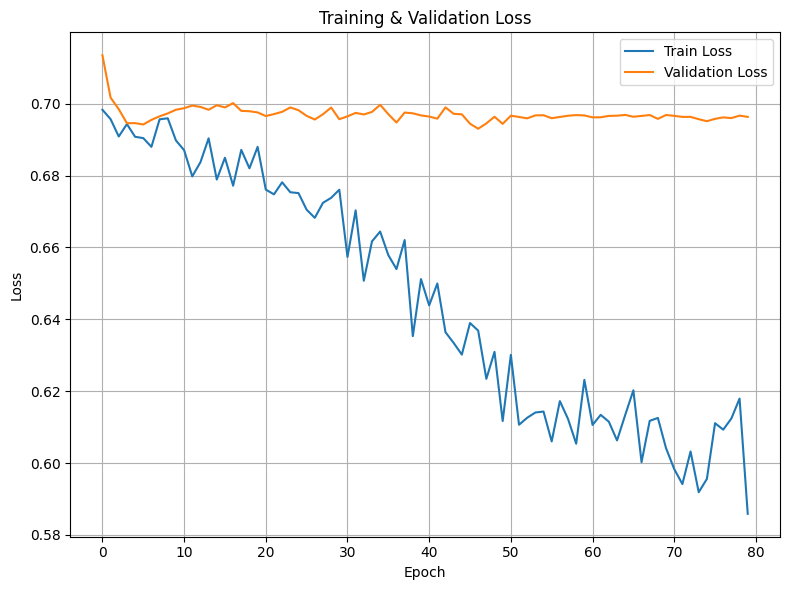


 Final Validation Metrics:
Accuracy : 0.5333
Precision: 0.5200
Recall   : 0.8667
F1 Score : 0.6500
AUC      : 0.5228
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 40.61it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 48.25it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:50,  2.92s/epoch]

Epoch 1/80 | Train Loss: 0.7016 | Val Loss: 0.7070


Training Progress:   2%|▎         | 2/80 [00:06<04:14,  3.27s/epoch]

Epoch 2/80 | Train Loss: 0.6901 | Val Loss: 0.7000


Training Progress:   4%|▍         | 3/80 [00:09<03:55,  3.06s/epoch]

Epoch 3/80 | Train Loss: 0.6945 | Val Loss: 0.6950


Training Progress:   5%|▌         | 4/80 [00:12<03:44,  2.95s/epoch]

Epoch 4/80 | Train Loss: 0.7038 | Val Loss: 0.6901


Training Progress:   6%|▋         | 5/80 [00:14<03:33,  2.85s/epoch]

Epoch 5/80 | Train Loss: 0.6935 | Val Loss: 0.6891


Training Progress:   8%|▊         | 6/80 [00:18<03:46,  3.06s/epoch]

Epoch 6/80 | Train Loss: 0.6932 | Val Loss: 0.6888


Training Progress:   9%|▉         | 7/80 [00:21<03:39,  3.01s/epoch]

Epoch 7/80 | Train Loss: 0.6924 | Val Loss: 0.6900


Training Progress:  10%|█         | 8/80 [00:23<03:29,  2.91s/epoch]

Epoch 8/80 | Train Loss: 0.6972 | Val Loss: 0.6890


Training Progress:  11%|█▏        | 9/80 [00:26<03:21,  2.83s/epoch]

Epoch 9/80 | Train Loss: 0.6853 | Val Loss: 0.6897


Training Progress:  12%|█▎        | 10/80 [00:29<03:19,  2.84s/epoch]

Epoch 10/80 | Train Loss: 0.6879 | Val Loss: 0.6902


Training Progress:  14%|█▍        | 11/80 [00:32<03:29,  3.03s/epoch]

Epoch 11/80 | Train Loss: 0.6906 | Val Loss: 0.6896


Training Progress:  15%|█▌        | 12/80 [00:35<03:18,  2.92s/epoch]

Epoch 12/80 | Train Loss: 0.6947 | Val Loss: 0.6895


Training Progress:  16%|█▋        | 13/80 [00:38<03:10,  2.84s/epoch]

Epoch 13/80 | Train Loss: 0.6926 | Val Loss: 0.6900


Training Progress:  18%|█▊        | 14/80 [00:40<03:05,  2.81s/epoch]

Epoch 14/80 | Train Loss: 0.6882 | Val Loss: 0.6900


Training Progress:  19%|█▉        | 15/80 [00:44<03:13,  2.98s/epoch]

Epoch 15/80 | Train Loss: 0.6839 | Val Loss: 0.6889


Training Progress:  20%|██        | 16/80 [00:47<03:12,  3.00s/epoch]

Epoch 16/80 | Train Loss: 0.6861 | Val Loss: 0.6889


Training Progress:  21%|██▏       | 17/80 [00:49<03:03,  2.91s/epoch]

Epoch 17/80 | Train Loss: 0.6894 | Val Loss: 0.6889


Training Progress:  22%|██▎       | 18/80 [00:52<02:56,  2.85s/epoch]

Epoch 18/80 | Train Loss: 0.6896 | Val Loss: 0.6896


Training Progress:  24%|██▍       | 19/80 [00:55<02:50,  2.80s/epoch]

Epoch 19/80 | Train Loss: 0.6834 | Val Loss: 0.6909


Training Progress:  25%|██▌       | 20/80 [00:58<03:02,  3.04s/epoch]

Epoch 20/80 | Train Loss: 0.6827 | Val Loss: 0.6887


Training Progress:  26%|██▋       | 21/80 [01:01<02:53,  2.94s/epoch]

Epoch 21/80 | Train Loss: 0.6850 | Val Loss: 0.6902


Training Progress:  28%|██▊       | 22/80 [01:04<02:45,  2.86s/epoch]

Epoch 22/80 | Train Loss: 0.6838 | Val Loss: 0.6887


Training Progress:  29%|██▉       | 23/80 [01:06<02:39,  2.80s/epoch]

Epoch 23/80 | Train Loss: 0.6786 | Val Loss: 0.6883


Training Progress:  30%|███       | 24/80 [01:10<02:43,  2.93s/epoch]

Epoch 24/80 | Train Loss: 0.6794 | Val Loss: 0.6883


Training Progress:  31%|███▏      | 25/80 [01:13<02:44,  3.00s/epoch]

Epoch 25/80 | Train Loss: 0.6762 | Val Loss: 0.6884


Training Progress:  32%|███▎      | 26/80 [01:15<02:35,  2.89s/epoch]

Epoch 26/80 | Train Loss: 0.6698 | Val Loss: 0.6887


Training Progress:  34%|███▍      | 27/80 [01:18<02:28,  2.81s/epoch]

Epoch 27/80 | Train Loss: 0.6668 | Val Loss: 0.6883


Training Progress:  35%|███▌      | 28/80 [01:21<02:23,  2.76s/epoch]

Epoch 28/80 | Train Loss: 0.6700 | Val Loss: 0.6888


Training Progress:  36%|███▋      | 29/80 [01:24<02:32,  3.00s/epoch]

Epoch 29/80 | Train Loss: 0.6709 | Val Loss: 0.6883


Training Progress:  38%|███▊      | 30/80 [01:27<02:26,  2.92s/epoch]

Epoch 30/80 | Train Loss: 0.6676 | Val Loss: 0.6904


Training Progress:  39%|███▉      | 31/80 [01:30<02:19,  2.84s/epoch]

Epoch 31/80 | Train Loss: 0.6676 | Val Loss: 0.6916


Training Progress:  40%|████      | 32/80 [01:32<02:13,  2.78s/epoch]

Epoch 32/80 | Train Loss: 0.6600 | Val Loss: 0.6928


Training Progress:  41%|████▏     | 33/80 [01:35<02:12,  2.82s/epoch]

Epoch 33/80 | Train Loss: 0.6613 | Val Loss: 0.6923


Training Progress:  42%|████▎     | 34/80 [01:39<02:17,  2.99s/epoch]

Epoch 34/80 | Train Loss: 0.6513 | Val Loss: 0.6946


Training Progress:  44%|████▍     | 35/80 [01:41<02:09,  2.89s/epoch]

Epoch 35/80 | Train Loss: 0.6536 | Val Loss: 0.6955


Training Progress:  45%|████▌     | 36/80 [01:44<02:03,  2.82s/epoch]

Epoch 36/80 | Train Loss: 0.6669 | Val Loss: 0.6942


Training Progress:  46%|████▋     | 37/80 [01:47<01:59,  2.77s/epoch]

Epoch 37/80 | Train Loss: 0.6533 | Val Loss: 0.6944


Training Progress:  48%|████▊     | 38/80 [01:50<02:04,  2.96s/epoch]

Epoch 38/80 | Train Loss: 0.6517 | Val Loss: 0.6900


Training Progress:  49%|████▉     | 39/80 [01:53<02:01,  2.96s/epoch]

Epoch 39/80 | Train Loss: 0.6468 | Val Loss: 0.6913


Training Progress:  50%|█████     | 40/80 [01:56<01:54,  2.87s/epoch]

Epoch 40/80 | Train Loss: 0.6390 | Val Loss: 0.6910


Training Progress:  51%|█████▏    | 41/80 [01:58<01:49,  2.82s/epoch]

Epoch 41/80 | Train Loss: 0.6392 | Val Loss: 0.6911


Training Progress:  52%|█████▎    | 42/80 [02:01<01:45,  2.77s/epoch]

Epoch 42/80 | Train Loss: 0.6381 | Val Loss: 0.6924


Training Progress:  54%|█████▍    | 43/80 [02:05<01:51,  3.01s/epoch]

Epoch 43/80 | Train Loss: 0.6338 | Val Loss: 0.6918


Training Progress:  55%|█████▌    | 44/80 [02:07<01:45,  2.92s/epoch]

Epoch 44/80 | Train Loss: 0.6169 | Val Loss: 0.6927


Training Progress:  56%|█████▋    | 45/80 [02:10<01:40,  2.86s/epoch]

Epoch 45/80 | Train Loss: 0.6309 | Val Loss: 0.6948


Training Progress:  57%|█████▊    | 46/80 [02:13<01:35,  2.80s/epoch]

Epoch 46/80 | Train Loss: 0.6250 | Val Loss: 0.6957


Training Progress:  59%|█████▉    | 47/80 [02:16<01:36,  2.93s/epoch]

Epoch 47/80 | Train Loss: 0.6227 | Val Loss: 0.6978


Training Progress:  60%|██████    | 48/80 [02:19<01:35,  2.97s/epoch]

Epoch 48/80 | Train Loss: 0.6240 | Val Loss: 0.6950


Training Progress:  61%|██████▏   | 49/80 [02:22<01:29,  2.88s/epoch]

Epoch 49/80 | Train Loss: 0.6082 | Val Loss: 0.6972


Training Progress:  62%|██████▎   | 50/80 [02:24<01:24,  2.81s/epoch]

Epoch 50/80 | Train Loss: 0.6046 | Val Loss: 0.7008


Training Progress:  64%|██████▍   | 51/80 [02:27<01:20,  2.76s/epoch]

Epoch 51/80 | Train Loss: 0.5999 | Val Loss: 0.6986


Training Progress:  65%|██████▌   | 52/80 [02:31<01:24,  3.03s/epoch]

Epoch 52/80 | Train Loss: 0.6035 | Val Loss: 0.6952


Training Progress:  66%|██████▋   | 53/80 [02:33<01:18,  2.91s/epoch]

Epoch 53/80 | Train Loss: 0.5868 | Val Loss: 0.6972


Training Progress:  68%|██████▊   | 54/80 [02:36<01:13,  2.83s/epoch]

Epoch 54/80 | Train Loss: 0.5956 | Val Loss: 0.6954


Training Progress:  69%|██████▉   | 55/80 [02:38<01:09,  2.77s/epoch]

Epoch 55/80 | Train Loss: 0.5967 | Val Loss: 0.6940


Training Progress:  70%|███████   | 56/80 [02:41<01:08,  2.85s/epoch]

Epoch 56/80 | Train Loss: 0.5789 | Val Loss: 0.6949


Training Progress:  71%|███████▏  | 57/80 [02:45<01:08,  2.97s/epoch]

Epoch 57/80 | Train Loss: 0.5882 | Val Loss: 0.6977


Training Progress:  72%|███████▎  | 58/80 [02:47<01:03,  2.88s/epoch]

Epoch 58/80 | Train Loss: 0.5690 | Val Loss: 0.6962


Training Progress:  74%|███████▍  | 59/80 [02:50<00:58,  2.80s/epoch]

Epoch 59/80 | Train Loss: 0.5681 | Val Loss: 0.6949


Training Progress:  75%|███████▌  | 60/80 [02:53<00:55,  2.75s/epoch]

Epoch 60/80 | Train Loss: 0.5701 | Val Loss: 0.6968


Training Progress:  76%|███████▋  | 61/80 [02:56<00:56,  2.95s/epoch]

Epoch 61/80 | Train Loss: 0.5714 | Val Loss: 0.6980


Training Progress:  78%|███████▊  | 62/80 [02:59<00:52,  2.94s/epoch]

Epoch 62/80 | Train Loss: 0.5835 | Val Loss: 0.6974


Training Progress:  79%|███████▉  | 63/80 [03:02<00:48,  2.86s/epoch]

Epoch 63/80 | Train Loss: 0.5969 | Val Loss: 0.6969


Training Progress:  80%|████████  | 64/80 [03:04<00:44,  2.78s/epoch]

Epoch 64/80 | Train Loss: 0.5918 | Val Loss: 0.6951


Training Progress:  81%|████████▏ | 65/80 [03:07<00:41,  2.75s/epoch]

Epoch 65/80 | Train Loss: 0.5874 | Val Loss: 0.6964


Training Progress:  82%|████████▎ | 66/80 [03:11<00:42,  3.03s/epoch]

Epoch 66/80 | Train Loss: 0.5789 | Val Loss: 0.6990


Training Progress:  84%|████████▍ | 67/80 [03:13<00:37,  2.91s/epoch]

Epoch 67/80 | Train Loss: 0.6018 | Val Loss: 0.6978


Training Progress:  85%|████████▌ | 68/80 [03:16<00:34,  2.84s/epoch]

Epoch 68/80 | Train Loss: 0.5838 | Val Loss: 0.6977


Training Progress:  86%|████████▋ | 69/80 [03:19<00:30,  2.78s/epoch]

Epoch 69/80 | Train Loss: 0.5959 | Val Loss: 0.6965


Training Progress:  88%|████████▊ | 70/80 [03:22<00:28,  2.89s/epoch]

Epoch 70/80 | Train Loss: 0.5781 | Val Loss: 0.6983


Training Progress:  89%|████████▉ | 71/80 [03:25<00:26,  2.97s/epoch]

Epoch 71/80 | Train Loss: 0.5790 | Val Loss: 0.6994


Training Progress:  90%|█████████ | 72/80 [03:27<00:22,  2.87s/epoch]

Epoch 72/80 | Train Loss: 0.5904 | Val Loss: 0.7005


Training Progress:  91%|█████████▏| 73/80 [03:30<00:19,  2.81s/epoch]

Epoch 73/80 | Train Loss: 0.5935 | Val Loss: 0.7002


Training Progress:  92%|█████████▎| 74/80 [03:33<00:16,  2.75s/epoch]

Epoch 74/80 | Train Loss: 0.5730 | Val Loss: 0.7014


Training Progress:  94%|█████████▍| 75/80 [03:36<00:15,  3.01s/epoch]

Epoch 75/80 | Train Loss: 0.5932 | Val Loss: 0.7009


Training Progress:  95%|█████████▌| 76/80 [03:39<00:11,  2.93s/epoch]

Epoch 76/80 | Train Loss: 0.5784 | Val Loss: 0.7003


Training Progress:  96%|█████████▋| 77/80 [03:42<00:08,  2.84s/epoch]

Epoch 77/80 | Train Loss: 0.5726 | Val Loss: 0.7022


Training Progress:  98%|█████████▊| 78/80 [03:44<00:05,  2.78s/epoch]

Epoch 78/80 | Train Loss: 0.5511 | Val Loss: 0.7015


Training Progress:  99%|█████████▉| 79/80 [03:47<00:02,  2.82s/epoch]

Epoch 79/80 | Train Loss: 0.5717 | Val Loss: 0.7020


Training Progress: 100%|██████████| 80/80 [03:51<00:00,  2.89s/epoch]

Epoch 80/80 | Train Loss: 0.5803 | Val Loss: 0.7008


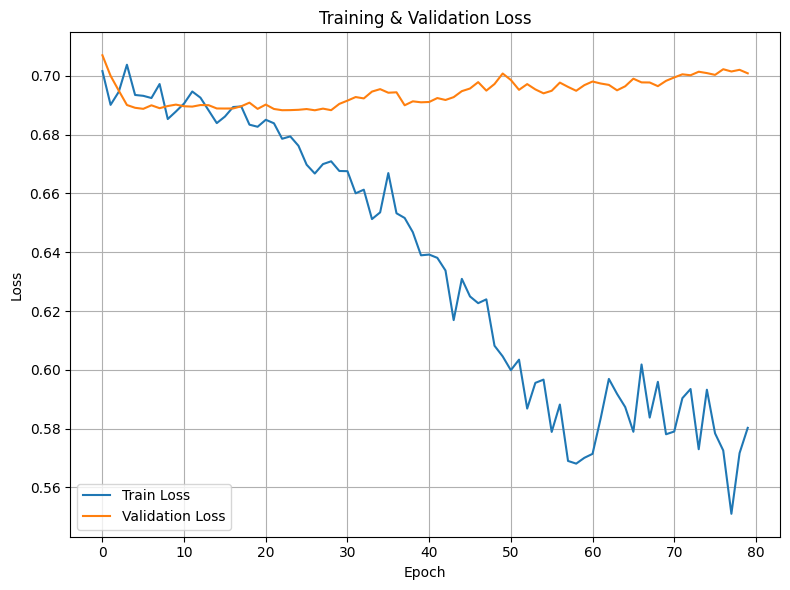


 Final Validation Metrics:
Accuracy : 0.4833
Precision: 0.4861
Recall   : 0.5833
F1 Score : 0.5303
AUC      : 0.5242
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 37.21it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 47.54it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:35,  2.73s/epoch]

Epoch 1/80 | Train Loss: 0.7000 | Val Loss: 0.7015


Training Progress:   2%|▎         | 2/80 [00:05<03:53,  2.99s/epoch]

Epoch 2/80 | Train Loss: 0.6969 | Val Loss: 0.7073


Training Progress:   4%|▍         | 3/80 [00:08<03:53,  3.04s/epoch]

Epoch 3/80 | Train Loss: 0.6907 | Val Loss: 0.7007


Training Progress:   5%|▌         | 4/80 [00:11<03:38,  2.88s/epoch]

Epoch 4/80 | Train Loss: 0.6915 | Val Loss: 0.6949


Training Progress:   6%|▋         | 5/80 [00:14<03:29,  2.79s/epoch]

Epoch 5/80 | Train Loss: 0.6957 | Val Loss: 0.6917


Training Progress:   8%|▊         | 6/80 [00:16<03:22,  2.74s/epoch]

Epoch 6/80 | Train Loss: 0.6884 | Val Loss: 0.6917


Training Progress:   9%|▉         | 7/80 [00:20<03:43,  3.06s/epoch]

Epoch 7/80 | Train Loss: 0.6828 | Val Loss: 0.6917


Training Progress:  10%|█         | 8/80 [00:23<03:31,  2.94s/epoch]

Epoch 8/80 | Train Loss: 0.6828 | Val Loss: 0.6890


Training Progress:  11%|█▏        | 9/80 [00:25<03:22,  2.85s/epoch]

Epoch 9/80 | Train Loss: 0.6847 | Val Loss: 0.6900


Training Progress:  12%|█▎        | 10/80 [00:28<03:15,  2.79s/epoch]

Epoch 10/80 | Train Loss: 0.6786 | Val Loss: 0.6893


Training Progress:  14%|█▍        | 11/80 [00:31<03:17,  2.86s/epoch]

Epoch 11/80 | Train Loss: 0.6880 | Val Loss: 0.6898


Training Progress:  15%|█▌        | 12/80 [00:34<03:24,  3.01s/epoch]

Epoch 12/80 | Train Loss: 0.6757 | Val Loss: 0.6906


Training Progress:  16%|█▋        | 13/80 [00:37<03:15,  2.92s/epoch]

Epoch 13/80 | Train Loss: 0.6729 | Val Loss: 0.6903


Training Progress:  18%|█▊        | 14/80 [00:40<03:08,  2.85s/epoch]

Epoch 14/80 | Train Loss: 0.6782 | Val Loss: 0.6909


Training Progress:  19%|█▉        | 15/80 [00:43<03:01,  2.80s/epoch]

Epoch 15/80 | Train Loss: 0.6677 | Val Loss: 0.6894


Training Progress:  20%|██        | 16/80 [00:46<03:11,  3.00s/epoch]

Epoch 16/80 | Train Loss: 0.6722 | Val Loss: 0.6871


Training Progress:  21%|██▏       | 17/80 [00:49<03:06,  2.95s/epoch]

Epoch 17/80 | Train Loss: 0.6751 | Val Loss: 0.6876


Training Progress:  22%|██▎       | 18/80 [00:51<02:56,  2.85s/epoch]

Epoch 18/80 | Train Loss: 0.6699 | Val Loss: 0.6870


Training Progress:  24%|██▍       | 19/80 [00:54<02:49,  2.79s/epoch]

Epoch 19/80 | Train Loss: 0.6621 | Val Loss: 0.6855


Training Progress:  25%|██▌       | 20/80 [00:57<02:46,  2.78s/epoch]

Epoch 20/80 | Train Loss: 0.6576 | Val Loss: 0.6856


Training Progress:  26%|██▋       | 21/80 [01:00<02:56,  2.99s/epoch]

Epoch 21/80 | Train Loss: 0.6526 | Val Loss: 0.6870


Training Progress:  28%|██▊       | 22/80 [01:03<02:47,  2.89s/epoch]

Epoch 22/80 | Train Loss: 0.6601 | Val Loss: 0.6889


Training Progress:  29%|██▉       | 23/80 [01:06<02:40,  2.81s/epoch]

Epoch 23/80 | Train Loss: 0.6489 | Val Loss: 0.6872


Training Progress:  30%|███       | 24/80 [01:08<02:34,  2.77s/epoch]

Epoch 24/80 | Train Loss: 0.6534 | Val Loss: 0.6796


Training Progress:  31%|███▏      | 25/80 [01:12<02:39,  2.90s/epoch]

Epoch 25/80 | Train Loss: 0.6354 | Val Loss: 0.6804


Training Progress:  32%|███▎      | 26/80 [01:15<02:39,  2.95s/epoch]

Epoch 26/80 | Train Loss: 0.6445 | Val Loss: 0.6785


Training Progress:  34%|███▍      | 27/80 [01:17<02:31,  2.86s/epoch]

Epoch 27/80 | Train Loss: 0.6494 | Val Loss: 0.6766


Training Progress:  35%|███▌      | 28/80 [01:20<02:25,  2.79s/epoch]

Epoch 28/80 | Train Loss: 0.6456 | Val Loss: 0.6772


Training Progress:  36%|███▋      | 29/80 [01:23<02:20,  2.75s/epoch]

Epoch 29/80 | Train Loss: 0.6262 | Val Loss: 0.6742


Training Progress:  38%|███▊      | 30/80 [01:26<02:30,  3.01s/epoch]

Epoch 30/80 | Train Loss: 0.6262 | Val Loss: 0.6746


Training Progress:  39%|███▉      | 31/80 [01:29<02:22,  2.91s/epoch]

Epoch 31/80 | Train Loss: 0.6089 | Val Loss: 0.6839


Training Progress:  40%|████      | 32/80 [01:31<02:16,  2.84s/epoch]

Epoch 32/80 | Train Loss: 0.5870 | Val Loss: 0.6763


Training Progress:  41%|████▏     | 33/80 [01:34<02:10,  2.77s/epoch]

Epoch 33/80 | Train Loss: 0.5952 | Val Loss: 0.6809


Training Progress:  42%|████▎     | 34/80 [01:37<02:11,  2.85s/epoch]

Epoch 34/80 | Train Loss: 0.5899 | Val Loss: 0.6814


Training Progress:  44%|████▍     | 35/80 [01:40<02:14,  2.99s/epoch]

Epoch 35/80 | Train Loss: 0.5880 | Val Loss: 0.6840


Training Progress:  45%|████▌     | 36/80 [01:43<02:07,  2.90s/epoch]

Epoch 36/80 | Train Loss: 0.5817 | Val Loss: 0.6890


Training Progress:  46%|████▋     | 37/80 [01:46<02:01,  2.82s/epoch]

Epoch 37/80 | Train Loss: 0.5871 | Val Loss: 0.6829


Training Progress:  48%|████▊     | 38/80 [01:48<01:56,  2.76s/epoch]

Epoch 38/80 | Train Loss: 0.5732 | Val Loss: 0.6803


Training Progress:  49%|████▉     | 39/80 [01:52<02:02,  2.98s/epoch]

Epoch 39/80 | Train Loss: 0.5663 | Val Loss: 0.6869


Training Progress:  50%|█████     | 40/80 [01:55<01:57,  2.93s/epoch]

Epoch 40/80 | Train Loss: 0.5425 | Val Loss: 0.6926


Training Progress:  51%|█████▏    | 41/80 [01:57<01:50,  2.84s/epoch]

Epoch 41/80 | Train Loss: 0.5362 | Val Loss: 0.6837


Training Progress:  52%|█████▎    | 42/80 [02:00<01:45,  2.79s/epoch]

Epoch 42/80 | Train Loss: 0.5470 | Val Loss: 0.6816


Training Progress:  54%|█████▍    | 43/80 [02:03<01:43,  2.80s/epoch]

Epoch 43/80 | Train Loss: 0.5422 | Val Loss: 0.6806


Training Progress:  55%|█████▌    | 44/80 [02:06<01:47,  2.99s/epoch]

Epoch 44/80 | Train Loss: 0.5324 | Val Loss: 0.6660


Training Progress:  56%|█████▋    | 45/80 [02:09<01:41,  2.89s/epoch]

Epoch 45/80 | Train Loss: 0.5021 | Val Loss: 0.6643


Training Progress:  57%|█████▊    | 46/80 [02:12<01:35,  2.82s/epoch]

Epoch 46/80 | Train Loss: 0.5071 | Val Loss: 0.6645


Training Progress:  59%|█████▉    | 47/80 [02:14<01:31,  2.76s/epoch]

Epoch 47/80 | Train Loss: 0.5171 | Val Loss: 0.6621


Training Progress:  60%|██████    | 48/80 [02:17<01:33,  2.92s/epoch]

Epoch 48/80 | Train Loss: 0.4923 | Val Loss: 0.6540


Training Progress:  61%|██████▏   | 49/80 [02:21<01:32,  2.97s/epoch]

Epoch 49/80 | Train Loss: 0.4785 | Val Loss: 0.6548


Training Progress:  62%|██████▎   | 50/80 [02:23<01:25,  2.87s/epoch]

Epoch 50/80 | Train Loss: 0.4680 | Val Loss: 0.6423


Training Progress:  64%|██████▍   | 51/80 [02:26<01:21,  2.79s/epoch]

Epoch 51/80 | Train Loss: 0.4459 | Val Loss: 0.6425


Training Progress:  65%|██████▌   | 52/80 [02:28<01:16,  2.75s/epoch]

Epoch 52/80 | Train Loss: 0.4601 | Val Loss: 0.6448


Training Progress:  66%|██████▋   | 53/80 [02:32<01:21,  3.01s/epoch]

Epoch 53/80 | Train Loss: 0.4416 | Val Loss: 0.6464


Training Progress:  68%|██████▊   | 54/80 [02:35<01:15,  2.89s/epoch]

Epoch 54/80 | Train Loss: 0.4449 | Val Loss: 0.6472


Training Progress:  69%|██████▉   | 55/80 [02:37<01:10,  2.81s/epoch]

Epoch 55/80 | Train Loss: 0.4814 | Val Loss: 0.6481


Training Progress:  70%|███████   | 56/80 [02:40<01:06,  2.76s/epoch]

Epoch 56/80 | Train Loss: 0.4656 | Val Loss: 0.6478


Training Progress:  71%|███████▏  | 57/80 [02:43<01:04,  2.82s/epoch]

Epoch 57/80 | Train Loss: 0.4640 | Val Loss: 0.6481


Training Progress:  72%|███████▎  | 58/80 [02:46<01:05,  2.96s/epoch]

Epoch 58/80 | Train Loss: 0.4571 | Val Loss: 0.6473


Training Progress:  74%|███████▍  | 59/80 [02:49<01:00,  2.87s/epoch]

Epoch 59/80 | Train Loss: 0.4832 | Val Loss: 0.6473


Training Progress:  75%|███████▌  | 60/80 [02:51<00:55,  2.80s/epoch]

Epoch 60/80 | Train Loss: 0.4462 | Val Loss: 0.6464


Training Progress:  76%|███████▋  | 61/80 [02:54<00:52,  2.74s/epoch]

Epoch 61/80 | Train Loss: 0.4586 | Val Loss: 0.6473


Training Progress:  78%|███████▊  | 62/80 [02:57<00:52,  2.94s/epoch]

Epoch 62/80 | Train Loss: 0.4556 | Val Loss: 0.6478


Training Progress:  79%|███████▉  | 63/80 [03:00<00:50,  2.94s/epoch]

Epoch 63/80 | Train Loss: 0.4716 | Val Loss: 0.6460


Training Progress:  80%|████████  | 64/80 [03:03<00:45,  2.86s/epoch]

Epoch 64/80 | Train Loss: 0.4570 | Val Loss: 0.6460


Training Progress:  81%|████████▏ | 65/80 [03:06<00:41,  2.80s/epoch]

Epoch 65/80 | Train Loss: 0.4437 | Val Loss: 0.6461


Training Progress:  82%|████████▎ | 66/80 [03:08<00:38,  2.77s/epoch]

Epoch 66/80 | Train Loss: 0.4195 | Val Loss: 0.6446


Training Progress:  84%|████████▍ | 67/80 [03:12<00:38,  3.00s/epoch]

Epoch 67/80 | Train Loss: 0.4626 | Val Loss: 0.6445


Training Progress:  85%|████████▌ | 68/80 [03:15<00:34,  2.90s/epoch]

Epoch 68/80 | Train Loss: 0.4193 | Val Loss: 0.6444


Training Progress:  86%|████████▋ | 69/80 [03:17<00:30,  2.82s/epoch]

Epoch 69/80 | Train Loss: 0.4376 | Val Loss: 0.6451


Training Progress:  88%|████████▊ | 70/80 [03:20<00:27,  2.76s/epoch]

Epoch 70/80 | Train Loss: 0.4375 | Val Loss: 0.6435


Training Progress:  89%|████████▉ | 71/80 [03:23<00:26,  2.89s/epoch]

Epoch 71/80 | Train Loss: 0.4228 | Val Loss: 0.6438


Training Progress:  90%|█████████ | 72/80 [03:26<00:23,  2.96s/epoch]

Epoch 72/80 | Train Loss: 0.4383 | Val Loss: 0.6452


Training Progress:  91%|█████████▏| 73/80 [03:29<00:20,  2.87s/epoch]

Epoch 73/80 | Train Loss: 0.4469 | Val Loss: 0.6450


Training Progress:  92%|█████████▎| 74/80 [03:32<00:16,  2.81s/epoch]

Epoch 74/80 | Train Loss: 0.4677 | Val Loss: 0.6434


Training Progress:  94%|█████████▍| 75/80 [03:34<00:13,  2.76s/epoch]

Epoch 75/80 | Train Loss: 0.4197 | Val Loss: 0.6444


Training Progress:  95%|█████████▌| 76/80 [03:38<00:12,  3.01s/epoch]

Epoch 76/80 | Train Loss: 0.4629 | Val Loss: 0.6445


Training Progress:  96%|█████████▋| 77/80 [03:40<00:08,  2.91s/epoch]

Epoch 77/80 | Train Loss: 0.4272 | Val Loss: 0.6434


Training Progress:  98%|█████████▊| 78/80 [03:43<00:05,  2.83s/epoch]

Epoch 78/80 | Train Loss: 0.4263 | Val Loss: 0.6499


Training Progress:  99%|█████████▉| 79/80 [03:46<00:02,  2.77s/epoch]

Epoch 79/80 | Train Loss: 0.4517 | Val Loss: 0.6496


Training Progress: 100%|██████████| 80/80 [03:49<00:00,  2.87s/epoch]


Epoch 80/80 | Train Loss: 0.4039 | Val Loss: 0.6467


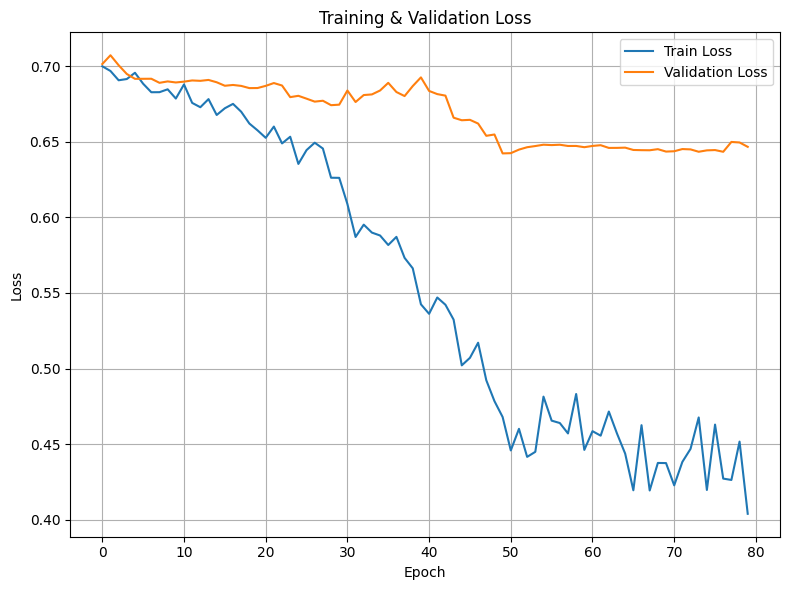


 Final Validation Metrics:
Accuracy : 0.6083
Precision: 0.6102
Recall   : 0.6000
F1 Score : 0.6050
AUC      : 0.6803
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 48.15it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:03<00:00, 39.14it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:30,  2.66s/epoch]

Epoch 1/80 | Train Loss: 0.6945 | Val Loss: 0.6935


Training Progress:   2%|▎         | 2/80 [00:05<03:26,  2.64s/epoch]

Epoch 2/80 | Train Loss: 0.6931 | Val Loss: 0.6930


Training Progress:   4%|▍         | 3/80 [00:07<03:23,  2.64s/epoch]

Epoch 3/80 | Train Loss: 0.6844 | Val Loss: 0.6908


Training Progress:   5%|▌         | 4/80 [00:11<03:48,  3.01s/epoch]

Epoch 4/80 | Train Loss: 0.6910 | Val Loss: 0.6916


Training Progress:   6%|▋         | 5/80 [00:14<03:38,  2.92s/epoch]

Epoch 5/80 | Train Loss: 0.6946 | Val Loss: 0.6931


Training Progress:   8%|▊         | 6/80 [00:16<03:29,  2.83s/epoch]

Epoch 6/80 | Train Loss: 0.6924 | Val Loss: 0.6950


Training Progress:   9%|▉         | 7/80 [00:19<03:21,  2.76s/epoch]

Epoch 7/80 | Train Loss: 0.6906 | Val Loss: 0.6975


Training Progress:  10%|█         | 8/80 [00:22<03:22,  2.81s/epoch]

Epoch 8/80 | Train Loss: 0.6871 | Val Loss: 0.6953


Training Progress:  11%|█▏        | 9/80 [00:25<03:31,  2.98s/epoch]

Epoch 9/80 | Train Loss: 0.6821 | Val Loss: 0.6939


Training Progress:  12%|█▎        | 10/80 [00:28<03:21,  2.87s/epoch]

Epoch 10/80 | Train Loss: 0.6898 | Val Loss: 0.6928


Training Progress:  14%|█▍        | 11/80 [00:31<03:12,  2.80s/epoch]

Epoch 11/80 | Train Loss: 0.6886 | Val Loss: 0.6924


Training Progress:  15%|█▌        | 12/80 [00:33<03:07,  2.75s/epoch]

Epoch 12/80 | Train Loss: 0.6843 | Val Loss: 0.6908


Training Progress:  16%|█▋        | 13/80 [00:37<03:17,  2.95s/epoch]

Epoch 13/80 | Train Loss: 0.6834 | Val Loss: 0.6909


Training Progress:  18%|█▊        | 14/80 [00:40<03:13,  2.94s/epoch]

Epoch 14/80 | Train Loss: 0.6825 | Val Loss: 0.6909


Training Progress:  19%|█▉        | 15/80 [00:42<03:05,  2.85s/epoch]

Epoch 15/80 | Train Loss: 0.6788 | Val Loss: 0.6917


Training Progress:  20%|██        | 16/80 [00:45<02:58,  2.78s/epoch]

Epoch 16/80 | Train Loss: 0.6744 | Val Loss: 0.6904


Training Progress:  21%|██▏       | 17/80 [00:47<02:52,  2.74s/epoch]

Epoch 17/80 | Train Loss: 0.6800 | Val Loss: 0.6879


Training Progress:  22%|██▎       | 18/80 [00:51<03:05,  2.99s/epoch]

Epoch 18/80 | Train Loss: 0.6728 | Val Loss: 0.6876


Training Progress:  24%|██▍       | 19/80 [00:54<02:57,  2.90s/epoch]

Epoch 19/80 | Train Loss: 0.6689 | Val Loss: 0.6888


Training Progress:  25%|██▌       | 20/80 [00:56<02:50,  2.83s/epoch]

Epoch 20/80 | Train Loss: 0.6647 | Val Loss: 0.6865


Training Progress:  26%|██▋       | 21/80 [00:59<02:43,  2.77s/epoch]

Epoch 21/80 | Train Loss: 0.6665 | Val Loss: 0.6862


Training Progress:  28%|██▊       | 22/80 [01:02<02:46,  2.88s/epoch]

Epoch 22/80 | Train Loss: 0.6535 | Val Loss: 0.6859


Training Progress:  29%|██▉       | 23/80 [01:05<02:49,  2.98s/epoch]

Epoch 23/80 | Train Loss: 0.6630 | Val Loss: 0.6832


Training Progress:  30%|███       | 24/80 [01:08<02:40,  2.87s/epoch]

Epoch 24/80 | Train Loss: 0.6609 | Val Loss: 0.6812


Training Progress:  31%|███▏      | 25/80 [01:11<02:33,  2.79s/epoch]

Epoch 25/80 | Train Loss: 0.6542 | Val Loss: 0.6819


Training Progress:  32%|███▎      | 26/80 [01:13<02:28,  2.74s/epoch]

Epoch 26/80 | Train Loss: 0.6519 | Val Loss: 0.6817


Training Progress:  34%|███▍      | 27/80 [01:17<02:38,  2.99s/epoch]

Epoch 27/80 | Train Loss: 0.6502 | Val Loss: 0.6849


Training Progress:  35%|███▌      | 28/80 [01:20<02:32,  2.94s/epoch]

Epoch 28/80 | Train Loss: 0.6505 | Val Loss: 0.6816


Training Progress:  36%|███▋      | 29/80 [01:22<02:25,  2.86s/epoch]

Epoch 29/80 | Train Loss: 0.6414 | Val Loss: 0.6840


Training Progress:  38%|███▊      | 30/80 [01:25<02:20,  2.80s/epoch]

Epoch 30/80 | Train Loss: 0.6518 | Val Loss: 0.6870


Training Progress:  39%|███▉      | 31/80 [01:28<02:18,  2.83s/epoch]

Epoch 31/80 | Train Loss: 0.6280 | Val Loss: 0.6814


Training Progress:  40%|████      | 32/80 [01:31<02:22,  2.98s/epoch]

Epoch 32/80 | Train Loss: 0.6171 | Val Loss: 0.6826


Training Progress:  41%|████▏     | 33/80 [01:34<02:14,  2.87s/epoch]

Epoch 33/80 | Train Loss: 0.6239 | Val Loss: 0.6803


Training Progress:  42%|████▎     | 34/80 [01:36<02:09,  2.81s/epoch]

Epoch 34/80 | Train Loss: 0.6281 | Val Loss: 0.6803


Training Progress:  44%|████▍     | 35/80 [01:39<02:04,  2.76s/epoch]

Epoch 35/80 | Train Loss: 0.6265 | Val Loss: 0.6814


Training Progress:  45%|████▌     | 36/80 [01:42<02:08,  2.93s/epoch]

Epoch 36/80 | Train Loss: 0.5984 | Val Loss: 0.6790


Training Progress:  46%|████▋     | 37/80 [01:45<02:07,  2.95s/epoch]

Epoch 37/80 | Train Loss: 0.6131 | Val Loss: 0.6809


Training Progress:  48%|████▊     | 38/80 [01:48<02:00,  2.87s/epoch]

Epoch 38/80 | Train Loss: 0.6070 | Val Loss: 0.6798


Training Progress:  49%|████▉     | 39/80 [01:51<01:54,  2.80s/epoch]

Epoch 39/80 | Train Loss: 0.5846 | Val Loss: 0.6759


Training Progress:  50%|█████     | 40/80 [01:53<01:50,  2.75s/epoch]

Epoch 40/80 | Train Loss: 0.5755 | Val Loss: 0.6747


Training Progress:  51%|█████▏    | 41/80 [01:57<01:57,  3.01s/epoch]

Epoch 41/80 | Train Loss: 0.5601 | Val Loss: 0.6695


Training Progress:  52%|█████▎    | 42/80 [02:00<01:50,  2.90s/epoch]

Epoch 42/80 | Train Loss: 0.5758 | Val Loss: 0.6717


Training Progress:  54%|█████▍    | 43/80 [02:02<01:44,  2.82s/epoch]

Epoch 43/80 | Train Loss: 0.5572 | Val Loss: 0.6692


Training Progress:  55%|█████▌    | 44/80 [02:05<01:39,  2.77s/epoch]

Epoch 44/80 | Train Loss: 0.5588 | Val Loss: 0.6686


Training Progress:  56%|█████▋    | 45/80 [02:08<01:39,  2.85s/epoch]

Epoch 45/80 | Train Loss: 0.5508 | Val Loss: 0.6669


Training Progress:  57%|█████▊    | 46/80 [02:11<01:40,  2.97s/epoch]

Epoch 46/80 | Train Loss: 0.5595 | Val Loss: 0.6679


Training Progress:  59%|█████▉    | 47/80 [02:14<01:34,  2.87s/epoch]

Epoch 47/80 | Train Loss: 0.5357 | Val Loss: 0.6698


Training Progress:  60%|██████    | 48/80 [02:16<01:29,  2.80s/epoch]

Epoch 48/80 | Train Loss: 0.5231 | Val Loss: 0.6746


Training Progress:  61%|██████▏   | 49/80 [02:19<01:25,  2.75s/epoch]

Epoch 49/80 | Train Loss: 0.5145 | Val Loss: 0.6714


Training Progress:  62%|██████▎   | 50/80 [02:23<01:29,  2.97s/epoch]

Epoch 50/80 | Train Loss: 0.4901 | Val Loss: 0.6718


Training Progress:  64%|██████▍   | 51/80 [02:25<01:25,  2.94s/epoch]

Epoch 51/80 | Train Loss: 0.4848 | Val Loss: 0.6742


Training Progress:  65%|██████▌   | 52/80 [02:28<01:19,  2.85s/epoch]

Epoch 52/80 | Train Loss: 0.4745 | Val Loss: 0.6756


Training Progress:  66%|██████▋   | 53/80 [02:31<01:15,  2.79s/epoch]

Epoch 53/80 | Train Loss: 0.4759 | Val Loss: 0.6741


Training Progress:  68%|██████▊   | 54/80 [02:34<01:12,  2.79s/epoch]

Epoch 54/80 | Train Loss: 0.4755 | Val Loss: 0.6728


Training Progress:  69%|██████▉   | 55/80 [02:37<01:14,  2.98s/epoch]

Epoch 55/80 | Train Loss: 0.4870 | Val Loss: 0.6738


Training Progress:  70%|███████   | 56/80 [02:40<01:08,  2.87s/epoch]

Epoch 56/80 | Train Loss: 0.5106 | Val Loss: 0.6748


Training Progress:  71%|███████▏  | 57/80 [02:42<01:04,  2.80s/epoch]

Epoch 57/80 | Train Loss: 0.5149 | Val Loss: 0.6747


Training Progress:  72%|███████▎  | 58/80 [02:45<01:00,  2.74s/epoch]

Epoch 58/80 | Train Loss: 0.4785 | Val Loss: 0.6735


Training Progress:  74%|███████▍  | 59/80 [02:48<01:00,  2.88s/epoch]

Epoch 59/80 | Train Loss: 0.5014 | Val Loss: 0.6710


Training Progress:  75%|███████▌  | 60/80 [02:51<00:58,  2.94s/epoch]

Epoch 60/80 | Train Loss: 0.4877 | Val Loss: 0.6704


Training Progress:  76%|███████▋  | 61/80 [02:54<00:54,  2.85s/epoch]

Epoch 61/80 | Train Loss: 0.5009 | Val Loss: 0.6721


Training Progress:  78%|███████▊  | 62/80 [02:56<00:50,  2.79s/epoch]

Epoch 62/80 | Train Loss: 0.4624 | Val Loss: 0.6723


Training Progress:  79%|███████▉  | 63/80 [02:59<00:46,  2.76s/epoch]

Epoch 63/80 | Train Loss: 0.4869 | Val Loss: 0.6710


Training Progress:  80%|████████  | 64/80 [03:03<00:48,  3.01s/epoch]

Epoch 64/80 | Train Loss: 0.5000 | Val Loss: 0.6718


Training Progress:  81%|████████▏ | 65/80 [03:05<00:43,  2.91s/epoch]

Epoch 65/80 | Train Loss: 0.5026 | Val Loss: 0.6717


Training Progress:  82%|████████▎ | 66/80 [03:08<00:39,  2.82s/epoch]

Epoch 66/80 | Train Loss: 0.4892 | Val Loss: 0.6717


Training Progress:  84%|████████▍ | 67/80 [03:11<00:36,  2.77s/epoch]

Epoch 67/80 | Train Loss: 0.4816 | Val Loss: 0.6709


Training Progress:  85%|████████▌ | 68/80 [03:14<00:33,  2.82s/epoch]

Epoch 68/80 | Train Loss: 0.4607 | Val Loss: 0.6714


Training Progress:  86%|████████▋ | 69/80 [03:17<00:32,  2.97s/epoch]

Epoch 69/80 | Train Loss: 0.4840 | Val Loss: 0.6730


Training Progress:  88%|████████▊ | 70/80 [03:20<00:28,  2.87s/epoch]

Epoch 70/80 | Train Loss: 0.4694 | Val Loss: 0.6718


Training Progress:  89%|████████▉ | 71/80 [03:22<00:25,  2.80s/epoch]

Epoch 71/80 | Train Loss: 0.4770 | Val Loss: 0.6709


Training Progress:  90%|█████████ | 72/80 [03:25<00:21,  2.75s/epoch]

Epoch 72/80 | Train Loss: 0.4677 | Val Loss: 0.6712


Training Progress:  91%|█████████▏| 73/80 [03:28<00:20,  2.94s/epoch]

Epoch 73/80 | Train Loss: 0.4776 | Val Loss: 0.6696


Training Progress:  92%|█████████▎| 74/80 [03:31<00:17,  2.94s/epoch]

Epoch 74/80 | Train Loss: 0.4874 | Val Loss: 0.6704


Training Progress:  94%|█████████▍| 75/80 [03:34<00:14,  2.85s/epoch]

Epoch 75/80 | Train Loss: 0.4648 | Val Loss: 0.6713


Training Progress:  95%|█████████▌| 76/80 [03:36<00:11,  2.79s/epoch]

Epoch 76/80 | Train Loss: 0.4669 | Val Loss: 0.6717


Training Progress:  96%|█████████▋| 77/80 [03:39<00:08,  2.74s/epoch]

Epoch 77/80 | Train Loss: 0.4670 | Val Loss: 0.6716


Training Progress:  98%|█████████▊| 78/80 [03:43<00:05,  3.00s/epoch]

Epoch 78/80 | Train Loss: 0.4676 | Val Loss: 0.6727


Training Progress:  99%|█████████▉| 79/80 [03:45<00:02,  2.91s/epoch]

Epoch 79/80 | Train Loss: 0.4676 | Val Loss: 0.6717


Training Progress: 100%|██████████| 80/80 [03:48<00:00,  2.86s/epoch]

Epoch 80/80 | Train Loss: 0.4761 | Val Loss: 0.6709


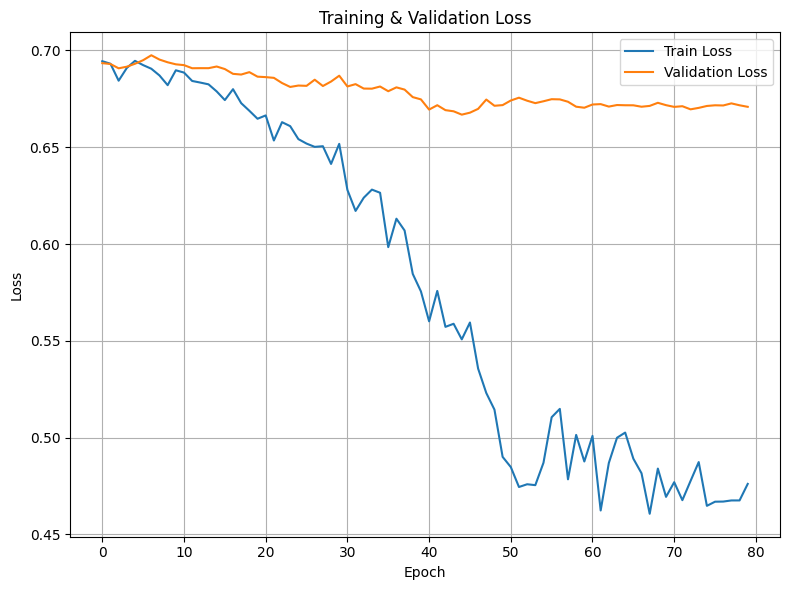


 Final Validation Metrics:
Accuracy : 0.5917
Precision: 0.6038
Recall   : 0.5333
F1 Score : 0.5664
AUC      : 0.6358
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 48.48it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 47.86it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:03<04:42,  3.57s/epoch]

Epoch 1/80 | Train Loss: 0.7005 | Val Loss: 0.7030


Training Progress:   2%|▎         | 2/80 [00:06<03:56,  3.04s/epoch]

Epoch 2/80 | Train Loss: 0.6958 | Val Loss: 0.6958


Training Progress:   4%|▍         | 3/80 [00:08<03:39,  2.85s/epoch]

Epoch 3/80 | Train Loss: 0.6921 | Val Loss: 0.6943


Training Progress:   5%|▌         | 4/80 [00:11<03:31,  2.78s/epoch]

Epoch 4/80 | Train Loss: 0.6926 | Val Loss: 0.6938


Training Progress:   6%|▋         | 5/80 [00:14<03:40,  2.95s/epoch]

Epoch 5/80 | Train Loss: 0.6860 | Val Loss: 0.6969


Training Progress:   8%|▊         | 6/80 [00:17<03:41,  2.99s/epoch]

Epoch 6/80 | Train Loss: 0.6895 | Val Loss: 0.6963


Training Progress:   9%|▉         | 7/80 [00:20<03:30,  2.88s/epoch]

Epoch 7/80 | Train Loss: 0.6840 | Val Loss: 0.6970


Training Progress:  10%|█         | 8/80 [00:23<03:22,  2.81s/epoch]

Epoch 8/80 | Train Loss: 0.6851 | Val Loss: 0.6976


Training Progress:  11%|█▏        | 9/80 [00:25<03:16,  2.76s/epoch]

Epoch 9/80 | Train Loss: 0.6888 | Val Loss: 0.6956


Training Progress:  12%|█▎        | 10/80 [00:29<03:31,  3.02s/epoch]

Epoch 10/80 | Train Loss: 0.6813 | Val Loss: 0.6934


Training Progress:  14%|█▍        | 11/80 [00:32<03:21,  2.93s/epoch]

Epoch 11/80 | Train Loss: 0.6766 | Val Loss: 0.6908


Training Progress:  15%|█▌        | 12/80 [00:34<03:12,  2.84s/epoch]

Epoch 12/80 | Train Loss: 0.6798 | Val Loss: 0.6865


Training Progress:  16%|█▋        | 13/80 [00:37<03:06,  2.79s/epoch]

Epoch 13/80 | Train Loss: 0.6735 | Val Loss: 0.6855


Training Progress:  18%|█▊        | 14/80 [00:40<03:08,  2.85s/epoch]

Epoch 14/80 | Train Loss: 0.6742 | Val Loss: 0.6829


Training Progress:  19%|█▉        | 15/80 [00:43<03:13,  2.98s/epoch]

Epoch 15/80 | Train Loss: 0.6715 | Val Loss: 0.6791


Training Progress:  20%|██        | 16/80 [00:46<03:04,  2.88s/epoch]

Epoch 16/80 | Train Loss: 0.6865 | Val Loss: 0.6758


Training Progress:  21%|██▏       | 17/80 [00:49<02:57,  2.81s/epoch]

Epoch 17/80 | Train Loss: 0.6611 | Val Loss: 0.6768


Training Progress:  22%|██▎       | 18/80 [00:51<02:51,  2.76s/epoch]

Epoch 18/80 | Train Loss: 0.6655 | Val Loss: 0.6772


Training Progress:  24%|██▍       | 19/80 [00:55<03:00,  2.96s/epoch]

Epoch 19/80 | Train Loss: 0.6612 | Val Loss: 0.6712


Training Progress:  25%|██▌       | 20/80 [00:58<02:56,  2.95s/epoch]

Epoch 20/80 | Train Loss: 0.6550 | Val Loss: 0.6684


Training Progress:  26%|██▋       | 21/80 [01:00<02:48,  2.86s/epoch]

Epoch 21/80 | Train Loss: 0.6596 | Val Loss: 0.6643


Training Progress:  28%|██▊       | 22/80 [01:03<02:41,  2.79s/epoch]

Epoch 22/80 | Train Loss: 0.6490 | Val Loss: 0.6642


Training Progress:  29%|██▉       | 23/80 [01:05<02:36,  2.75s/epoch]

Epoch 23/80 | Train Loss: 0.6426 | Val Loss: 0.6594


Training Progress:  30%|███       | 24/80 [01:09<02:48,  3.02s/epoch]

Epoch 24/80 | Train Loss: 0.6393 | Val Loss: 0.6582


Training Progress:  31%|███▏      | 25/80 [01:12<02:39,  2.91s/epoch]

Epoch 25/80 | Train Loss: 0.6369 | Val Loss: 0.6543


Training Progress:  32%|███▎      | 26/80 [01:14<02:33,  2.83s/epoch]

Epoch 26/80 | Train Loss: 0.6434 | Val Loss: 0.6481


Training Progress:  34%|███▍      | 27/80 [01:17<02:27,  2.78s/epoch]

Epoch 27/80 | Train Loss: 0.6337 | Val Loss: 0.6434


Training Progress:  35%|███▌      | 28/80 [01:20<02:30,  2.90s/epoch]

Epoch 28/80 | Train Loss: 0.6245 | Val Loss: 0.6417


Training Progress:  36%|███▋      | 29/80 [01:23<02:32,  2.98s/epoch]

Epoch 29/80 | Train Loss: 0.6137 | Val Loss: 0.6377


Training Progress:  38%|███▊      | 30/80 [01:26<02:24,  2.89s/epoch]

Epoch 30/80 | Train Loss: 0.6054 | Val Loss: 0.6338


Training Progress:  39%|███▉      | 31/80 [01:29<02:17,  2.81s/epoch]

Epoch 31/80 | Train Loss: 0.5940 | Val Loss: 0.6287


Training Progress:  40%|████      | 32/80 [01:31<02:12,  2.76s/epoch]

Epoch 32/80 | Train Loss: 0.5971 | Val Loss: 0.6255


Training Progress:  41%|████▏     | 33/80 [01:35<02:21,  3.01s/epoch]

Epoch 33/80 | Train Loss: 0.5866 | Val Loss: 0.6235


Training Progress:  42%|████▎     | 34/80 [01:38<02:16,  2.96s/epoch]

Epoch 34/80 | Train Loss: 0.5789 | Val Loss: 0.6189


Training Progress:  44%|████▍     | 35/80 [01:40<02:09,  2.87s/epoch]

Epoch 35/80 | Train Loss: 0.5584 | Val Loss: 0.6109


Training Progress:  45%|████▌     | 36/80 [01:43<02:03,  2.80s/epoch]

Epoch 36/80 | Train Loss: 0.5561 | Val Loss: 0.6035


Training Progress:  46%|████▋     | 37/80 [01:46<02:01,  2.83s/epoch]

Epoch 37/80 | Train Loss: 0.5308 | Val Loss: 0.6163


Training Progress:  48%|████▊     | 38/80 [01:49<02:06,  3.02s/epoch]

Epoch 38/80 | Train Loss: 0.5567 | Val Loss: 0.5945


Training Progress:  49%|████▉     | 39/80 [01:52<01:59,  2.92s/epoch]

Epoch 39/80 | Train Loss: 0.5341 | Val Loss: 0.5937


Training Progress:  50%|█████     | 40/80 [01:55<01:53,  2.84s/epoch]

Epoch 40/80 | Train Loss: 0.5188 | Val Loss: 0.6726


Training Progress:  51%|█████▏    | 41/80 [01:57<01:48,  2.79s/epoch]

Epoch 41/80 | Train Loss: 0.4942 | Val Loss: 0.5815


Training Progress:  52%|█████▎    | 42/80 [02:01<01:53,  2.99s/epoch]

Epoch 42/80 | Train Loss: 0.4758 | Val Loss: 0.5690


Training Progress:  54%|█████▍    | 43/80 [02:04<01:49,  2.97s/epoch]

Epoch 43/80 | Train Loss: 0.5164 | Val Loss: 0.5623


Training Progress:  55%|█████▌    | 44/80 [02:07<01:44,  2.89s/epoch]

Epoch 44/80 | Train Loss: 0.4761 | Val Loss: 0.5535


Training Progress:  56%|█████▋    | 45/80 [02:09<01:38,  2.82s/epoch]

Epoch 45/80 | Train Loss: 0.4734 | Val Loss: 0.5607


Training Progress:  57%|█████▊    | 46/80 [02:12<01:34,  2.79s/epoch]

Epoch 46/80 | Train Loss: 0.4560 | Val Loss: 0.5532


Training Progress:  59%|█████▉    | 47/80 [02:15<01:39,  3.00s/epoch]

Epoch 47/80 | Train Loss: 0.4607 | Val Loss: 0.5387


Training Progress:  60%|██████    | 48/80 [02:18<01:32,  2.90s/epoch]

Epoch 48/80 | Train Loss: 0.3779 | Val Loss: 0.5232


Training Progress:  61%|██████▏   | 49/80 [02:21<01:27,  2.83s/epoch]

Epoch 49/80 | Train Loss: 0.4024 | Val Loss: 0.5072


Training Progress:  62%|██████▎   | 50/80 [02:23<01:23,  2.77s/epoch]

Epoch 50/80 | Train Loss: 0.4156 | Val Loss: 0.5363


Training Progress:  64%|██████▍   | 51/80 [02:27<01:23,  2.89s/epoch]

Epoch 51/80 | Train Loss: 0.4497 | Val Loss: 0.5215


Training Progress:  65%|██████▌   | 52/80 [02:30<01:23,  2.97s/epoch]

Epoch 52/80 | Train Loss: 0.4163 | Val Loss: 0.5059


Training Progress:  66%|██████▋   | 53/80 [02:32<01:17,  2.87s/epoch]

Epoch 53/80 | Train Loss: 0.4234 | Val Loss: 0.5005


Training Progress:  68%|██████▊   | 54/80 [02:35<01:12,  2.81s/epoch]

Epoch 54/80 | Train Loss: 0.4203 | Val Loss: 0.4985


Training Progress:  69%|██████▉   | 55/80 [02:38<01:09,  2.77s/epoch]

Epoch 55/80 | Train Loss: 0.4073 | Val Loss: 0.4937


Training Progress:  70%|███████   | 56/80 [02:41<01:12,  3.02s/epoch]

Epoch 56/80 | Train Loss: 0.3969 | Val Loss: 0.4927


Training Progress:  71%|███████▏  | 57/80 [02:44<01:07,  2.94s/epoch]

Epoch 57/80 | Train Loss: 0.4305 | Val Loss: 0.4898


Training Progress:  72%|███████▎  | 58/80 [02:47<01:02,  2.85s/epoch]

Epoch 58/80 | Train Loss: 0.3852 | Val Loss: 0.4890


Training Progress:  74%|███████▍  | 59/80 [02:49<00:58,  2.81s/epoch]

Epoch 59/80 | Train Loss: 0.4429 | Val Loss: 0.4905


Training Progress:  75%|███████▌  | 60/80 [02:52<00:57,  2.89s/epoch]

Epoch 60/80 | Train Loss: 0.3880 | Val Loss: 0.4939


Training Progress:  76%|███████▋  | 61/80 [02:56<00:57,  3.02s/epoch]

Epoch 61/80 | Train Loss: 0.3680 | Val Loss: 0.4896


Training Progress:  78%|███████▊  | 62/80 [02:58<00:52,  2.91s/epoch]

Epoch 62/80 | Train Loss: 0.4036 | Val Loss: 0.4888


Training Progress:  79%|███████▉  | 63/80 [03:01<00:48,  2.83s/epoch]

Epoch 63/80 | Train Loss: 0.3697 | Val Loss: 0.4885


Training Progress:  80%|████████  | 64/80 [03:04<00:44,  2.78s/epoch]

Epoch 64/80 | Train Loss: 0.3803 | Val Loss: 0.4939


Training Progress:  81%|████████▏ | 65/80 [03:07<00:44,  2.98s/epoch]

Epoch 65/80 | Train Loss: 0.3856 | Val Loss: 0.4953


Training Progress:  82%|████████▎ | 66/80 [03:10<00:41,  2.95s/epoch]

Epoch 66/80 | Train Loss: 0.3843 | Val Loss: 0.4901


Training Progress:  84%|████████▍ | 67/80 [03:13<00:37,  2.86s/epoch]

Epoch 67/80 | Train Loss: 0.4077 | Val Loss: 0.4863


Training Progress:  85%|████████▌ | 68/80 [03:15<00:33,  2.81s/epoch]

Epoch 68/80 | Train Loss: 0.3893 | Val Loss: 0.4855


Training Progress:  86%|████████▋ | 69/80 [03:18<00:30,  2.81s/epoch]

Epoch 69/80 | Train Loss: 0.3975 | Val Loss: 0.4829


Training Progress:  88%|████████▊ | 70/80 [03:22<00:30,  3.02s/epoch]

Epoch 70/80 | Train Loss: 0.3623 | Val Loss: 0.4849


Training Progress:  89%|████████▉ | 71/80 [03:24<00:26,  2.91s/epoch]

Epoch 71/80 | Train Loss: 0.3793 | Val Loss: 0.4840


Training Progress:  90%|█████████ | 72/80 [03:27<00:22,  2.84s/epoch]

Epoch 72/80 | Train Loss: 0.3972 | Val Loss: 0.4826


Training Progress:  91%|█████████▏| 73/80 [03:30<00:19,  2.80s/epoch]

Epoch 73/80 | Train Loss: 0.3812 | Val Loss: 0.4857


Training Progress:  92%|█████████▎| 74/80 [03:33<00:17,  2.96s/epoch]

Epoch 74/80 | Train Loss: 0.3812 | Val Loss: 0.4834


Training Progress:  94%|█████████▍| 75/80 [03:36<00:14,  2.99s/epoch]

Epoch 75/80 | Train Loss: 0.3973 | Val Loss: 0.4831


Training Progress:  95%|█████████▌| 76/80 [03:39<00:11,  2.89s/epoch]

Epoch 76/80 | Train Loss: 0.3938 | Val Loss: 0.4837


Training Progress:  96%|█████████▋| 77/80 [03:42<00:08,  2.83s/epoch]

Epoch 77/80 | Train Loss: 0.3681 | Val Loss: 0.4832


Training Progress:  98%|█████████▊| 78/80 [03:44<00:05,  2.78s/epoch]

Epoch 78/80 | Train Loss: 0.4045 | Val Loss: 0.4832


Training Progress:  99%|█████████▉| 79/80 [03:48<00:03,  3.04s/epoch]

Epoch 79/80 | Train Loss: 0.3691 | Val Loss: 0.4850


Training Progress: 100%|██████████| 80/80 [03:51<00:00,  2.89s/epoch]


Epoch 80/80 | Train Loss: 0.3736 | Val Loss: 0.4829


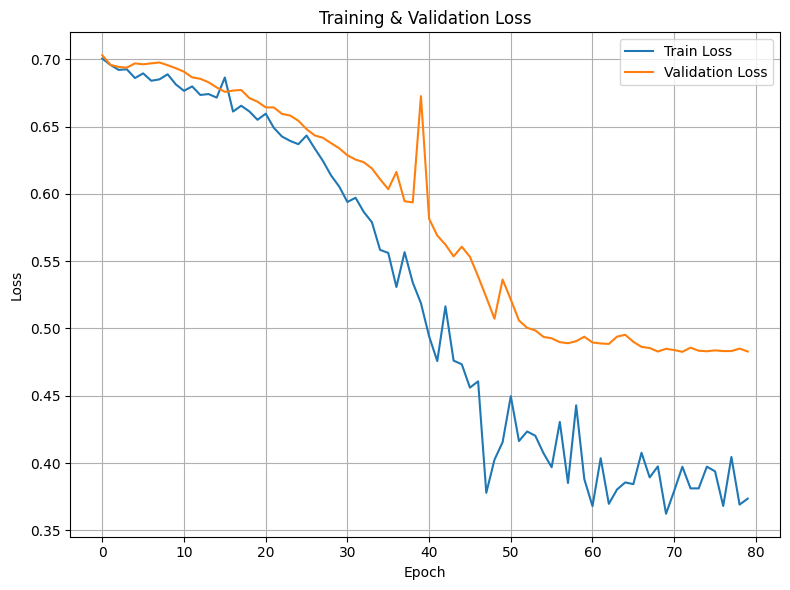


 Final Validation Metrics:
Accuracy : 0.7500
Precision: 0.7500
Recall   : 0.7500
F1 Score : 0.7500
AUC      : 0.8594
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:05<00:00, 35.78it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 46.96it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:39,  2.78s/epoch]

Epoch 1/80 | Train Loss: 0.6881 | Val Loss: 0.6994


Training Progress:   2%|▎         | 2/80 [00:06<04:04,  3.13s/epoch]

Epoch 2/80 | Train Loss: 0.6939 | Val Loss: 0.7015


Training Progress:   4%|▍         | 3/80 [00:09<03:57,  3.09s/epoch]

Epoch 3/80 | Train Loss: 0.6897 | Val Loss: 0.7008


Training Progress:   5%|▌         | 4/80 [00:11<03:41,  2.92s/epoch]

Epoch 4/80 | Train Loss: 0.6859 | Val Loss: 0.6967


Training Progress:   6%|▋         | 5/80 [00:14<03:32,  2.84s/epoch]

Epoch 5/80 | Train Loss: 0.6788 | Val Loss: 0.6946


Training Progress:   8%|▊         | 6/80 [00:17<03:25,  2.78s/epoch]

Epoch 6/80 | Train Loss: 0.6768 | Val Loss: 0.6945


Training Progress:   9%|▉         | 7/80 [00:20<03:43,  3.06s/epoch]

Epoch 7/80 | Train Loss: 0.6821 | Val Loss: 0.6944


Training Progress:  10%|█         | 8/80 [00:23<03:32,  2.95s/epoch]

Epoch 8/80 | Train Loss: 0.6807 | Val Loss: 0.6929


Training Progress:  11%|█▏        | 9/80 [00:26<03:23,  2.87s/epoch]

Epoch 9/80 | Train Loss: 0.6663 | Val Loss: 0.6911


Training Progress:  12%|█▎        | 10/80 [00:28<03:16,  2.80s/epoch]

Epoch 10/80 | Train Loss: 0.6627 | Val Loss: 0.6872


Training Progress:  14%|█▍        | 11/80 [00:32<03:22,  2.93s/epoch]

Epoch 11/80 | Train Loss: 0.6622 | Val Loss: 0.6845


Training Progress:  15%|█▌        | 12/80 [00:35<03:23,  3.00s/epoch]

Epoch 12/80 | Train Loss: 0.6522 | Val Loss: 0.6788


Training Progress:  16%|█▋        | 13/80 [00:37<03:13,  2.90s/epoch]

Epoch 13/80 | Train Loss: 0.6444 | Val Loss: 0.6736


Training Progress:  18%|█▊        | 14/80 [00:40<03:06,  2.83s/epoch]

Epoch 14/80 | Train Loss: 0.6419 | Val Loss: 0.6701


Training Progress:  19%|█▉        | 15/80 [00:43<03:01,  2.79s/epoch]

Epoch 15/80 | Train Loss: 0.6316 | Val Loss: 0.6653


Training Progress:  20%|██        | 16/80 [00:46<03:15,  3.05s/epoch]

Epoch 16/80 | Train Loss: 0.6224 | Val Loss: 0.6628


Training Progress:  21%|██▏       | 17/80 [00:49<03:06,  2.96s/epoch]

Epoch 17/80 | Train Loss: 0.6134 | Val Loss: 0.6583


Training Progress:  22%|██▎       | 18/80 [00:52<02:58,  2.87s/epoch]

Epoch 18/80 | Train Loss: 0.6089 | Val Loss: 0.6499


Training Progress:  24%|██▍       | 19/80 [00:55<02:51,  2.81s/epoch]

Epoch 19/80 | Train Loss: 0.5873 | Val Loss: 0.6449


Training Progress:  25%|██▌       | 20/80 [00:58<02:53,  2.90s/epoch]

Epoch 20/80 | Train Loss: 0.5745 | Val Loss: 0.6355


Training Progress:  26%|██▋       | 21/80 [01:01<02:57,  3.01s/epoch]

Epoch 21/80 | Train Loss: 0.5605 | Val Loss: 0.6283


Training Progress:  28%|██▊       | 22/80 [01:04<02:48,  2.90s/epoch]

Epoch 22/80 | Train Loss: 0.5357 | Val Loss: 0.6242


Training Progress:  29%|██▉       | 23/80 [01:06<02:40,  2.82s/epoch]

Epoch 23/80 | Train Loss: 0.5386 | Val Loss: 0.6180


Training Progress:  30%|███       | 24/80 [01:09<02:35,  2.77s/epoch]

Epoch 24/80 | Train Loss: 0.5108 | Val Loss: 0.6087


Training Progress:  31%|███▏      | 25/80 [01:12<02:45,  3.00s/epoch]

Epoch 25/80 | Train Loss: 0.4799 | Val Loss: 0.5963


Training Progress:  32%|███▎      | 26/80 [01:15<02:40,  2.97s/epoch]

Epoch 26/80 | Train Loss: 0.4983 | Val Loss: 0.5861


Training Progress:  34%|███▍      | 27/80 [01:18<02:32,  2.88s/epoch]

Epoch 27/80 | Train Loss: 0.4608 | Val Loss: 0.5701


Training Progress:  35%|███▌      | 28/80 [01:21<02:26,  2.81s/epoch]

Epoch 28/80 | Train Loss: 0.4288 | Val Loss: 0.5529


Training Progress:  36%|███▋      | 29/80 [01:24<02:24,  2.84s/epoch]

Epoch 29/80 | Train Loss: 0.4464 | Val Loss: 0.5376


Training Progress:  38%|███▊      | 30/80 [01:27<02:31,  3.02s/epoch]

Epoch 30/80 | Train Loss: 0.3895 | Val Loss: 0.5119


Training Progress:  39%|███▉      | 31/80 [01:30<02:23,  2.92s/epoch]

Epoch 31/80 | Train Loss: 0.4008 | Val Loss: 0.4938


Training Progress:  40%|████      | 32/80 [01:32<02:16,  2.85s/epoch]

Epoch 32/80 | Train Loss: 0.3821 | Val Loss: 0.4939


Training Progress:  41%|████▏     | 33/80 [01:35<02:11,  2.80s/epoch]

Epoch 33/80 | Train Loss: 0.3891 | Val Loss: 0.5009


Training Progress:  42%|████▎     | 34/80 [01:38<02:16,  2.97s/epoch]

Epoch 34/80 | Train Loss: 0.3534 | Val Loss: 0.4817


Training Progress:  44%|████▍     | 35/80 [01:41<02:13,  2.97s/epoch]

Epoch 35/80 | Train Loss: 0.3458 | Val Loss: 0.4454


Training Progress:  45%|████▌     | 36/80 [01:44<02:07,  2.89s/epoch]

Epoch 36/80 | Train Loss: 0.3383 | Val Loss: 0.4403


Training Progress:  46%|████▋     | 37/80 [01:47<02:01,  2.82s/epoch]

Epoch 37/80 | Train Loss: 0.3041 | Val Loss: 0.4274


Training Progress:  48%|████▊     | 38/80 [01:49<01:56,  2.78s/epoch]

Epoch 38/80 | Train Loss: 0.2948 | Val Loss: 0.4049


Training Progress:  49%|████▉     | 39/80 [01:53<02:04,  3.04s/epoch]

Epoch 39/80 | Train Loss: 0.2985 | Val Loss: 0.4007


Training Progress:  50%|█████     | 40/80 [01:56<01:57,  2.93s/epoch]

Epoch 40/80 | Train Loss: 0.2601 | Val Loss: 0.3824


Training Progress:  51%|█████▏    | 41/80 [01:58<01:51,  2.85s/epoch]

Epoch 41/80 | Train Loss: 0.2478 | Val Loss: 0.4079


Training Progress:  52%|█████▎    | 42/80 [02:01<01:46,  2.80s/epoch]

Epoch 42/80 | Train Loss: 0.2784 | Val Loss: 0.3516


Training Progress:  54%|█████▍    | 43/80 [02:04<01:47,  2.92s/epoch]

Epoch 43/80 | Train Loss: 0.2241 | Val Loss: 0.3266


Training Progress:  55%|█████▌    | 44/80 [02:07<01:47,  2.98s/epoch]

Epoch 44/80 | Train Loss: 0.2584 | Val Loss: 0.3194


Training Progress:  56%|█████▋    | 45/80 [02:10<01:41,  2.89s/epoch]

Epoch 45/80 | Train Loss: 0.2027 | Val Loss: 0.3210


Training Progress:  57%|█████▊    | 46/80 [02:13<01:35,  2.82s/epoch]

Epoch 46/80 | Train Loss: 0.1835 | Val Loss: 0.3014


Training Progress:  59%|█████▉    | 47/80 [02:15<01:31,  2.77s/epoch]

Epoch 47/80 | Train Loss: 0.1901 | Val Loss: 0.2920


Training Progress:  60%|██████    | 48/80 [02:19<01:36,  3.02s/epoch]

Epoch 48/80 | Train Loss: 0.1926 | Val Loss: 0.2838


Training Progress:  61%|██████▏   | 49/80 [02:22<01:30,  2.93s/epoch]

Epoch 49/80 | Train Loss: 0.2276 | Val Loss: 0.2901


Training Progress:  62%|██████▎   | 50/80 [02:24<01:25,  2.85s/epoch]

Epoch 50/80 | Train Loss: 0.2319 | Val Loss: 0.3367


Training Progress:  64%|██████▍   | 51/80 [02:27<01:21,  2.80s/epoch]

Epoch 51/80 | Train Loss: 0.1885 | Val Loss: 0.3244


Training Progress:  65%|██████▌   | 52/80 [02:30<01:20,  2.86s/epoch]

Epoch 52/80 | Train Loss: 0.1902 | Val Loss: 0.3171


Training Progress:  66%|██████▋   | 53/80 [02:33<01:20,  2.99s/epoch]

Epoch 53/80 | Train Loss: 0.1786 | Val Loss: 0.3033


Training Progress:  68%|██████▊   | 54/80 [02:36<01:15,  2.89s/epoch]

Epoch 54/80 | Train Loss: 0.1907 | Val Loss: 0.2981


Training Progress:  69%|██████▉   | 55/80 [02:39<01:10,  2.82s/epoch]

Epoch 55/80 | Train Loss: 0.1768 | Val Loss: 0.2937


Training Progress:  70%|███████   | 56/80 [02:41<01:06,  2.78s/epoch]

Epoch 56/80 | Train Loss: 0.1653 | Val Loss: 0.2860


Training Progress:  71%|███████▏  | 57/80 [02:45<01:08,  2.97s/epoch]

Epoch 57/80 | Train Loss: 0.1692 | Val Loss: 0.2839


Training Progress:  72%|███████▎  | 58/80 [02:48<01:05,  2.97s/epoch]

Epoch 58/80 | Train Loss: 0.1571 | Val Loss: 0.2905


Training Progress:  74%|███████▍  | 59/80 [02:50<01:00,  2.88s/epoch]

Epoch 59/80 | Train Loss: 0.2264 | Val Loss: 0.2901


Training Progress:  75%|███████▌  | 60/80 [02:53<00:56,  2.82s/epoch]

Epoch 60/80 | Train Loss: 0.1766 | Val Loss: 0.2934


Training Progress:  76%|███████▋  | 61/80 [02:56<00:52,  2.79s/epoch]

Epoch 61/80 | Train Loss: 0.1820 | Val Loss: 0.2949


Training Progress:  78%|███████▊  | 62/80 [02:59<00:54,  3.01s/epoch]

Epoch 62/80 | Train Loss: 0.1867 | Val Loss: 0.2930


Training Progress:  79%|███████▉  | 63/80 [03:02<00:49,  2.90s/epoch]

Epoch 63/80 | Train Loss: 0.1692 | Val Loss: 0.2967


Training Progress:  80%|████████  | 64/80 [03:05<00:45,  2.82s/epoch]

Epoch 64/80 | Train Loss: 0.1322 | Val Loss: 0.2833


Training Progress:  81%|████████▏ | 65/80 [03:07<00:41,  2.78s/epoch]

Epoch 65/80 | Train Loss: 0.1991 | Val Loss: 0.2848


Training Progress:  82%|████████▎ | 66/80 [03:10<00:40,  2.91s/epoch]

Epoch 66/80 | Train Loss: 0.2169 | Val Loss: 0.2876


Training Progress:  84%|████████▍ | 67/80 [03:14<00:38,  2.98s/epoch]

Epoch 67/80 | Train Loss: 0.1772 | Val Loss: 0.2772


Training Progress:  85%|████████▌ | 68/80 [03:16<00:34,  2.88s/epoch]

Epoch 68/80 | Train Loss: 0.1737 | Val Loss: 0.2768


Training Progress:  86%|████████▋ | 69/80 [03:19<00:30,  2.81s/epoch]

Epoch 69/80 | Train Loss: 0.1476 | Val Loss: 0.2760


Training Progress:  88%|████████▊ | 70/80 [03:22<00:27,  2.75s/epoch]

Epoch 70/80 | Train Loss: 0.1814 | Val Loss: 0.2720


Training Progress:  89%|████████▉ | 71/80 [03:25<00:27,  3.02s/epoch]

Epoch 71/80 | Train Loss: 0.1591 | Val Loss: 0.2745


Training Progress:  90%|█████████ | 72/80 [03:28<00:23,  2.92s/epoch]

Epoch 72/80 | Train Loss: 0.1508 | Val Loss: 0.2806


Training Progress:  91%|█████████▏| 73/80 [03:31<00:19,  2.85s/epoch]

Epoch 73/80 | Train Loss: 0.1892 | Val Loss: 0.2788


Training Progress:  92%|█████████▎| 74/80 [03:33<00:16,  2.79s/epoch]

Epoch 74/80 | Train Loss: 0.1726 | Val Loss: 0.2767


Training Progress:  94%|█████████▍| 75/80 [03:36<00:14,  2.86s/epoch]

Epoch 75/80 | Train Loss: 0.1918 | Val Loss: 0.2737


Training Progress:  95%|█████████▌| 76/80 [03:40<00:12,  3.01s/epoch]

Epoch 76/80 | Train Loss: 0.1668 | Val Loss: 0.2754


Training Progress:  96%|█████████▋| 77/80 [03:42<00:08,  2.93s/epoch]

Epoch 77/80 | Train Loss: 0.1456 | Val Loss: 0.2754


Training Progress:  98%|█████████▊| 78/80 [03:45<00:05,  2.86s/epoch]

Epoch 78/80 | Train Loss: 0.1214 | Val Loss: 0.2831


Training Progress:  99%|█████████▉| 79/80 [03:48<00:02,  2.80s/epoch]

Epoch 79/80 | Train Loss: 0.1550 | Val Loss: 0.2821


Training Progress: 100%|██████████| 80/80 [03:51<00:00,  2.90s/epoch]


Epoch 80/80 | Train Loss: 0.1394 | Val Loss: 0.2762


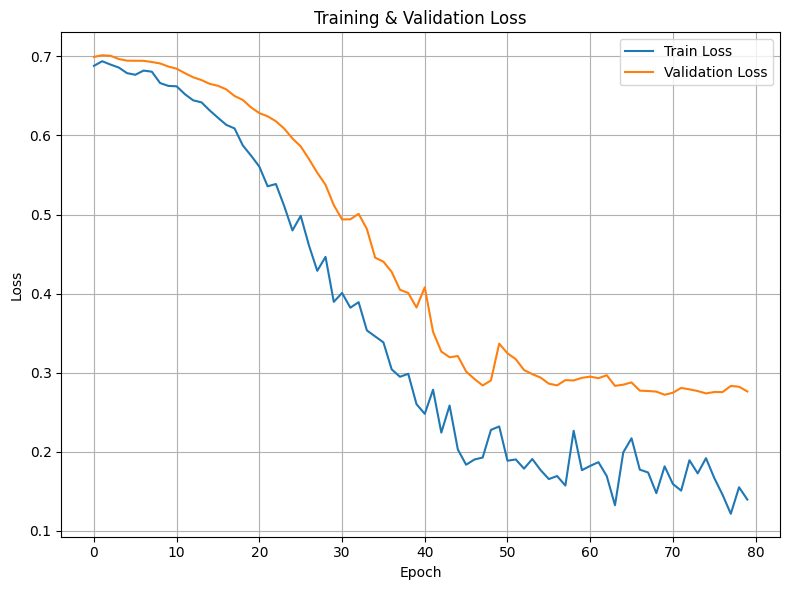


 Final Validation Metrics:
Accuracy : 0.8750
Precision: 0.8261
Recall   : 0.9500
F1 Score : 0.8837
AUC      : 0.9667
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 40.96it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 46.18it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:35,  2.73s/epoch]

Epoch 1/80 | Train Loss: 0.6978 | Val Loss: 0.6996


Training Progress:   2%|▎         | 2/80 [00:05<03:32,  2.72s/epoch]

Epoch 2/80 | Train Loss: 0.6950 | Val Loss: 0.7003


Training Progress:   4%|▍         | 3/80 [00:08<03:53,  3.04s/epoch]

Epoch 3/80 | Train Loss: 0.6925 | Val Loss: 0.6968


Training Progress:   5%|▌         | 4/80 [00:11<03:48,  3.01s/epoch]

Epoch 4/80 | Train Loss: 0.6790 | Val Loss: 0.6937


Training Progress:   6%|▋         | 5/80 [00:14<03:36,  2.88s/epoch]

Epoch 5/80 | Train Loss: 0.6714 | Val Loss: 0.6917


Training Progress:   8%|▊         | 6/80 [00:17<03:28,  2.82s/epoch]

Epoch 6/80 | Train Loss: 0.6646 | Val Loss: 0.6903


Training Progress:   9%|▉         | 7/80 [00:19<03:24,  2.80s/epoch]

Epoch 7/80 | Train Loss: 0.6558 | Val Loss: 0.6866


Training Progress:  10%|█         | 8/80 [00:23<03:40,  3.06s/epoch]

Epoch 8/80 | Train Loss: 0.6486 | Val Loss: 0.6797


Training Progress:  11%|█▏        | 9/80 [00:26<03:29,  2.96s/epoch]

Epoch 9/80 | Train Loss: 0.6413 | Val Loss: 0.6723


Training Progress:  12%|█▎        | 10/80 [00:28<03:21,  2.88s/epoch]

Epoch 10/80 | Train Loss: 0.6392 | Val Loss: 0.6644


Training Progress:  14%|█▍        | 11/80 [00:31<03:15,  2.84s/epoch]

Epoch 11/80 | Train Loss: 0.6298 | Val Loss: 0.6547


Training Progress:  15%|█▌        | 12/80 [00:35<03:24,  3.01s/epoch]

Epoch 12/80 | Train Loss: 0.6146 | Val Loss: 0.6435


Training Progress:  16%|█▋        | 13/80 [00:38<03:23,  3.03s/epoch]

Epoch 13/80 | Train Loss: 0.5986 | Val Loss: 0.6243


Training Progress:  18%|█▊        | 14/80 [00:40<03:14,  2.94s/epoch]

Epoch 14/80 | Train Loss: 0.5965 | Val Loss: 0.6220


Training Progress:  19%|█▉        | 15/80 [00:43<03:06,  2.87s/epoch]

Epoch 15/80 | Train Loss: 0.5720 | Val Loss: 0.5977


Training Progress:  20%|██        | 16/80 [00:46<03:01,  2.84s/epoch]

Epoch 16/80 | Train Loss: 0.5532 | Val Loss: 0.5899


Training Progress:  21%|██▏       | 17/80 [00:50<03:13,  3.07s/epoch]

Epoch 17/80 | Train Loss: 0.5520 | Val Loss: 0.5752


Training Progress:  22%|██▎       | 18/80 [00:52<03:03,  2.95s/epoch]

Epoch 18/80 | Train Loss: 0.5159 | Val Loss: 0.5639


Training Progress:  24%|██▍       | 19/80 [00:55<02:55,  2.88s/epoch]

Epoch 19/80 | Train Loss: 0.4814 | Val Loss: 0.5352


Training Progress:  25%|██▌       | 20/80 [00:58<02:49,  2.82s/epoch]

Epoch 20/80 | Train Loss: 0.4549 | Val Loss: 0.5199


Training Progress:  26%|██▋       | 21/80 [01:01<02:54,  2.95s/epoch]

Epoch 21/80 | Train Loss: 0.4226 | Val Loss: 0.4876


Training Progress:  28%|██▊       | 22/80 [01:04<02:54,  3.01s/epoch]

Epoch 22/80 | Train Loss: 0.4079 | Val Loss: 0.4628


Training Progress:  29%|██▉       | 23/80 [01:07<02:46,  2.92s/epoch]

Epoch 23/80 | Train Loss: 0.3889 | Val Loss: 0.4403


Training Progress:  30%|███       | 24/80 [01:09<02:39,  2.85s/epoch]

Epoch 24/80 | Train Loss: 0.3702 | Val Loss: 0.4156


Training Progress:  31%|███▏      | 25/80 [01:12<02:34,  2.80s/epoch]

Epoch 25/80 | Train Loss: 0.3198 | Val Loss: 0.3904


Training Progress:  32%|███▎      | 26/80 [01:16<02:45,  3.06s/epoch]

Epoch 26/80 | Train Loss: 0.3030 | Val Loss: 0.3788


Training Progress:  34%|███▍      | 27/80 [01:18<02:35,  2.94s/epoch]

Epoch 27/80 | Train Loss: 0.2860 | Val Loss: 0.3634


Training Progress:  35%|███▌      | 28/80 [01:21<02:29,  2.88s/epoch]

Epoch 28/80 | Train Loss: 0.2729 | Val Loss: 0.3483


Training Progress:  36%|███▋      | 29/80 [01:24<02:23,  2.81s/epoch]

Epoch 29/80 | Train Loss: 0.2361 | Val Loss: 0.3423


Training Progress:  38%|███▊      | 30/80 [01:27<02:25,  2.92s/epoch]

Epoch 30/80 | Train Loss: 0.2232 | Val Loss: 0.3186


Training Progress:  39%|███▉      | 31/80 [01:30<02:27,  3.01s/epoch]

Epoch 31/80 | Train Loss: 0.2194 | Val Loss: 0.2958


Training Progress:  40%|████      | 32/80 [01:33<02:20,  2.93s/epoch]

Epoch 32/80 | Train Loss: 0.2164 | Val Loss: 0.2803


Training Progress:  41%|████▏     | 33/80 [01:36<02:15,  2.87s/epoch]

Epoch 33/80 | Train Loss: 0.2084 | Val Loss: 0.2752


Training Progress:  42%|████▎     | 34/80 [01:38<02:09,  2.82s/epoch]

Epoch 34/80 | Train Loss: 0.2084 | Val Loss: 0.2945


Training Progress:  44%|████▍     | 35/80 [01:42<02:18,  3.08s/epoch]

Epoch 35/80 | Train Loss: 0.1778 | Val Loss: 0.2664


Training Progress:  45%|████▌     | 36/80 [01:45<02:10,  2.98s/epoch]

Epoch 36/80 | Train Loss: 0.1709 | Val Loss: 0.2518


Training Progress:  46%|████▋     | 37/80 [01:48<02:04,  2.91s/epoch]

Epoch 37/80 | Train Loss: 0.1481 | Val Loss: 0.2374


Training Progress:  48%|████▊     | 38/80 [01:50<01:59,  2.84s/epoch]

Epoch 38/80 | Train Loss: 0.1308 | Val Loss: 0.2529


Training Progress:  49%|████▉     | 39/80 [01:53<02:01,  2.95s/epoch]

Epoch 39/80 | Train Loss: 0.1840 | Val Loss: 0.2864


Training Progress:  50%|█████     | 40/80 [01:57<02:01,  3.05s/epoch]

Epoch 40/80 | Train Loss: 0.1423 | Val Loss: 0.2286


Training Progress:  51%|█████▏    | 41/80 [01:59<01:54,  2.94s/epoch]

Epoch 41/80 | Train Loss: 0.1501 | Val Loss: 0.2221


Training Progress:  52%|█████▎    | 42/80 [02:02<01:48,  2.87s/epoch]

Epoch 42/80 | Train Loss: 0.1264 | Val Loss: 0.1914


Training Progress:  54%|█████▍    | 43/80 [02:05<01:44,  2.82s/epoch]

Epoch 43/80 | Train Loss: 0.1045 | Val Loss: 0.1852


Training Progress:  55%|█████▌    | 44/80 [02:09<01:51,  3.09s/epoch]

Epoch 44/80 | Train Loss: 0.1166 | Val Loss: 0.1987


Training Progress:  56%|█████▋    | 45/80 [02:11<01:44,  2.97s/epoch]

Epoch 45/80 | Train Loss: 0.1198 | Val Loss: 0.1978


Training Progress:  57%|█████▊    | 46/80 [02:14<01:38,  2.89s/epoch]

Epoch 46/80 | Train Loss: 0.1177 | Val Loss: 0.1819


Training Progress:  59%|█████▉    | 47/80 [02:17<01:33,  2.83s/epoch]

Epoch 47/80 | Train Loss: 0.0853 | Val Loss: 0.1793


Training Progress:  60%|██████    | 48/80 [02:20<01:33,  2.92s/epoch]

Epoch 48/80 | Train Loss: 0.0813 | Val Loss: 0.1780


Training Progress:  61%|██████▏   | 49/80 [02:23<01:33,  3.03s/epoch]

Epoch 49/80 | Train Loss: 0.1063 | Val Loss: 0.1704


Training Progress:  62%|██████▎   | 50/80 [02:26<01:28,  2.95s/epoch]

Epoch 50/80 | Train Loss: 0.0998 | Val Loss: 0.1680


Training Progress:  64%|██████▍   | 51/80 [02:28<01:23,  2.87s/epoch]

Epoch 51/80 | Train Loss: 0.0735 | Val Loss: 0.1586


Training Progress:  65%|██████▌   | 52/80 [02:31<01:18,  2.82s/epoch]

Epoch 52/80 | Train Loss: 0.1301 | Val Loss: 0.1599


Training Progress:  66%|██████▋   | 53/80 [02:35<01:22,  3.06s/epoch]

Epoch 53/80 | Train Loss: 0.0804 | Val Loss: 0.1637


Training Progress:  68%|██████▊   | 54/80 [02:38<01:17,  2.98s/epoch]

Epoch 54/80 | Train Loss: 0.1089 | Val Loss: 0.1592


Training Progress:  69%|██████▉   | 55/80 [02:40<01:12,  2.90s/epoch]

Epoch 55/80 | Train Loss: 0.0798 | Val Loss: 0.1618


Training Progress:  70%|███████   | 56/80 [02:43<01:08,  2.84s/epoch]

Epoch 56/80 | Train Loss: 0.0924 | Val Loss: 0.1684


Training Progress:  71%|███████▏  | 57/80 [02:46<01:07,  2.91s/epoch]

Epoch 57/80 | Train Loss: 0.0776 | Val Loss: 0.1749


Training Progress:  72%|███████▎  | 58/80 [02:49<01:07,  3.05s/epoch]

Epoch 58/80 | Train Loss: 0.0597 | Val Loss: 0.1745


Training Progress:  74%|███████▍  | 59/80 [02:52<01:01,  2.94s/epoch]

Epoch 59/80 | Train Loss: 0.0749 | Val Loss: 0.1683


Training Progress:  75%|███████▌  | 60/80 [02:55<00:57,  2.87s/epoch]

Epoch 60/80 | Train Loss: 0.1176 | Val Loss: 0.1759


Training Progress:  76%|███████▋  | 61/80 [02:58<00:53,  2.81s/epoch]

Epoch 61/80 | Train Loss: 0.0797 | Val Loss: 0.1756


Training Progress:  78%|███████▊  | 62/80 [03:01<00:54,  3.05s/epoch]

Epoch 62/80 | Train Loss: 0.0689 | Val Loss: 0.1752


Training Progress:  79%|███████▉  | 63/80 [03:04<00:51,  3.00s/epoch]

Epoch 63/80 | Train Loss: 0.0844 | Val Loss: 0.1749


Training Progress:  80%|████████  | 64/80 [03:07<00:46,  2.91s/epoch]

Epoch 64/80 | Train Loss: 0.0740 | Val Loss: 0.1657


Training Progress:  81%|████████▏ | 65/80 [03:09<00:42,  2.85s/epoch]

Epoch 65/80 | Train Loss: 0.0703 | Val Loss: 0.1655


Training Progress:  82%|████████▎ | 66/80 [03:12<00:40,  2.89s/epoch]

Epoch 66/80 | Train Loss: 0.0666 | Val Loss: 0.1767


Training Progress:  84%|████████▍ | 67/80 [03:16<00:39,  3.04s/epoch]

Epoch 67/80 | Train Loss: 0.0764 | Val Loss: 0.1767


Training Progress:  85%|████████▌ | 68/80 [03:18<00:35,  2.94s/epoch]

Epoch 68/80 | Train Loss: 0.0846 | Val Loss: 0.1670


Training Progress:  86%|████████▋ | 69/80 [03:21<00:31,  2.87s/epoch]

Epoch 69/80 | Train Loss: 0.0810 | Val Loss: 0.1677


Training Progress:  88%|████████▊ | 70/80 [03:24<00:28,  2.82s/epoch]

Epoch 70/80 | Train Loss: 0.0720 | Val Loss: 0.1655


Training Progress:  89%|████████▉ | 71/80 [03:27<00:27,  3.04s/epoch]

Epoch 71/80 | Train Loss: 0.0668 | Val Loss: 0.1617


Training Progress:  90%|█████████ | 72/80 [03:30<00:24,  3.00s/epoch]

Epoch 72/80 | Train Loss: 0.1028 | Val Loss: 0.1630


Training Progress:  91%|█████████▏| 73/80 [03:33<00:20,  2.91s/epoch]

Epoch 73/80 | Train Loss: 0.0817 | Val Loss: 0.1610


Training Progress:  92%|█████████▎| 74/80 [03:36<00:17,  2.85s/epoch]

Epoch 74/80 | Train Loss: 0.0603 | Val Loss: 0.1599


Training Progress:  94%|█████████▍| 75/80 [03:39<00:14,  2.88s/epoch]

Epoch 75/80 | Train Loss: 0.0578 | Val Loss: 0.1622


Training Progress:  95%|█████████▌| 76/80 [03:42<00:12,  3.05s/epoch]

Epoch 76/80 | Train Loss: 0.1025 | Val Loss: 0.1621


Training Progress:  96%|█████████▋| 77/80 [03:45<00:08,  2.95s/epoch]

Epoch 77/80 | Train Loss: 0.0709 | Val Loss: 0.1671


Training Progress:  98%|█████████▊| 78/80 [03:48<00:05,  2.88s/epoch]

Epoch 78/80 | Train Loss: 0.0707 | Val Loss: 0.1626


Training Progress:  99%|█████████▉| 79/80 [03:50<00:02,  2.83s/epoch]

Epoch 79/80 | Train Loss: 0.0802 | Val Loss: 0.1640


Training Progress: 100%|██████████| 80/80 [03:54<00:00,  2.93s/epoch]


Epoch 80/80 | Train Loss: 0.0703 | Val Loss: 0.1631


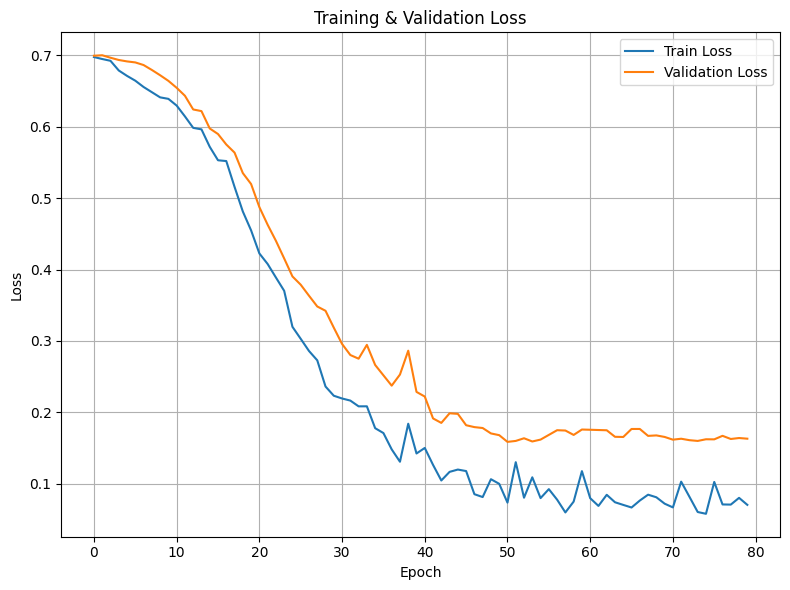


 Final Validation Metrics:
Accuracy : 0.9167
Precision: 0.8676
Recall   : 0.9833
F1 Score : 0.9219
AUC      : 0.9892
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 42.12it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 45.11it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:02<03:36,  2.74s/epoch]

Epoch 1/80 | Train Loss: 0.6885 | Val Loss: 0.6921


Training Progress:   2%|▎         | 2/80 [00:05<03:31,  2.71s/epoch]

Epoch 2/80 | Train Loss: 0.6812 | Val Loss: 0.6877


Training Progress:   4%|▍         | 3/80 [00:08<03:53,  3.03s/epoch]

Epoch 3/80 | Train Loss: 0.6812 | Val Loss: 0.6800


Training Progress:   5%|▌         | 4/80 [00:11<03:51,  3.05s/epoch]

Epoch 4/80 | Train Loss: 0.6667 | Val Loss: 0.6747


Training Progress:   6%|▋         | 5/80 [00:14<03:39,  2.92s/epoch]

Epoch 5/80 | Train Loss: 0.6637 | Val Loss: 0.6689


Training Progress:   8%|▊         | 6/80 [00:17<03:30,  2.84s/epoch]

Epoch 6/80 | Train Loss: 0.6571 | Val Loss: 0.6617


Training Progress:   9%|▉         | 7/80 [00:19<03:23,  2.79s/epoch]

Epoch 7/80 | Train Loss: 0.6431 | Val Loss: 0.6505


Training Progress:  10%|█         | 8/80 [00:23<03:40,  3.06s/epoch]

Epoch 8/80 | Train Loss: 0.6434 | Val Loss: 0.6372


Training Progress:  11%|█▏        | 9/80 [00:26<03:29,  2.95s/epoch]

Epoch 9/80 | Train Loss: 0.6421 | Val Loss: 0.6310


Training Progress:  12%|█▎        | 10/80 [00:29<03:20,  2.87s/epoch]

Epoch 10/80 | Train Loss: 0.6151 | Val Loss: 0.6235


Training Progress:  14%|█▍        | 11/80 [00:31<03:14,  2.81s/epoch]

Epoch 11/80 | Train Loss: 0.5988 | Val Loss: 0.6117


Training Progress:  15%|█▌        | 12/80 [00:34<03:19,  2.93s/epoch]

Epoch 12/80 | Train Loss: 0.5906 | Val Loss: 0.5954


Training Progress:  16%|█▋        | 13/80 [00:38<03:21,  3.01s/epoch]

Epoch 13/80 | Train Loss: 0.5704 | Val Loss: 0.5844


Training Progress:  18%|█▊        | 14/80 [00:40<03:13,  2.93s/epoch]

Epoch 14/80 | Train Loss: 0.5566 | Val Loss: 0.5708


Training Progress:  19%|█▉        | 15/80 [00:43<03:05,  2.86s/epoch]

Epoch 15/80 | Train Loss: 0.5338 | Val Loss: 0.5507


Training Progress:  20%|██        | 16/80 [00:46<03:00,  2.81s/epoch]

Epoch 16/80 | Train Loss: 0.5040 | Val Loss: 0.5380


Training Progress:  21%|██▏       | 17/80 [00:49<03:13,  3.07s/epoch]

Epoch 17/80 | Train Loss: 0.4828 | Val Loss: 0.5185


Training Progress:  22%|██▎       | 18/80 [00:52<03:03,  2.95s/epoch]

Epoch 18/80 | Train Loss: 0.4658 | Val Loss: 0.4859


Training Progress:  24%|██▍       | 19/80 [00:55<02:54,  2.87s/epoch]

Epoch 19/80 | Train Loss: 0.4176 | Val Loss: 0.4637


Training Progress:  25%|██▌       | 20/80 [00:57<02:49,  2.82s/epoch]

Epoch 20/80 | Train Loss: 0.4172 | Val Loss: 0.4412


Training Progress:  26%|██▋       | 21/80 [01:01<02:51,  2.91s/epoch]

Epoch 21/80 | Train Loss: 0.3896 | Val Loss: 0.4124


Training Progress:  28%|██▊       | 22/80 [01:04<02:54,  3.01s/epoch]

Epoch 22/80 | Train Loss: 0.3425 | Val Loss: 0.3845


Training Progress:  29%|██▉       | 23/80 [01:06<02:45,  2.90s/epoch]

Epoch 23/80 | Train Loss: 0.3375 | Val Loss: 0.3558


Training Progress:  30%|███       | 24/80 [01:09<02:38,  2.82s/epoch]

Epoch 24/80 | Train Loss: 0.3205 | Val Loss: 0.3213


Training Progress:  31%|███▏      | 25/80 [01:12<02:33,  2.79s/epoch]

Epoch 25/80 | Train Loss: 0.2942 | Val Loss: 0.3229


Training Progress:  32%|███▎      | 26/80 [01:15<02:43,  3.03s/epoch]

Epoch 26/80 | Train Loss: 0.2664 | Val Loss: 0.2911


Training Progress:  34%|███▍      | 27/80 [01:18<02:37,  2.97s/epoch]

Epoch 27/80 | Train Loss: 0.2324 | Val Loss: 0.2850


Training Progress:  35%|███▌      | 28/80 [01:21<02:30,  2.89s/epoch]

Epoch 28/80 | Train Loss: 0.2421 | Val Loss: 0.2542


Training Progress:  36%|███▋      | 29/80 [01:24<02:23,  2.82s/epoch]

Epoch 29/80 | Train Loss: 0.2456 | Val Loss: 0.2363


Training Progress:  38%|███▊      | 30/80 [01:27<02:23,  2.88s/epoch]

Epoch 30/80 | Train Loss: 0.1830 | Val Loss: 0.2161


Training Progress:  39%|███▉      | 31/80 [01:30<02:28,  3.03s/epoch]

Epoch 31/80 | Train Loss: 0.1756 | Val Loss: 0.2095


Training Progress:  40%|████      | 32/80 [01:33<02:20,  2.94s/epoch]

Epoch 32/80 | Train Loss: 0.1731 | Val Loss: 0.1869


Training Progress:  41%|████▏     | 33/80 [01:35<02:14,  2.86s/epoch]

Epoch 33/80 | Train Loss: 0.1635 | Val Loss: 0.1725


Training Progress:  42%|████▎     | 34/80 [01:38<02:09,  2.81s/epoch]

Epoch 34/80 | Train Loss: 0.1904 | Val Loss: 0.1825


Training Progress:  44%|████▍     | 35/80 [01:42<02:16,  3.03s/epoch]

Epoch 35/80 | Train Loss: 0.1361 | Val Loss: 0.1619


Training Progress:  45%|████▌     | 36/80 [01:45<02:11,  2.98s/epoch]

Epoch 36/80 | Train Loss: 0.1476 | Val Loss: 0.1704


Training Progress:  46%|████▋     | 37/80 [01:47<02:04,  2.89s/epoch]

Epoch 37/80 | Train Loss: 0.1323 | Val Loss: 0.1328


Training Progress:  48%|████▊     | 38/80 [01:50<01:58,  2.83s/epoch]

Epoch 38/80 | Train Loss: 0.1274 | Val Loss: 0.1218


Training Progress:  49%|████▉     | 39/80 [01:53<01:55,  2.81s/epoch]

Epoch 39/80 | Train Loss: 0.1289 | Val Loss: 0.1111


Training Progress:  50%|█████     | 40/80 [01:56<02:01,  3.03s/epoch]

Epoch 40/80 | Train Loss: 0.1223 | Val Loss: 0.1150


Training Progress:  51%|█████▏    | 41/80 [01:59<01:53,  2.91s/epoch]

Epoch 41/80 | Train Loss: 0.1237 | Val Loss: 0.1060


Training Progress:  52%|█████▎    | 42/80 [02:01<01:47,  2.84s/epoch]

Epoch 42/80 | Train Loss: 0.1103 | Val Loss: 0.0947


Training Progress:  54%|█████▍    | 43/80 [02:04<01:43,  2.79s/epoch]

Epoch 43/80 | Train Loss: 0.0914 | Val Loss: 0.0886


Training Progress:  55%|█████▌    | 44/80 [02:07<01:45,  2.92s/epoch]

Epoch 44/80 | Train Loss: 0.0964 | Val Loss: 0.0813


Training Progress:  56%|█████▋    | 45/80 [02:11<01:44,  2.99s/epoch]

Epoch 45/80 | Train Loss: 0.0825 | Val Loss: 0.0874


Training Progress:  57%|█████▊    | 46/80 [02:13<01:38,  2.89s/epoch]

Epoch 46/80 | Train Loss: 0.0885 | Val Loss: 0.0899


Training Progress:  59%|█████▉    | 47/80 [02:16<01:33,  2.83s/epoch]

Epoch 47/80 | Train Loss: 0.1026 | Val Loss: 0.0928


Training Progress:  60%|██████    | 48/80 [02:19<01:29,  2.78s/epoch]

Epoch 48/80 | Train Loss: 0.1039 | Val Loss: 0.0829


Training Progress:  61%|██████▏   | 49/80 [02:22<01:34,  3.04s/epoch]

Epoch 49/80 | Train Loss: 0.0733 | Val Loss: 0.0928


Training Progress:  62%|██████▎   | 50/80 [02:25<01:27,  2.92s/epoch]

Epoch 50/80 | Train Loss: 0.0970 | Val Loss: 0.0961


Training Progress:  64%|██████▍   | 51/80 [02:28<01:22,  2.86s/epoch]

Epoch 51/80 | Train Loss: 0.0963 | Val Loss: 0.0850


Training Progress:  65%|██████▌   | 52/80 [02:30<01:18,  2.80s/epoch]

Epoch 52/80 | Train Loss: 0.0685 | Val Loss: 0.0782


Training Progress:  66%|██████▋   | 53/80 [02:33<01:18,  2.90s/epoch]

Epoch 53/80 | Train Loss: 0.0698 | Val Loss: 0.0805


Training Progress:  68%|██████▊   | 54/80 [02:37<01:18,  3.00s/epoch]

Epoch 54/80 | Train Loss: 0.0620 | Val Loss: 0.0787


Training Progress:  69%|██████▉   | 55/80 [02:39<01:12,  2.90s/epoch]

Epoch 55/80 | Train Loss: 0.0719 | Val Loss: 0.0762


Training Progress:  70%|███████   | 56/80 [02:42<01:07,  2.83s/epoch]

Epoch 56/80 | Train Loss: 0.0619 | Val Loss: 0.0761


Training Progress:  71%|███████▏  | 57/80 [02:45<01:03,  2.78s/epoch]

Epoch 57/80 | Train Loss: 0.0961 | Val Loss: 0.0774


Training Progress:  72%|███████▎  | 58/80 [02:48<01:06,  3.03s/epoch]

Epoch 58/80 | Train Loss: 0.0522 | Val Loss: 0.0758


Training Progress:  74%|███████▍  | 59/80 [02:51<01:02,  2.97s/epoch]

Epoch 59/80 | Train Loss: 0.0771 | Val Loss: 0.0772


Training Progress:  75%|███████▌  | 60/80 [02:54<00:57,  2.89s/epoch]

Epoch 60/80 | Train Loss: 0.0736 | Val Loss: 0.0779


Training Progress:  76%|███████▋  | 61/80 [02:56<00:53,  2.83s/epoch]

Epoch 61/80 | Train Loss: 0.0588 | Val Loss: 0.0738


Training Progress:  78%|███████▊  | 62/80 [02:59<00:51,  2.86s/epoch]

Epoch 62/80 | Train Loss: 0.0705 | Val Loss: 0.0754


Training Progress:  79%|███████▉  | 63/80 [03:03<00:51,  3.02s/epoch]

Epoch 63/80 | Train Loss: 0.0757 | Val Loss: 0.0723


Training Progress:  80%|████████  | 64/80 [03:05<00:46,  2.92s/epoch]

Epoch 64/80 | Train Loss: 0.0637 | Val Loss: 0.0722


Training Progress:  81%|████████▏ | 65/80 [03:08<00:42,  2.84s/epoch]

Epoch 65/80 | Train Loss: 0.0600 | Val Loss: 0.0712


Training Progress:  82%|████████▎ | 66/80 [03:11<00:39,  2.79s/epoch]

Epoch 66/80 | Train Loss: 0.0642 | Val Loss: 0.0715


Training Progress:  84%|████████▍ | 67/80 [03:14<00:38,  2.99s/epoch]

Epoch 67/80 | Train Loss: 0.0825 | Val Loss: 0.0707


Training Progress:  85%|████████▌ | 68/80 [03:17<00:35,  2.98s/epoch]

Epoch 68/80 | Train Loss: 0.0562 | Val Loss: 0.0759


Training Progress:  86%|████████▋ | 69/80 [03:20<00:31,  2.89s/epoch]

Epoch 69/80 | Train Loss: 0.0510 | Val Loss: 0.0743


Training Progress:  88%|████████▊ | 70/80 [03:22<00:28,  2.82s/epoch]

Epoch 70/80 | Train Loss: 0.0560 | Val Loss: 0.0718


Training Progress:  89%|████████▉ | 71/80 [03:25<00:25,  2.82s/epoch]

Epoch 71/80 | Train Loss: 0.0750 | Val Loss: 0.0714


Training Progress:  90%|█████████ | 72/80 [03:29<00:24,  3.04s/epoch]

Epoch 72/80 | Train Loss: 0.0774 | Val Loss: 0.0700


Training Progress:  91%|█████████▏| 73/80 [03:31<00:20,  2.93s/epoch]

Epoch 73/80 | Train Loss: 0.1098 | Val Loss: 0.0704


Training Progress:  92%|█████████▎| 74/80 [03:34<00:17,  2.85s/epoch]

Epoch 74/80 | Train Loss: 0.0691 | Val Loss: 0.0716


Training Progress:  94%|█████████▍| 75/80 [03:37<00:13,  2.80s/epoch]

Epoch 75/80 | Train Loss: 0.0869 | Val Loss: 0.0719


Training Progress:  95%|█████████▌| 76/80 [03:40<00:11,  2.95s/epoch]

Epoch 76/80 | Train Loss: 0.0817 | Val Loss: 0.0705


Training Progress:  96%|█████████▋| 77/80 [03:43<00:08,  2.98s/epoch]

Epoch 77/80 | Train Loss: 0.0590 | Val Loss: 0.0708


Training Progress:  98%|█████████▊| 78/80 [03:46<00:05,  2.88s/epoch]

Epoch 78/80 | Train Loss: 0.0666 | Val Loss: 0.0708


Training Progress:  99%|█████████▉| 79/80 [03:48<00:02,  2.81s/epoch]

Epoch 79/80 | Train Loss: 0.1203 | Val Loss: 0.0720


Training Progress: 100%|██████████| 80/80 [03:51<00:00,  2.90s/epoch]


Epoch 80/80 | Train Loss: 0.0847 | Val Loss: 0.0702


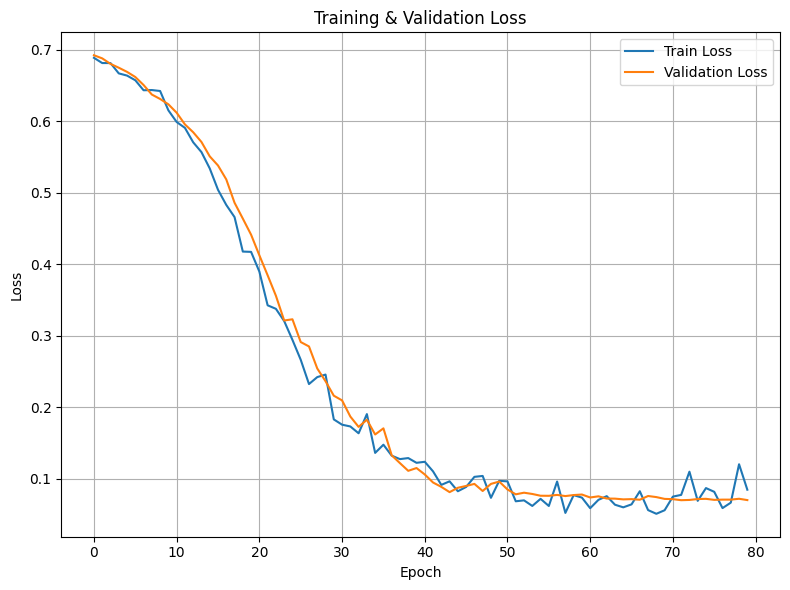


 Final Validation Metrics:
Accuracy : 0.9917
Precision: 0.9836
Recall   : 1.0000
F1 Score : 0.9917
AUC      : 1.0000


In [ ]:
architecture = "resnet18"
results[architecture] = {}
names = ["E60-50", "E60-40", "E70-40", "E80-50", "E70-30", "E80-20", "E90-10", "E100-0"]

for name in names:
    datadir ="DATA/" + name

    results[architecture][name] = train_and_validate(datadir, architecture)

# ResNet50

Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 37.81it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 50.35it/s]


All images saved in 'dataset/' folder structure.


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:41,  4.32s/epoch]

Epoch 1/80 | Train Loss: 0.6993 | Val Loss: 0.6900


Training Progress:   2%|▎         | 2/80 [00:09<05:59,  4.61s/epoch]

Epoch 2/80 | Train Loss: 0.6919 | Val Loss: 0.6924


Training Progress:   4%|▍         | 3/80 [00:13<05:41,  4.44s/epoch]

Epoch 3/80 | Train Loss: 0.6930 | Val Loss: 0.6989


Training Progress:   5%|▌         | 4/80 [00:17<05:32,  4.38s/epoch]

Epoch 4/80 | Train Loss: 0.6918 | Val Loss: 0.6987


Training Progress:   6%|▋         | 5/80 [00:22<05:39,  4.53s/epoch]

Epoch 5/80 | Train Loss: 0.6941 | Val Loss: 0.7000


Training Progress:   8%|▊         | 6/80 [00:26<05:26,  4.41s/epoch]

Epoch 6/80 | Train Loss: 0.6939 | Val Loss: 0.6972


Training Progress:   9%|▉         | 7/80 [00:30<05:15,  4.32s/epoch]

Epoch 7/80 | Train Loss: 0.6931 | Val Loss: 0.6964


Training Progress:  10%|█         | 8/80 [00:35<05:20,  4.45s/epoch]

Epoch 8/80 | Train Loss: 0.6915 | Val Loss: 0.6961


Training Progress:  11%|█▏        | 9/80 [00:39<05:08,  4.35s/epoch]

Epoch 9/80 | Train Loss: 0.6942 | Val Loss: 0.6930


Training Progress:  12%|█▎        | 10/80 [00:43<04:58,  4.27s/epoch]

Epoch 10/80 | Train Loss: 0.6913 | Val Loss: 0.6950


Training Progress:  14%|█▍        | 11/80 [00:48<05:03,  4.40s/epoch]

Epoch 11/80 | Train Loss: 0.6919 | Val Loss: 0.6938


Training Progress:  15%|█▌        | 12/80 [00:52<04:52,  4.30s/epoch]

Epoch 12/80 | Train Loss: 0.6921 | Val Loss: 0.6942


Training Progress:  16%|█▋        | 13/80 [00:56<04:43,  4.23s/epoch]

Epoch 13/80 | Train Loss: 0.6919 | Val Loss: 0.6953


Training Progress:  18%|█▊        | 14/80 [01:01<04:49,  4.39s/epoch]

Epoch 14/80 | Train Loss: 0.6898 | Val Loss: 0.6951


Training Progress:  19%|█▉        | 15/80 [01:05<04:39,  4.29s/epoch]

Epoch 15/80 | Train Loss: 0.6879 | Val Loss: 0.6939


Training Progress:  20%|██        | 16/80 [01:09<04:30,  4.23s/epoch]

Epoch 16/80 | Train Loss: 0.6928 | Val Loss: 0.6937


Training Progress:  21%|██▏       | 17/80 [01:14<04:37,  4.41s/epoch]

Epoch 17/80 | Train Loss: 0.6928 | Val Loss: 0.6933


Training Progress:  22%|██▎       | 18/80 [01:18<04:27,  4.31s/epoch]

Epoch 18/80 | Train Loss: 0.6801 | Val Loss: 0.6942


Training Progress:  24%|██▍       | 19/80 [01:22<04:19,  4.26s/epoch]

Epoch 19/80 | Train Loss: 0.6838 | Val Loss: 0.6950


Training Progress:  25%|██▌       | 20/80 [01:27<04:24,  4.42s/epoch]

Epoch 20/80 | Train Loss: 0.6814 | Val Loss: 0.6922


Training Progress:  26%|██▋       | 21/80 [01:31<04:16,  4.34s/epoch]

Epoch 21/80 | Train Loss: 0.6919 | Val Loss: 0.6893


Training Progress:  28%|██▊       | 22/80 [01:35<04:08,  4.29s/epoch]

Epoch 22/80 | Train Loss: 0.6884 | Val Loss: 0.6923


Training Progress:  29%|██▉       | 23/80 [01:40<04:13,  4.45s/epoch]

Epoch 23/80 | Train Loss: 0.6888 | Val Loss: 0.6917


Training Progress:  30%|███       | 24/80 [01:44<04:04,  4.37s/epoch]

Epoch 24/80 | Train Loss: 0.6832 | Val Loss: 0.6931


Training Progress:  31%|███▏      | 25/80 [01:48<03:57,  4.31s/epoch]

Epoch 25/80 | Train Loss: 0.6888 | Val Loss: 0.6920


Training Progress:  32%|███▎      | 26/80 [01:53<04:01,  4.46s/epoch]

Epoch 26/80 | Train Loss: 0.6876 | Val Loss: 0.6906


Training Progress:  34%|███▍      | 27/80 [01:57<03:52,  4.38s/epoch]

Epoch 27/80 | Train Loss: 0.6841 | Val Loss: 0.6894


Training Progress:  35%|███▌      | 28/80 [02:01<03:43,  4.30s/epoch]

Epoch 28/80 | Train Loss: 0.6822 | Val Loss: 0.6861


Training Progress:  36%|███▋      | 29/80 [02:06<03:46,  4.45s/epoch]

Epoch 29/80 | Train Loss: 0.6836 | Val Loss: 0.6851


Training Progress:  38%|███▊      | 30/80 [02:10<03:37,  4.34s/epoch]

Epoch 30/80 | Train Loss: 0.6753 | Val Loss: 0.6851


Training Progress:  39%|███▉      | 31/80 [02:14<03:29,  4.27s/epoch]

Epoch 31/80 | Train Loss: 0.6742 | Val Loss: 0.6856


Training Progress:  40%|████      | 32/80 [02:19<03:32,  4.42s/epoch]

Epoch 32/80 | Train Loss: 0.6793 | Val Loss: 0.6848


Training Progress:  41%|████▏     | 33/80 [02:23<03:24,  4.34s/epoch]

Epoch 33/80 | Train Loss: 0.6723 | Val Loss: 0.6900


Training Progress:  42%|████▎     | 34/80 [02:27<03:17,  4.28s/epoch]

Epoch 34/80 | Train Loss: 0.6752 | Val Loss: 0.6975


Training Progress:  44%|████▍     | 35/80 [02:32<03:19,  4.44s/epoch]

Epoch 35/80 | Train Loss: 0.6782 | Val Loss: 0.6986


Training Progress:  45%|████▌     | 36/80 [02:36<03:11,  4.35s/epoch]

Epoch 36/80 | Train Loss: 0.6697 | Val Loss: 0.7004


Training Progress:  46%|████▋     | 37/80 [02:41<03:04,  4.29s/epoch]

Epoch 37/80 | Train Loss: 0.6760 | Val Loss: 0.7004


Training Progress:  48%|████▊     | 38/80 [02:45<03:06,  4.43s/epoch]

Epoch 38/80 | Train Loss: 0.6706 | Val Loss: 0.7022


Training Progress:  49%|████▉     | 39/80 [02:49<02:58,  4.35s/epoch]

Epoch 39/80 | Train Loss: 0.6620 | Val Loss: 0.6999


Training Progress:  50%|█████     | 40/80 [02:54<02:51,  4.28s/epoch]

Epoch 40/80 | Train Loss: 0.6614 | Val Loss: 0.6989


Training Progress:  51%|█████▏    | 41/80 [02:58<02:52,  4.43s/epoch]

Epoch 41/80 | Train Loss: 0.6609 | Val Loss: 0.6998


Training Progress:  52%|█████▎    | 42/80 [03:03<02:45,  4.36s/epoch]

Epoch 42/80 | Train Loss: 0.6511 | Val Loss: 0.7145


Training Progress:  54%|█████▍    | 43/80 [03:07<02:38,  4.30s/epoch]

Epoch 43/80 | Train Loss: 0.6540 | Val Loss: 0.7222


Training Progress:  55%|█████▌    | 44/80 [03:12<02:40,  4.45s/epoch]

Epoch 44/80 | Train Loss: 0.6569 | Val Loss: 0.7324


Training Progress:  56%|█████▋    | 45/80 [03:16<02:32,  4.36s/epoch]

Epoch 45/80 | Train Loss: 0.6472 | Val Loss: 0.7255


Training Progress:  57%|█████▊    | 46/80 [03:20<02:25,  4.29s/epoch]

Epoch 46/80 | Train Loss: 0.6661 | Val Loss: 0.7253


Training Progress:  59%|█████▉    | 47/80 [03:25<02:26,  4.44s/epoch]

Epoch 47/80 | Train Loss: 0.6445 | Val Loss: 0.7349


Training Progress:  60%|██████    | 48/80 [03:29<02:19,  4.35s/epoch]

Epoch 48/80 | Train Loss: 0.6411 | Val Loss: 0.7355


Training Progress:  61%|██████▏   | 49/80 [03:33<02:12,  4.29s/epoch]

Epoch 49/80 | Train Loss: 0.6392 | Val Loss: 0.7237


Training Progress:  62%|██████▎   | 50/80 [03:38<02:13,  4.43s/epoch]

Epoch 50/80 | Train Loss: 0.6358 | Val Loss: 0.7207


Training Progress:  64%|██████▍   | 51/80 [03:42<02:05,  4.33s/epoch]

Epoch 51/80 | Train Loss: 0.6226 | Val Loss: 0.7210


Training Progress:  65%|██████▌   | 52/80 [03:46<01:59,  4.26s/epoch]

Epoch 52/80 | Train Loss: 0.6406 | Val Loss: 0.7189


Training Progress:  66%|██████▋   | 53/80 [03:51<01:59,  4.42s/epoch]

Epoch 53/80 | Train Loss: 0.6306 | Val Loss: 0.7196


Training Progress:  68%|██████▊   | 54/80 [03:55<01:52,  4.33s/epoch]

Epoch 54/80 | Train Loss: 0.6389 | Val Loss: 0.7222


Training Progress:  69%|██████▉   | 55/80 [03:59<01:46,  4.26s/epoch]

Epoch 55/80 | Train Loss: 0.6286 | Val Loss: 0.7172


Training Progress:  70%|███████   | 56/80 [04:04<01:46,  4.44s/epoch]

Epoch 56/80 | Train Loss: 0.6340 | Val Loss: 0.7157


Training Progress:  71%|███████▏  | 57/80 [04:08<01:40,  4.36s/epoch]

Epoch 57/80 | Train Loss: 0.6309 | Val Loss: 0.7137


Training Progress:  72%|███████▎  | 58/80 [04:12<01:34,  4.29s/epoch]

Epoch 58/80 | Train Loss: 0.6324 | Val Loss: 0.7161


Training Progress:  74%|███████▍  | 59/80 [04:17<01:33,  4.45s/epoch]

Epoch 59/80 | Train Loss: 0.6179 | Val Loss: 0.7156


Training Progress:  75%|███████▌  | 60/80 [04:21<01:27,  4.37s/epoch]

Epoch 60/80 | Train Loss: 0.6195 | Val Loss: 0.7215


Training Progress:  76%|███████▋  | 61/80 [04:25<01:21,  4.30s/epoch]

Epoch 61/80 | Train Loss: 0.6287 | Val Loss: 0.7196


Training Progress:  78%|███████▊  | 62/80 [04:30<01:20,  4.46s/epoch]

Epoch 62/80 | Train Loss: 0.6241 | Val Loss: 0.7148


Training Progress:  79%|███████▉  | 63/80 [04:34<01:14,  4.36s/epoch]

Epoch 63/80 | Train Loss: 0.6366 | Val Loss: 0.7212


Training Progress:  80%|████████  | 64/80 [04:38<01:08,  4.28s/epoch]

Epoch 64/80 | Train Loss: 0.6237 | Val Loss: 0.7156


Training Progress:  81%|████████▏ | 65/80 [04:43<01:06,  4.45s/epoch]

Epoch 65/80 | Train Loss: 0.6213 | Val Loss: 0.7151


Training Progress:  82%|████████▎ | 66/80 [04:47<01:00,  4.36s/epoch]

Epoch 66/80 | Train Loss: 0.6281 | Val Loss: 0.7134


Training Progress:  84%|████████▍ | 67/80 [04:51<00:55,  4.28s/epoch]

Epoch 67/80 | Train Loss: 0.6318 | Val Loss: 0.7141


Training Progress:  85%|████████▌ | 68/80 [04:56<00:53,  4.45s/epoch]

Epoch 68/80 | Train Loss: 0.6327 | Val Loss: 0.7172


Training Progress:  86%|████████▋ | 69/80 [05:00<00:47,  4.36s/epoch]

Epoch 69/80 | Train Loss: 0.6261 | Val Loss: 0.7174


Training Progress:  88%|████████▊ | 70/80 [05:04<00:42,  4.29s/epoch]

Epoch 70/80 | Train Loss: 0.6189 | Val Loss: 0.7149


Training Progress:  89%|████████▉ | 71/80 [05:09<00:40,  4.45s/epoch]

Epoch 71/80 | Train Loss: 0.6356 | Val Loss: 0.7171


Training Progress:  90%|█████████ | 72/80 [05:13<00:34,  4.37s/epoch]

Epoch 72/80 | Train Loss: 0.6165 | Val Loss: 0.7199


Training Progress:  91%|█████████▏| 73/80 [05:18<00:30,  4.31s/epoch]

Epoch 73/80 | Train Loss: 0.6194 | Val Loss: 0.7238


Training Progress:  92%|█████████▎| 74/80 [05:23<00:26,  4.47s/epoch]

Epoch 74/80 | Train Loss: 0.6268 | Val Loss: 0.7234


Training Progress:  94%|█████████▍| 75/80 [05:27<00:21,  4.36s/epoch]

Epoch 75/80 | Train Loss: 0.6473 | Val Loss: 0.7249


Training Progress:  95%|█████████▌| 76/80 [05:31<00:17,  4.29s/epoch]

Epoch 76/80 | Train Loss: 0.6086 | Val Loss: 0.7160


Training Progress:  96%|█████████▋| 77/80 [05:36<00:13,  4.46s/epoch]

Epoch 77/80 | Train Loss: 0.6252 | Val Loss: 0.7211


Training Progress:  98%|█████████▊| 78/80 [05:40<00:08,  4.36s/epoch]

Epoch 78/80 | Train Loss: 0.6297 | Val Loss: 0.7188


Training Progress:  99%|█████████▉| 79/80 [05:44<00:04,  4.29s/epoch]

Epoch 79/80 | Train Loss: 0.6222 | Val Loss: 0.7185


Training Progress: 100%|██████████| 80/80 [05:49<00:00,  4.37s/epoch]

Epoch 80/80 | Train Loss: 0.6256 | Val Loss: 0.7188


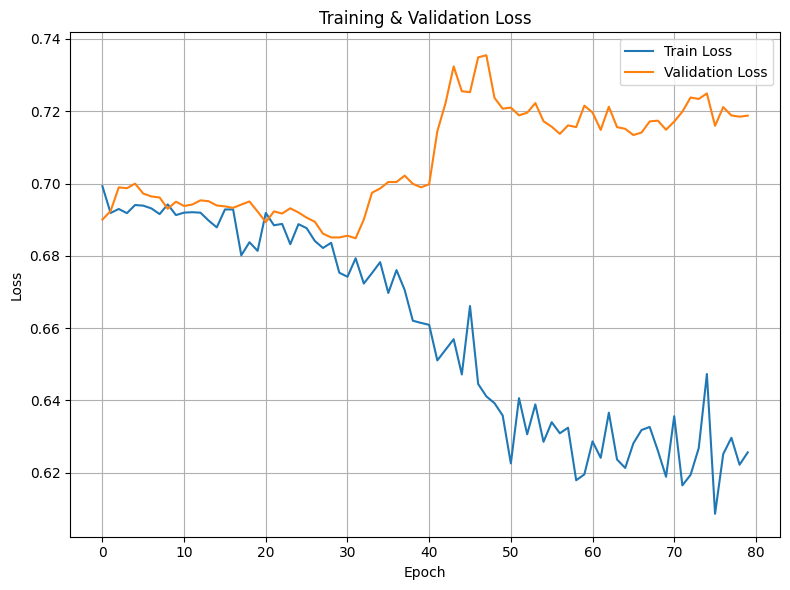


 Final Validation Metrics:
Accuracy : 0.5000
Precision: 0.5000
Recall   : 0.4833
F1 Score : 0.4915
AUC      : 0.5050
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 49.35it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 46.67it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:58,  4.54s/epoch]

Epoch 1/80 | Train Loss: 0.6907 | Val Loss: 0.6915


Training Progress:   2%|▎         | 2/80 [00:08<05:35,  4.30s/epoch]

Epoch 2/80 | Train Loss: 0.6953 | Val Loss: 0.6929


Training Progress:   4%|▍         | 3/80 [00:13<05:36,  4.37s/epoch]

Epoch 3/80 | Train Loss: 0.6958 | Val Loss: 0.6928


Training Progress:   5%|▌         | 4/80 [00:17<05:38,  4.45s/epoch]

Epoch 4/80 | Train Loss: 0.6888 | Val Loss: 0.6913


Training Progress:   6%|▋         | 5/80 [00:21<05:27,  4.37s/epoch]

Epoch 5/80 | Train Loss: 0.6987 | Val Loss: 0.6930


Training Progress:   8%|▊         | 6/80 [00:26<05:30,  4.46s/epoch]

Epoch 6/80 | Train Loss: 0.6949 | Val Loss: 0.6944


Training Progress:   9%|▉         | 7/80 [00:31<05:27,  4.49s/epoch]

Epoch 7/80 | Train Loss: 0.6905 | Val Loss: 0.6951


Training Progress:  10%|█         | 8/80 [00:35<05:16,  4.40s/epoch]

Epoch 8/80 | Train Loss: 0.6918 | Val Loss: 0.6956


Training Progress:  11%|█▏        | 9/80 [00:39<05:18,  4.48s/epoch]

Epoch 9/80 | Train Loss: 0.6918 | Val Loss: 0.6964


Training Progress:  12%|█▎        | 10/80 [00:44<05:11,  4.46s/epoch]

Epoch 10/80 | Train Loss: 0.6904 | Val Loss: 0.6965


Training Progress:  14%|█▍        | 11/80 [00:48<05:01,  4.36s/epoch]

Epoch 11/80 | Train Loss: 0.6928 | Val Loss: 0.6955


Training Progress:  15%|█▌        | 12/80 [00:53<05:02,  4.44s/epoch]

Epoch 12/80 | Train Loss: 0.6917 | Val Loss: 0.6951


Training Progress:  16%|█▋        | 13/80 [00:57<04:56,  4.43s/epoch]

Epoch 13/80 | Train Loss: 0.6909 | Val Loss: 0.6935


Training Progress:  18%|█▊        | 14/80 [01:01<04:45,  4.33s/epoch]

Epoch 14/80 | Train Loss: 0.6885 | Val Loss: 0.6928


Training Progress:  19%|█▉        | 15/80 [01:06<04:45,  4.39s/epoch]

Epoch 15/80 | Train Loss: 0.6930 | Val Loss: 0.6923


Training Progress:  20%|██        | 16/80 [01:10<04:40,  4.39s/epoch]

Epoch 16/80 | Train Loss: 0.6941 | Val Loss: 0.6912


Training Progress:  21%|██▏       | 17/80 [01:14<04:30,  4.30s/epoch]

Epoch 17/80 | Train Loss: 0.6913 | Val Loss: 0.6907


Training Progress:  22%|██▎       | 18/80 [01:19<04:31,  4.37s/epoch]

Epoch 18/80 | Train Loss: 0.6923 | Val Loss: 0.6899


Training Progress:  24%|██▍       | 19/80 [01:23<04:27,  4.39s/epoch]

Epoch 19/80 | Train Loss: 0.6875 | Val Loss: 0.6905


Training Progress:  25%|██▌       | 20/80 [01:27<04:18,  4.30s/epoch]

Epoch 20/80 | Train Loss: 0.6893 | Val Loss: 0.6907


Training Progress:  26%|██▋       | 21/80 [01:32<04:18,  4.39s/epoch]

Epoch 21/80 | Train Loss: 0.6918 | Val Loss: 0.6905


Training Progress:  28%|██▊       | 22/80 [01:36<04:16,  4.42s/epoch]

Epoch 22/80 | Train Loss: 0.6878 | Val Loss: 0.6910


Training Progress:  29%|██▉       | 23/80 [01:40<04:07,  4.34s/epoch]

Epoch 23/80 | Train Loss: 0.6864 | Val Loss: 0.6912


Training Progress:  30%|███       | 24/80 [01:45<04:07,  4.43s/epoch]

Epoch 24/80 | Train Loss: 0.6882 | Val Loss: 0.6910


Training Progress:  31%|███▏      | 25/80 [01:50<04:03,  4.43s/epoch]

Epoch 25/80 | Train Loss: 0.6883 | Val Loss: 0.6908


Training Progress:  32%|███▎      | 26/80 [01:54<03:54,  4.34s/epoch]

Epoch 26/80 | Train Loss: 0.6862 | Val Loss: 0.6899


Training Progress:  34%|███▍      | 27/80 [01:58<03:54,  4.42s/epoch]

Epoch 27/80 | Train Loss: 0.6892 | Val Loss: 0.6876


Training Progress:  35%|███▌      | 28/80 [02:03<03:50,  4.43s/epoch]

Epoch 28/80 | Train Loss: 0.6877 | Val Loss: 0.6881


Training Progress:  36%|███▋      | 29/80 [02:07<03:41,  4.34s/epoch]

Epoch 29/80 | Train Loss: 0.6837 | Val Loss: 0.6910


Training Progress:  38%|███▊      | 30/80 [02:11<03:41,  4.42s/epoch]

Epoch 30/80 | Train Loss: 0.6900 | Val Loss: 0.6900


Training Progress:  39%|███▉      | 31/80 [02:16<03:36,  4.42s/epoch]

Epoch 31/80 | Train Loss: 0.6838 | Val Loss: 0.6915


Training Progress:  40%|████      | 32/80 [02:20<03:28,  4.34s/epoch]

Epoch 32/80 | Train Loss: 0.6888 | Val Loss: 0.6896


Training Progress:  41%|████▏     | 33/80 [02:25<03:28,  4.44s/epoch]

Epoch 33/80 | Train Loss: 0.6837 | Val Loss: 0.6898


Training Progress:  42%|████▎     | 34/80 [02:29<03:23,  4.43s/epoch]

Epoch 34/80 | Train Loss: 0.6783 | Val Loss: 0.6870


Training Progress:  44%|████▍     | 35/80 [02:33<03:15,  4.35s/epoch]

Epoch 35/80 | Train Loss: 0.6821 | Val Loss: 0.6865


Training Progress:  45%|████▌     | 36/80 [02:38<03:15,  4.44s/epoch]

Epoch 36/80 | Train Loss: 0.6833 | Val Loss: 0.6873


Training Progress:  46%|████▋     | 37/80 [02:42<03:10,  4.42s/epoch]

Epoch 37/80 | Train Loss: 0.6786 | Val Loss: 0.6863


Training Progress:  48%|████▊     | 38/80 [02:46<03:01,  4.33s/epoch]

Epoch 38/80 | Train Loss: 0.6777 | Val Loss: 0.6860


Training Progress:  49%|████▉     | 39/80 [02:51<03:01,  4.43s/epoch]

Epoch 39/80 | Train Loss: 0.6844 | Val Loss: 0.6842


Training Progress:  50%|█████     | 40/80 [02:55<02:56,  4.42s/epoch]

Epoch 40/80 | Train Loss: 0.6809 | Val Loss: 0.6837


Training Progress:  51%|█████▏    | 41/80 [03:00<02:49,  4.35s/epoch]

Epoch 41/80 | Train Loss: 0.6865 | Val Loss: 0.6856


Training Progress:  52%|█████▎    | 42/80 [03:04<02:49,  4.47s/epoch]

Epoch 42/80 | Train Loss: 0.6800 | Val Loss: 0.6844


Training Progress:  54%|█████▍    | 43/80 [03:09<02:43,  4.42s/epoch]

Epoch 43/80 | Train Loss: 0.6757 | Val Loss: 0.6837


Training Progress:  55%|█████▌    | 44/80 [03:13<02:35,  4.33s/epoch]

Epoch 44/80 | Train Loss: 0.6792 | Val Loss: 0.6833


Training Progress:  56%|█████▋    | 45/80 [03:18<02:35,  4.45s/epoch]

Epoch 45/80 | Train Loss: 0.6771 | Val Loss: 0.6837


Training Progress:  57%|█████▊    | 46/80 [03:22<02:30,  4.43s/epoch]

Epoch 46/80 | Train Loss: 0.6723 | Val Loss: 0.6858


Training Progress:  59%|█████▉    | 47/80 [03:26<02:23,  4.34s/epoch]

Epoch 47/80 | Train Loss: 0.6664 | Val Loss: 0.6838


Training Progress:  60%|██████    | 48/80 [03:31<02:22,  4.45s/epoch]

Epoch 48/80 | Train Loss: 0.6704 | Val Loss: 0.6834


Training Progress:  61%|██████▏   | 49/80 [03:35<02:17,  4.42s/epoch]

Epoch 49/80 | Train Loss: 0.6765 | Val Loss: 0.6862


Training Progress:  62%|██████▎   | 50/80 [03:39<02:10,  4.34s/epoch]

Epoch 50/80 | Train Loss: 0.6681 | Val Loss: 0.6846


Training Progress:  64%|██████▍   | 51/80 [03:44<02:08,  4.45s/epoch]

Epoch 51/80 | Train Loss: 0.6623 | Val Loss: 0.6834


Training Progress:  65%|██████▌   | 52/80 [03:48<02:02,  4.38s/epoch]

Epoch 52/80 | Train Loss: 0.6638 | Val Loss: 0.6827


Training Progress:  66%|██████▋   | 53/80 [03:52<01:56,  4.30s/epoch]

Epoch 53/80 | Train Loss: 0.6630 | Val Loss: 0.6840


Training Progress:  68%|██████▊   | 54/80 [03:57<01:54,  4.41s/epoch]

Epoch 54/80 | Train Loss: 0.6596 | Val Loss: 0.6832


Training Progress:  69%|██████▉   | 55/80 [04:01<01:49,  4.37s/epoch]

Epoch 55/80 | Train Loss: 0.6610 | Val Loss: 0.6828


Training Progress:  70%|███████   | 56/80 [04:05<01:43,  4.29s/epoch]

Epoch 56/80 | Train Loss: 0.6581 | Val Loss: 0.6816


Training Progress:  71%|███████▏  | 57/80 [04:10<01:41,  4.41s/epoch]

Epoch 57/80 | Train Loss: 0.6688 | Val Loss: 0.6814


Training Progress:  72%|███████▎  | 58/80 [04:14<01:36,  4.37s/epoch]

Epoch 58/80 | Train Loss: 0.6591 | Val Loss: 0.6816


Training Progress:  74%|███████▍  | 59/80 [04:18<01:30,  4.30s/epoch]

Epoch 59/80 | Train Loss: 0.6688 | Val Loss: 0.6815


Training Progress:  75%|███████▌  | 60/80 [04:23<01:28,  4.41s/epoch]

Epoch 60/80 | Train Loss: 0.6612 | Val Loss: 0.6825


Training Progress:  76%|███████▋  | 61/80 [04:27<01:23,  4.38s/epoch]

Epoch 61/80 | Train Loss: 0.6612 | Val Loss: 0.6831


Training Progress:  78%|███████▊  | 62/80 [04:32<01:17,  4.30s/epoch]

Epoch 62/80 | Train Loss: 0.6572 | Val Loss: 0.6836


Training Progress:  79%|███████▉  | 63/80 [04:36<01:15,  4.43s/epoch]

Epoch 63/80 | Train Loss: 0.6624 | Val Loss: 0.6821


Training Progress:  80%|████████  | 64/80 [04:41<01:10,  4.40s/epoch]

Epoch 64/80 | Train Loss: 0.6680 | Val Loss: 0.6825


Training Progress:  81%|████████▏ | 65/80 [04:45<01:05,  4.34s/epoch]

Epoch 65/80 | Train Loss: 0.6613 | Val Loss: 0.6830


Training Progress:  82%|████████▎ | 66/80 [04:50<01:02,  4.47s/epoch]

Epoch 66/80 | Train Loss: 0.6650 | Val Loss: 0.6815


Training Progress:  84%|████████▍ | 67/80 [04:54<00:57,  4.40s/epoch]

Epoch 67/80 | Train Loss: 0.6616 | Val Loss: 0.6806


Training Progress:  85%|████████▌ | 68/80 [04:58<00:51,  4.31s/epoch]

Epoch 68/80 | Train Loss: 0.6530 | Val Loss: 0.6805


Training Progress:  86%|████████▋ | 69/80 [05:03<00:48,  4.44s/epoch]

Epoch 69/80 | Train Loss: 0.6588 | Val Loss: 0.6796


Training Progress:  88%|████████▊ | 70/80 [05:07<00:43,  4.39s/epoch]

Epoch 70/80 | Train Loss: 0.6553 | Val Loss: 0.6815


Training Progress:  89%|████████▉ | 71/80 [05:11<00:38,  4.30s/epoch]

Epoch 71/80 | Train Loss: 0.6590 | Val Loss: 0.6817


Training Progress:  90%|█████████ | 72/80 [05:16<00:35,  4.44s/epoch]

Epoch 72/80 | Train Loss: 0.6555 | Val Loss: 0.6838


Training Progress:  91%|█████████▏| 73/80 [05:20<00:30,  4.38s/epoch]

Epoch 73/80 | Train Loss: 0.6515 | Val Loss: 0.6816


Training Progress:  92%|█████████▎| 74/80 [05:24<00:25,  4.31s/epoch]

Epoch 74/80 | Train Loss: 0.6516 | Val Loss: 0.6826


Training Progress:  94%|█████████▍| 75/80 [05:29<00:22,  4.44s/epoch]

Epoch 75/80 | Train Loss: 0.6655 | Val Loss: 0.6812


Training Progress:  95%|█████████▌| 76/80 [05:33<00:17,  4.39s/epoch]

Epoch 76/80 | Train Loss: 0.6568 | Val Loss: 0.6805


Training Progress:  96%|█████████▋| 77/80 [05:37<00:12,  4.31s/epoch]

Epoch 77/80 | Train Loss: 0.6618 | Val Loss: 0.6802


Training Progress:  98%|█████████▊| 78/80 [05:42<00:08,  4.46s/epoch]

Epoch 78/80 | Train Loss: 0.6565 | Val Loss: 0.6799


Training Progress:  99%|█████████▉| 79/80 [05:46<00:04,  4.40s/epoch]

Epoch 79/80 | Train Loss: 0.6543 | Val Loss: 0.6784


Training Progress: 100%|██████████| 80/80 [05:51<00:00,  4.39s/epoch]

Epoch 80/80 | Train Loss: 0.6679 | Val Loss: 0.6807


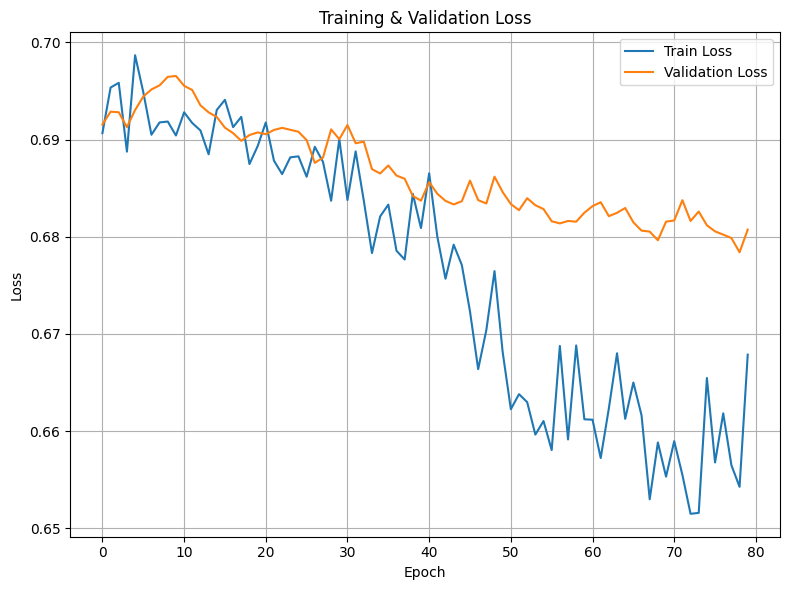


 Final Validation Metrics:
Accuracy : 0.5333
Precision: 0.5185
Recall   : 0.9333
F1 Score : 0.6667
AUC      : 0.5625
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 40.66it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 49.17it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:49,  4.43s/epoch]

Epoch 1/80 | Train Loss: 0.6964 | Val Loss: 0.6992


Training Progress:   2%|▎         | 2/80 [00:09<05:53,  4.53s/epoch]

Epoch 2/80 | Train Loss: 0.6953 | Val Loss: 0.6969


Training Progress:   4%|▍         | 3/80 [00:13<05:35,  4.36s/epoch]

Epoch 3/80 | Train Loss: 0.6926 | Val Loss: 0.6967


Training Progress:   5%|▌         | 4/80 [00:17<05:31,  4.36s/epoch]

Epoch 4/80 | Train Loss: 0.6966 | Val Loss: 0.6974


Training Progress:   6%|▋         | 5/80 [00:22<05:35,  4.47s/epoch]

Epoch 5/80 | Train Loss: 0.6900 | Val Loss: 0.6971


Training Progress:   8%|▊         | 6/80 [00:26<05:23,  4.37s/epoch]

Epoch 6/80 | Train Loss: 0.6920 | Val Loss: 0.6975


Training Progress:   9%|▉         | 7/80 [00:30<05:20,  4.39s/epoch]

Epoch 7/80 | Train Loss: 0.6935 | Val Loss: 0.6931


Training Progress:  10%|█         | 8/80 [00:35<05:22,  4.48s/epoch]

Epoch 8/80 | Train Loss: 0.6901 | Val Loss: 0.6927


Training Progress:  11%|█▏        | 9/80 [00:39<05:11,  4.39s/epoch]

Epoch 9/80 | Train Loss: 0.6958 | Val Loss: 0.6932


Training Progress:  12%|█▎        | 10/80 [00:44<05:08,  4.40s/epoch]

Epoch 10/80 | Train Loss: 0.6911 | Val Loss: 0.6948


Training Progress:  14%|█▍        | 11/80 [00:48<05:09,  4.48s/epoch]

Epoch 11/80 | Train Loss: 0.6890 | Val Loss: 0.6930


Training Progress:  15%|█▌        | 12/80 [00:52<04:57,  4.38s/epoch]

Epoch 12/80 | Train Loss: 0.6898 | Val Loss: 0.6923


Training Progress:  16%|█▋        | 13/80 [00:57<04:54,  4.39s/epoch]

Epoch 13/80 | Train Loss: 0.6861 | Val Loss: 0.6929


Training Progress:  18%|█▊        | 14/80 [01:01<04:52,  4.43s/epoch]

Epoch 14/80 | Train Loss: 0.6856 | Val Loss: 0.6916


Training Progress:  19%|█▉        | 15/80 [01:05<04:41,  4.33s/epoch]

Epoch 15/80 | Train Loss: 0.6852 | Val Loss: 0.6915


Training Progress:  20%|██        | 16/80 [01:10<04:38,  4.35s/epoch]

Epoch 16/80 | Train Loss: 0.6857 | Val Loss: 0.6914


Training Progress:  21%|██▏       | 17/80 [01:14<04:37,  4.40s/epoch]

Epoch 17/80 | Train Loss: 0.6822 | Val Loss: 0.6932


Training Progress:  22%|██▎       | 18/80 [01:18<04:27,  4.32s/epoch]

Epoch 18/80 | Train Loss: 0.6806 | Val Loss: 0.6918


Training Progress:  24%|██▍       | 19/80 [01:23<04:23,  4.31s/epoch]

Epoch 19/80 | Train Loss: 0.6811 | Val Loss: 0.6899


Training Progress:  25%|██▌       | 20/80 [01:27<04:24,  4.40s/epoch]

Epoch 20/80 | Train Loss: 0.6813 | Val Loss: 0.6891


Training Progress:  26%|██▋       | 21/80 [01:32<04:15,  4.33s/epoch]

Epoch 21/80 | Train Loss: 0.6810 | Val Loss: 0.6885


Training Progress:  28%|██▊       | 22/80 [01:36<04:11,  4.34s/epoch]

Epoch 22/80 | Train Loss: 0.6755 | Val Loss: 0.6920


Training Progress:  29%|██▉       | 23/80 [01:41<04:12,  4.43s/epoch]

Epoch 23/80 | Train Loss: 0.6830 | Val Loss: 0.6935


Training Progress:  30%|███       | 24/80 [01:45<04:03,  4.35s/epoch]

Epoch 24/80 | Train Loss: 0.6771 | Val Loss: 0.6933


Training Progress:  31%|███▏      | 25/80 [01:49<04:00,  4.37s/epoch]

Epoch 25/80 | Train Loss: 0.6769 | Val Loss: 0.6935


Training Progress:  32%|███▎      | 26/80 [01:54<03:59,  4.44s/epoch]

Epoch 26/80 | Train Loss: 0.6763 | Val Loss: 0.6919


Training Progress:  34%|███▍      | 27/80 [01:58<03:50,  4.36s/epoch]

Epoch 27/80 | Train Loss: 0.6753 | Val Loss: 0.6934


Training Progress:  35%|███▌      | 28/80 [02:02<03:47,  4.37s/epoch]

Epoch 28/80 | Train Loss: 0.6590 | Val Loss: 0.6951


Training Progress:  36%|███▋      | 29/80 [02:07<03:46,  4.44s/epoch]

Epoch 29/80 | Train Loss: 0.6586 | Val Loss: 0.7026


Training Progress:  38%|███▊      | 30/80 [02:11<03:37,  4.35s/epoch]

Epoch 30/80 | Train Loss: 0.6582 | Val Loss: 0.7057


Training Progress:  39%|███▉      | 31/80 [02:15<03:33,  4.36s/epoch]

Epoch 31/80 | Train Loss: 0.6667 | Val Loss: 0.6991


Training Progress:  40%|████      | 32/80 [02:20<03:32,  4.43s/epoch]

Epoch 32/80 | Train Loss: 0.6526 | Val Loss: 0.7034


Training Progress:  41%|████▏     | 33/80 [02:24<03:23,  4.33s/epoch]

Epoch 33/80 | Train Loss: 0.6454 | Val Loss: 0.7030


Training Progress:  42%|████▎     | 34/80 [02:28<03:19,  4.34s/epoch]

Epoch 34/80 | Train Loss: 0.6500 | Val Loss: 0.7012


Training Progress:  44%|████▍     | 35/80 [02:33<03:19,  4.43s/epoch]

Epoch 35/80 | Train Loss: 0.6410 | Val Loss: 0.7099


Training Progress:  45%|████▌     | 36/80 [02:37<03:11,  4.35s/epoch]

Epoch 36/80 | Train Loss: 0.6279 | Val Loss: 0.7042


Training Progress:  46%|████▋     | 37/80 [02:42<03:08,  4.37s/epoch]

Epoch 37/80 | Train Loss: 0.6243 | Val Loss: 0.6980


Training Progress:  48%|████▊     | 38/80 [02:46<03:06,  4.44s/epoch]

Epoch 38/80 | Train Loss: 0.6332 | Val Loss: 0.6937


Training Progress:  49%|████▉     | 39/80 [02:50<02:58,  4.35s/epoch]

Epoch 39/80 | Train Loss: 0.6061 | Val Loss: 0.6955


Training Progress:  50%|█████     | 40/80 [02:55<02:53,  4.34s/epoch]

Epoch 40/80 | Train Loss: 0.6147 | Val Loss: 0.6924


Training Progress:  51%|█████▏    | 41/80 [02:59<02:52,  4.43s/epoch]

Epoch 41/80 | Train Loss: 0.6086 | Val Loss: 0.6951


Training Progress:  52%|█████▎    | 42/80 [03:04<02:45,  4.34s/epoch]

Epoch 42/80 | Train Loss: 0.6159 | Val Loss: 0.6942


Training Progress:  54%|█████▍    | 43/80 [03:08<02:40,  4.34s/epoch]

Epoch 43/80 | Train Loss: 0.6113 | Val Loss: 0.6946


Training Progress:  55%|█████▌    | 44/80 [03:13<02:39,  4.43s/epoch]

Epoch 44/80 | Train Loss: 0.5883 | Val Loss: 0.6939


Training Progress:  56%|█████▋    | 45/80 [03:17<02:32,  4.34s/epoch]

Epoch 45/80 | Train Loss: 0.5886 | Val Loss: 0.6891


Training Progress:  57%|█████▊    | 46/80 [03:21<02:27,  4.35s/epoch]

Epoch 46/80 | Train Loss: 0.5731 | Val Loss: 0.6844


Training Progress:  59%|█████▉    | 47/80 [03:26<02:26,  4.44s/epoch]

Epoch 47/80 | Train Loss: 0.5627 | Val Loss: 0.6738


Training Progress:  60%|██████    | 48/80 [03:30<02:19,  4.37s/epoch]

Epoch 48/80 | Train Loss: 0.5771 | Val Loss: 0.7003


Training Progress:  61%|██████▏   | 49/80 [03:34<02:16,  4.39s/epoch]

Epoch 49/80 | Train Loss: 0.5391 | Val Loss: 0.7185


Training Progress:  62%|██████▎   | 50/80 [03:39<02:13,  4.46s/epoch]

Epoch 50/80 | Train Loss: 0.5447 | Val Loss: 0.7085


Training Progress:  64%|██████▍   | 51/80 [03:43<02:06,  4.37s/epoch]

Epoch 51/80 | Train Loss: 0.5169 | Val Loss: 0.7138


Training Progress:  65%|██████▌   | 52/80 [03:48<02:02,  4.39s/epoch]

Epoch 52/80 | Train Loss: 0.5292 | Val Loss: 0.7067


Training Progress:  66%|██████▋   | 53/80 [03:52<02:00,  4.45s/epoch]

Epoch 53/80 | Train Loss: 0.5408 | Val Loss: 0.6955


Training Progress:  68%|██████▊   | 54/80 [03:56<01:53,  4.36s/epoch]

Epoch 54/80 | Train Loss: 0.5091 | Val Loss: 0.6913


Training Progress:  69%|██████▉   | 55/80 [04:01<01:49,  4.38s/epoch]

Epoch 55/80 | Train Loss: 0.5227 | Val Loss: 0.6881


Training Progress:  70%|███████   | 56/80 [04:05<01:46,  4.45s/epoch]

Epoch 56/80 | Train Loss: 0.5028 | Val Loss: 0.6895


Training Progress:  71%|███████▏  | 57/80 [04:10<01:40,  4.37s/epoch]

Epoch 57/80 | Train Loss: 0.5264 | Val Loss: 0.6910


Training Progress:  72%|███████▎  | 58/80 [04:14<01:36,  4.39s/epoch]

Epoch 58/80 | Train Loss: 0.5222 | Val Loss: 0.6850


Training Progress:  74%|███████▍  | 59/80 [04:18<01:33,  4.44s/epoch]

Epoch 59/80 | Train Loss: 0.5331 | Val Loss: 0.6835


Training Progress:  75%|███████▌  | 60/80 [04:23<01:26,  4.34s/epoch]

Epoch 60/80 | Train Loss: 0.5169 | Val Loss: 0.6808


Training Progress:  76%|███████▋  | 61/80 [04:27<01:23,  4.37s/epoch]

Epoch 61/80 | Train Loss: 0.5272 | Val Loss: 0.6846


Training Progress:  78%|███████▊  | 62/80 [04:32<01:19,  4.43s/epoch]

Epoch 62/80 | Train Loss: 0.5133 | Val Loss: 0.6842


Training Progress:  79%|███████▉  | 63/80 [04:36<01:13,  4.34s/epoch]

Epoch 63/80 | Train Loss: 0.5058 | Val Loss: 0.6840


Training Progress:  80%|████████  | 64/80 [04:40<01:09,  4.36s/epoch]

Epoch 64/80 | Train Loss: 0.5204 | Val Loss: 0.6872


Training Progress:  81%|████████▏ | 65/80 [04:45<01:06,  4.44s/epoch]

Epoch 65/80 | Train Loss: 0.5031 | Val Loss: 0.6842


Training Progress:  82%|████████▎ | 66/80 [04:49<01:01,  4.36s/epoch]

Epoch 66/80 | Train Loss: 0.5278 | Val Loss: 0.6805


Training Progress:  84%|████████▍ | 67/80 [04:53<00:56,  4.38s/epoch]

Epoch 67/80 | Train Loss: 0.4980 | Val Loss: 0.6811


Training Progress:  85%|████████▌ | 68/80 [04:58<00:53,  4.44s/epoch]

Epoch 68/80 | Train Loss: 0.5041 | Val Loss: 0.6737


Training Progress:  86%|████████▋ | 69/80 [05:02<00:47,  4.36s/epoch]

Epoch 69/80 | Train Loss: 0.4973 | Val Loss: 0.6766


Training Progress:  88%|████████▊ | 70/80 [05:07<00:43,  4.40s/epoch]

Epoch 70/80 | Train Loss: 0.4940 | Val Loss: 0.6795


Training Progress:  89%|████████▉ | 71/80 [05:11<00:40,  4.44s/epoch]

Epoch 71/80 | Train Loss: 0.5094 | Val Loss: 0.6784


Training Progress:  90%|█████████ | 72/80 [05:15<00:34,  4.35s/epoch]

Epoch 72/80 | Train Loss: 0.4917 | Val Loss: 0.6807


Training Progress:  91%|█████████▏| 73/80 [05:20<00:30,  4.39s/epoch]

Epoch 73/80 | Train Loss: 0.5001 | Val Loss: 0.6819


Training Progress:  92%|█████████▎| 74/80 [05:24<00:26,  4.44s/epoch]

Epoch 74/80 | Train Loss: 0.4855 | Val Loss: 0.6885


Training Progress:  94%|█████████▍| 75/80 [05:28<00:21,  4.34s/epoch]

Epoch 75/80 | Train Loss: 0.4948 | Val Loss: 0.6926


Training Progress:  95%|█████████▌| 76/80 [05:33<00:17,  4.36s/epoch]

Epoch 76/80 | Train Loss: 0.4944 | Val Loss: 0.6861


Training Progress:  96%|█████████▋| 77/80 [05:37<00:13,  4.42s/epoch]

Epoch 77/80 | Train Loss: 0.4811 | Val Loss: 0.6819


Training Progress:  98%|█████████▊| 78/80 [05:42<00:08,  4.35s/epoch]

Epoch 78/80 | Train Loss: 0.4971 | Val Loss: 0.6841


Training Progress:  99%|█████████▉| 79/80 [05:46<00:04,  4.38s/epoch]

Epoch 79/80 | Train Loss: 0.4739 | Val Loss: 0.6846


Training Progress: 100%|██████████| 80/80 [05:51<00:00,  4.39s/epoch]

Epoch 80/80 | Train Loss: 0.4884 | Val Loss: 0.6840


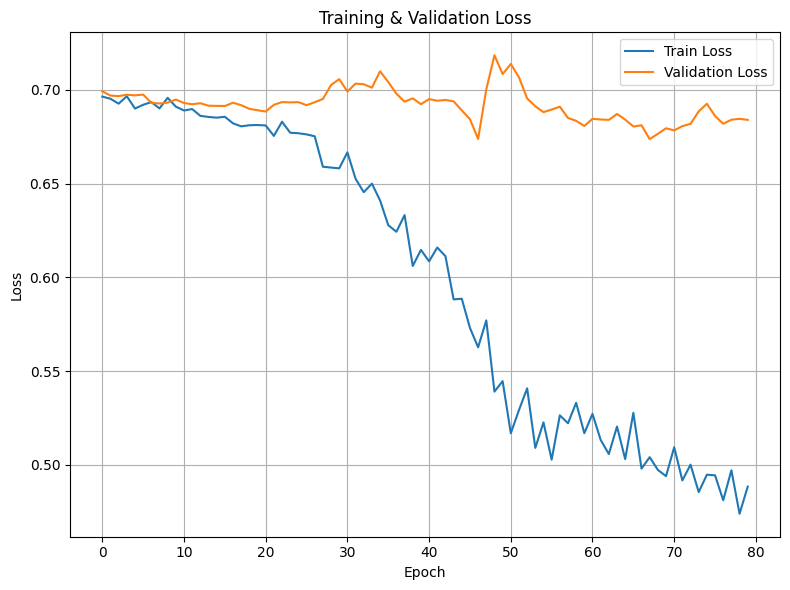


 Final Validation Metrics:
Accuracy : 0.5500
Precision: 0.5375
Recall   : 0.7167
F1 Score : 0.6143
AUC      : 0.6314
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 49.30it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:03<00:00, 33.48it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:26,  4.13s/epoch]

Epoch 1/80 | Train Loss: 0.6941 | Val Loss: 0.6967


Training Progress:   2%|▎         | 2/80 [00:08<05:22,  4.13s/epoch]

Epoch 2/80 | Train Loss: 0.6920 | Val Loss: 0.6945


Training Progress:   4%|▍         | 3/80 [00:13<05:39,  4.41s/epoch]

Epoch 3/80 | Train Loss: 0.6890 | Val Loss: 0.6928


Training Progress:   5%|▌         | 4/80 [00:17<05:28,  4.32s/epoch]

Epoch 4/80 | Train Loss: 0.6976 | Val Loss: 0.6927


Training Progress:   6%|▋         | 5/80 [00:21<05:20,  4.27s/epoch]

Epoch 5/80 | Train Loss: 0.6914 | Val Loss: 0.6942


Training Progress:   8%|▊         | 6/80 [00:26<05:28,  4.43s/epoch]

Epoch 6/80 | Train Loss: 0.6918 | Val Loss: 0.6949


Training Progress:   9%|▉         | 7/80 [00:30<05:19,  4.37s/epoch]

Epoch 7/80 | Train Loss: 0.6890 | Val Loss: 0.6924


Training Progress:  10%|█         | 8/80 [00:34<05:09,  4.30s/epoch]

Epoch 8/80 | Train Loss: 0.6911 | Val Loss: 0.6908


Training Progress:  11%|█▏        | 9/80 [00:39<05:15,  4.44s/epoch]

Epoch 9/80 | Train Loss: 0.6928 | Val Loss: 0.6940


Training Progress:  12%|█▎        | 10/80 [00:43<05:04,  4.35s/epoch]

Epoch 10/80 | Train Loss: 0.6921 | Val Loss: 0.6937


Training Progress:  14%|█▍        | 11/80 [00:47<04:54,  4.27s/epoch]

Epoch 11/80 | Train Loss: 0.6895 | Val Loss: 0.6926


Training Progress:  15%|█▌        | 12/80 [00:52<05:00,  4.42s/epoch]

Epoch 12/80 | Train Loss: 0.6850 | Val Loss: 0.6925


Training Progress:  16%|█▋        | 13/80 [00:56<04:50,  4.33s/epoch]

Epoch 13/80 | Train Loss: 0.6888 | Val Loss: 0.6938


Training Progress:  18%|█▊        | 14/80 [01:00<04:51,  4.42s/epoch]

Epoch 14/80 | Train Loss: 0.6850 | Val Loss: 0.6900


Training Progress:  19%|█▉        | 15/80 [01:07<05:36,  5.18s/epoch]

Epoch 15/80 | Train Loss: 0.6894 | Val Loss: 0.6861


Training Progress:  20%|██        | 16/80 [01:12<05:13,  4.89s/epoch]

Epoch 16/80 | Train Loss: 0.6836 | Val Loss: 0.6856


Training Progress:  21%|██▏       | 17/80 [01:16<05:02,  4.80s/epoch]

Epoch 17/80 | Train Loss: 0.6861 | Val Loss: 0.6856


Training Progress:  22%|██▎       | 18/80 [01:21<04:50,  4.69s/epoch]

Epoch 18/80 | Train Loss: 0.6824 | Val Loss: 0.6868


Training Progress:  24%|██▍       | 19/80 [01:25<04:35,  4.52s/epoch]

Epoch 19/80 | Train Loss: 0.6815 | Val Loss: 0.6850


Training Progress:  25%|██▌       | 20/80 [01:29<04:32,  4.54s/epoch]

Epoch 20/80 | Train Loss: 0.6832 | Val Loss: 0.6865


Training Progress:  26%|██▋       | 21/80 [01:34<04:26,  4.53s/epoch]

Epoch 21/80 | Train Loss: 0.6792 | Val Loss: 0.6866


Training Progress:  28%|██▊       | 22/80 [01:38<04:16,  4.42s/epoch]

Epoch 22/80 | Train Loss: 0.6815 | Val Loss: 0.6881


Training Progress:  29%|██▉       | 23/80 [01:43<04:15,  4.48s/epoch]

Epoch 23/80 | Train Loss: 0.6741 | Val Loss: 0.6853


Training Progress:  30%|███       | 24/80 [01:47<04:10,  4.48s/epoch]

Epoch 24/80 | Train Loss: 0.6713 | Val Loss: 0.6833


Training Progress:  31%|███▏      | 25/80 [01:51<04:01,  4.38s/epoch]

Epoch 25/80 | Train Loss: 0.6788 | Val Loss: 0.6852


Training Progress:  32%|███▎      | 26/80 [01:56<04:00,  4.46s/epoch]

Epoch 26/80 | Train Loss: 0.6742 | Val Loss: 0.6869


Training Progress:  34%|███▍      | 27/80 [02:00<03:56,  4.46s/epoch]

Epoch 27/80 | Train Loss: 0.6695 | Val Loss: 0.6835


Training Progress:  35%|███▌      | 28/80 [02:05<03:47,  4.37s/epoch]

Epoch 28/80 | Train Loss: 0.6687 | Val Loss: 0.6827


Training Progress:  36%|███▋      | 29/80 [02:09<03:46,  4.44s/epoch]

Epoch 29/80 | Train Loss: 0.6593 | Val Loss: 0.6864


Training Progress:  38%|███▊      | 30/80 [02:14<03:41,  4.42s/epoch]

Epoch 30/80 | Train Loss: 0.6690 | Val Loss: 0.6846


Training Progress:  39%|███▉      | 31/80 [02:18<03:32,  4.33s/epoch]

Epoch 31/80 | Train Loss: 0.6671 | Val Loss: 0.6870


Training Progress:  40%|████      | 32/80 [02:22<03:30,  4.39s/epoch]

Epoch 32/80 | Train Loss: 0.6454 | Val Loss: 0.6907


Training Progress:  41%|████▏     | 33/80 [02:27<03:26,  4.40s/epoch]

Epoch 33/80 | Train Loss: 0.6575 | Val Loss: 0.6873


Training Progress:  42%|████▎     | 34/80 [02:31<03:18,  4.33s/epoch]

Epoch 34/80 | Train Loss: 0.6544 | Val Loss: 0.6838


Training Progress:  44%|████▍     | 35/80 [02:35<03:18,  4.41s/epoch]

Epoch 35/80 | Train Loss: 0.6445 | Val Loss: 0.6832


Training Progress:  45%|████▌     | 36/80 [02:40<03:14,  4.41s/epoch]

Epoch 36/80 | Train Loss: 0.6352 | Val Loss: 0.6803


Training Progress:  46%|████▋     | 37/80 [02:44<03:05,  4.32s/epoch]

Epoch 37/80 | Train Loss: 0.6330 | Val Loss: 0.6815


Training Progress:  48%|████▊     | 38/80 [02:49<03:05,  4.41s/epoch]

Epoch 38/80 | Train Loss: 0.6155 | Val Loss: 0.6773


Training Progress:  49%|████▉     | 39/80 [02:53<03:01,  4.42s/epoch]

Epoch 39/80 | Train Loss: 0.6245 | Val Loss: 0.6748


Training Progress:  50%|█████     | 40/80 [02:57<02:53,  4.33s/epoch]

Epoch 40/80 | Train Loss: 0.6031 | Val Loss: 0.6701


Training Progress:  51%|█████▏    | 41/80 [03:02<02:52,  4.42s/epoch]

Epoch 41/80 | Train Loss: 0.5988 | Val Loss: 0.6657


Training Progress:  52%|█████▎    | 42/80 [03:06<02:48,  4.42s/epoch]

Epoch 42/80 | Train Loss: 0.5875 | Val Loss: 0.6625


Training Progress:  54%|█████▍    | 43/80 [03:10<02:40,  4.34s/epoch]

Epoch 43/80 | Train Loss: 0.5800 | Val Loss: 0.6604


Training Progress:  55%|█████▌    | 44/80 [03:15<02:39,  4.43s/epoch]

Epoch 44/80 | Train Loss: 0.5755 | Val Loss: 0.6700


Training Progress:  56%|█████▋    | 45/80 [03:19<02:35,  4.44s/epoch]

Epoch 45/80 | Train Loss: 0.5548 | Val Loss: 0.6605


Training Progress:  57%|█████▊    | 46/80 [03:24<02:27,  4.34s/epoch]

Epoch 46/80 | Train Loss: 0.5523 | Val Loss: 0.6432


Training Progress:  59%|█████▉    | 47/80 [03:28<02:25,  4.42s/epoch]

Epoch 47/80 | Train Loss: 0.5407 | Val Loss: 0.6467


Training Progress:  60%|██████    | 48/80 [03:33<02:21,  4.43s/epoch]

Epoch 48/80 | Train Loss: 0.5331 | Val Loss: 0.6449


Training Progress:  61%|██████▏   | 49/80 [03:37<02:14,  4.34s/epoch]

Epoch 49/80 | Train Loss: 0.5236 | Val Loss: 0.6588


Training Progress:  62%|██████▎   | 50/80 [03:41<02:12,  4.40s/epoch]

Epoch 50/80 | Train Loss: 0.5048 | Val Loss: 0.6731


Training Progress:  64%|██████▍   | 51/80 [03:46<02:07,  4.41s/epoch]

Epoch 51/80 | Train Loss: 0.4822 | Val Loss: 0.6476


Training Progress:  65%|██████▌   | 52/80 [03:50<02:00,  4.32s/epoch]

Epoch 52/80 | Train Loss: 0.4737 | Val Loss: 0.6243


Training Progress:  66%|██████▋   | 53/80 [03:54<01:58,  4.40s/epoch]

Epoch 53/80 | Train Loss: 0.4831 | Val Loss: 0.6152


Training Progress:  68%|██████▊   | 54/80 [03:59<01:54,  4.42s/epoch]

Epoch 54/80 | Train Loss: 0.4765 | Val Loss: 0.6045


Training Progress:  69%|██████▉   | 55/80 [04:03<01:48,  4.35s/epoch]

Epoch 55/80 | Train Loss: 0.4686 | Val Loss: 0.6048


Training Progress:  70%|███████   | 56/80 [04:08<01:46,  4.43s/epoch]

Epoch 56/80 | Train Loss: 0.4564 | Val Loss: 0.5996


Training Progress:  71%|███████▏  | 57/80 [04:12<01:41,  4.42s/epoch]

Epoch 57/80 | Train Loss: 0.4669 | Val Loss: 0.6002


Training Progress:  72%|███████▎  | 58/80 [04:16<01:35,  4.33s/epoch]

Epoch 58/80 | Train Loss: 0.4875 | Val Loss: 0.6022


Training Progress:  74%|███████▍  | 59/80 [04:21<01:32,  4.42s/epoch]

Epoch 59/80 | Train Loss: 0.4989 | Val Loss: 0.6023


Training Progress:  75%|███████▌  | 60/80 [04:25<01:28,  4.41s/epoch]

Epoch 60/80 | Train Loss: 0.4520 | Val Loss: 0.5998


Training Progress:  76%|███████▋  | 61/80 [04:29<01:22,  4.33s/epoch]

Epoch 61/80 | Train Loss: 0.4529 | Val Loss: 0.6019


Training Progress:  78%|███████▊  | 62/80 [04:34<01:19,  4.41s/epoch]

Epoch 62/80 | Train Loss: 0.4642 | Val Loss: 0.6009


Training Progress:  79%|███████▉  | 63/80 [04:38<01:14,  4.41s/epoch]

Epoch 63/80 | Train Loss: 0.4902 | Val Loss: 0.6042


Training Progress:  80%|████████  | 64/80 [04:42<01:09,  4.33s/epoch]

Epoch 64/80 | Train Loss: 0.4495 | Val Loss: 0.6061


Training Progress:  81%|████████▏ | 65/80 [04:47<01:05,  4.40s/epoch]

Epoch 65/80 | Train Loss: 0.4668 | Val Loss: 0.6029


Training Progress:  82%|████████▎ | 66/80 [04:51<01:01,  4.41s/epoch]

Epoch 66/80 | Train Loss: 0.4968 | Val Loss: 0.5990


Training Progress:  84%|████████▍ | 67/80 [04:56<00:56,  4.33s/epoch]

Epoch 67/80 | Train Loss: 0.4725 | Val Loss: 0.5955


Training Progress:  85%|████████▌ | 68/80 [05:00<00:52,  4.41s/epoch]

Epoch 68/80 | Train Loss: 0.4803 | Val Loss: 0.6016


Training Progress:  86%|████████▋ | 69/80 [05:05<00:48,  4.42s/epoch]

Epoch 69/80 | Train Loss: 0.4832 | Val Loss: 0.6063


Training Progress:  88%|████████▊ | 70/80 [05:09<00:43,  4.33s/epoch]

Epoch 70/80 | Train Loss: 0.4693 | Val Loss: 0.6035


Training Progress:  89%|████████▉ | 71/80 [05:13<00:39,  4.40s/epoch]

Epoch 71/80 | Train Loss: 0.4415 | Val Loss: 0.6050


Training Progress:  90%|█████████ | 72/80 [05:18<00:35,  4.41s/epoch]

Epoch 72/80 | Train Loss: 0.4346 | Val Loss: 0.6121


Training Progress:  91%|█████████▏| 73/80 [05:22<00:30,  4.33s/epoch]

Epoch 73/80 | Train Loss: 0.4370 | Val Loss: 0.6020


Training Progress:  92%|█████████▎| 74/80 [05:26<00:26,  4.40s/epoch]

Epoch 74/80 | Train Loss: 0.4828 | Val Loss: 0.6002


Training Progress:  94%|█████████▍| 75/80 [05:31<00:22,  4.42s/epoch]

Epoch 75/80 | Train Loss: 0.4909 | Val Loss: 0.6016


Training Progress:  95%|█████████▌| 76/80 [05:35<00:17,  4.35s/epoch]

Epoch 76/80 | Train Loss: 0.4242 | Val Loss: 0.6035


Training Progress:  96%|█████████▋| 77/80 [05:40<00:13,  4.43s/epoch]

Epoch 77/80 | Train Loss: 0.4497 | Val Loss: 0.6097


Training Progress:  98%|█████████▊| 78/80 [05:44<00:08,  4.43s/epoch]

Epoch 78/80 | Train Loss: 0.4410 | Val Loss: 0.6031


Training Progress:  99%|█████████▉| 79/80 [05:48<00:04,  4.34s/epoch]

Epoch 79/80 | Train Loss: 0.4502 | Val Loss: 0.5988


Training Progress: 100%|██████████| 80/80 [05:53<00:00,  4.42s/epoch]


Epoch 80/80 | Train Loss: 0.4628 | Val Loss: 0.5994


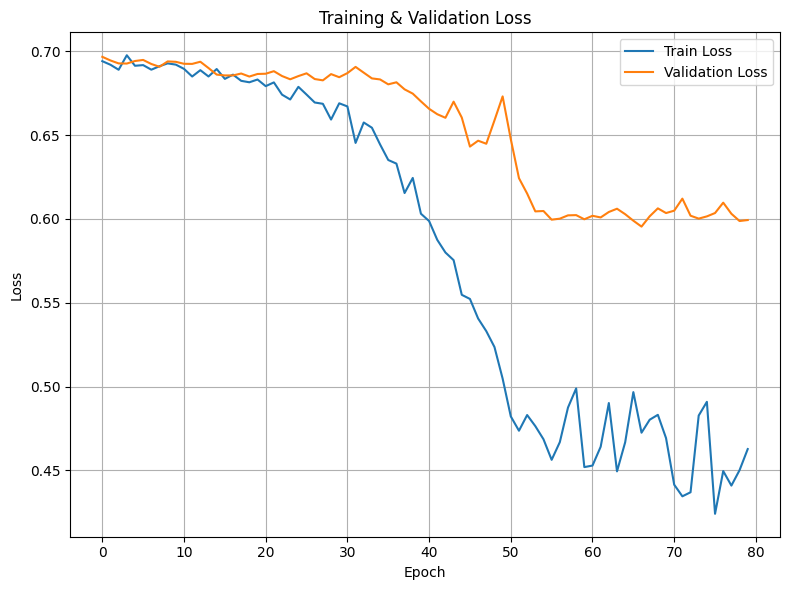


 Final Validation Metrics:
Accuracy : 0.7083
Precision: 0.7119
Recall   : 0.7000
F1 Score : 0.7059
AUC      : 0.7583
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 48.33it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 47.90it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<06:14,  4.74s/epoch]

Epoch 1/80 | Train Loss: 0.6971 | Val Loss: 0.6926


Training Progress:   2%|▎         | 2/80 [00:08<05:42,  4.39s/epoch]

Epoch 2/80 | Train Loss: 0.6957 | Val Loss: 0.6944


Training Progress:   4%|▍         | 3/80 [00:13<05:30,  4.29s/epoch]

Epoch 3/80 | Train Loss: 0.6943 | Val Loss: 0.6943


Training Progress:   5%|▌         | 4/80 [00:17<05:38,  4.46s/epoch]

Epoch 4/80 | Train Loss: 0.6968 | Val Loss: 0.6940


Training Progress:   6%|▋         | 5/80 [00:21<05:27,  4.36s/epoch]

Epoch 5/80 | Train Loss: 0.6931 | Val Loss: 0.6950


Training Progress:   8%|▊         | 6/80 [00:26<05:18,  4.31s/epoch]

Epoch 6/80 | Train Loss: 0.6913 | Val Loss: 0.6969


Training Progress:   9%|▉         | 7/80 [00:30<05:25,  4.46s/epoch]

Epoch 7/80 | Train Loss: 0.6945 | Val Loss: 0.6976


Training Progress:  10%|█         | 8/80 [00:35<05:14,  4.37s/epoch]

Epoch 8/80 | Train Loss: 0.6914 | Val Loss: 0.6918


Training Progress:  11%|█▏        | 9/80 [00:39<05:05,  4.30s/epoch]

Epoch 9/80 | Train Loss: 0.6914 | Val Loss: 0.6922


Training Progress:  12%|█▎        | 10/80 [00:43<05:09,  4.42s/epoch]

Epoch 10/80 | Train Loss: 0.6897 | Val Loss: 0.6898


Training Progress:  14%|█▍        | 11/80 [00:48<04:59,  4.34s/epoch]

Epoch 11/80 | Train Loss: 0.6897 | Val Loss: 0.6871


Training Progress:  15%|█▌        | 12/80 [00:52<04:50,  4.27s/epoch]

Epoch 12/80 | Train Loss: 0.6892 | Val Loss: 0.6885


Training Progress:  16%|█▋        | 13/80 [00:56<04:54,  4.40s/epoch]

Epoch 13/80 | Train Loss: 0.6887 | Val Loss: 0.6884


Training Progress:  18%|█▊        | 14/80 [01:01<04:45,  4.33s/epoch]

Epoch 14/80 | Train Loss: 0.6850 | Val Loss: 0.6854


Training Progress:  19%|█▉        | 15/80 [01:05<04:36,  4.26s/epoch]

Epoch 15/80 | Train Loss: 0.6886 | Val Loss: 0.6855


Training Progress:  20%|██        | 16/80 [01:09<04:41,  4.40s/epoch]

Epoch 16/80 | Train Loss: 0.6831 | Val Loss: 0.6865


Training Progress:  21%|██▏       | 17/80 [01:14<04:32,  4.32s/epoch]

Epoch 17/80 | Train Loss: 0.6865 | Val Loss: 0.6882


Training Progress:  22%|██▎       | 18/80 [01:18<04:24,  4.27s/epoch]

Epoch 18/80 | Train Loss: 0.6882 | Val Loss: 0.6860


Training Progress:  24%|██▍       | 19/80 [01:22<04:29,  4.42s/epoch]

Epoch 19/80 | Train Loss: 0.6840 | Val Loss: 0.6863


Training Progress:  25%|██▌       | 20/80 [01:27<04:20,  4.34s/epoch]

Epoch 20/80 | Train Loss: 0.6845 | Val Loss: 0.6858


Training Progress:  26%|██▋       | 21/80 [01:31<04:12,  4.29s/epoch]

Epoch 21/80 | Train Loss: 0.6776 | Val Loss: 0.6844


Training Progress:  28%|██▊       | 22/80 [01:36<04:16,  4.42s/epoch]

Epoch 22/80 | Train Loss: 0.6820 | Val Loss: 0.6839


Training Progress:  29%|██▉       | 23/80 [01:40<04:07,  4.35s/epoch]

Epoch 23/80 | Train Loss: 0.6814 | Val Loss: 0.6810


Training Progress:  30%|███       | 24/80 [01:44<04:00,  4.30s/epoch]

Epoch 24/80 | Train Loss: 0.6774 | Val Loss: 0.6838


Training Progress:  31%|███▏      | 25/80 [01:49<04:04,  4.44s/epoch]

Epoch 25/80 | Train Loss: 0.6805 | Val Loss: 0.6793


Training Progress:  32%|███▎      | 26/80 [01:53<03:55,  4.36s/epoch]

Epoch 26/80 | Train Loss: 0.6736 | Val Loss: 0.6752


Training Progress:  34%|███▍      | 27/80 [01:57<03:47,  4.30s/epoch]

Epoch 27/80 | Train Loss: 0.6711 | Val Loss: 0.6752


Training Progress:  35%|███▌      | 28/80 [02:02<03:50,  4.44s/epoch]

Epoch 28/80 | Train Loss: 0.6747 | Val Loss: 0.6774


Training Progress:  36%|███▋      | 29/80 [02:06<03:41,  4.35s/epoch]

Epoch 29/80 | Train Loss: 0.6597 | Val Loss: 0.6728


Training Progress:  38%|███▊      | 30/80 [02:10<03:34,  4.28s/epoch]

Epoch 30/80 | Train Loss: 0.6591 | Val Loss: 0.6671


Training Progress:  39%|███▉      | 31/80 [02:15<03:36,  4.43s/epoch]

Epoch 31/80 | Train Loss: 0.6618 | Val Loss: 0.6685


Training Progress:  40%|████      | 32/80 [02:19<03:28,  4.34s/epoch]

Epoch 32/80 | Train Loss: 0.6551 | Val Loss: 0.6657


Training Progress:  41%|████▏     | 33/80 [02:23<03:21,  4.28s/epoch]

Epoch 33/80 | Train Loss: 0.6431 | Val Loss: 0.6594


Training Progress:  42%|████▎     | 34/80 [02:28<03:23,  4.42s/epoch]

Epoch 34/80 | Train Loss: 0.6503 | Val Loss: 0.6591


Training Progress:  44%|████▍     | 35/80 [02:32<03:15,  4.34s/epoch]

Epoch 35/80 | Train Loss: 0.6315 | Val Loss: 0.6502


Training Progress:  45%|████▌     | 36/80 [02:36<03:08,  4.29s/epoch]

Epoch 36/80 | Train Loss: 0.6361 | Val Loss: 0.6388


Training Progress:  46%|████▋     | 37/80 [02:41<03:10,  4.43s/epoch]

Epoch 37/80 | Train Loss: 0.6226 | Val Loss: 0.6406


Training Progress:  48%|████▊     | 38/80 [02:45<03:02,  4.35s/epoch]

Epoch 38/80 | Train Loss: 0.6218 | Val Loss: 0.6369


Training Progress:  49%|████▉     | 39/80 [02:49<02:56,  4.29s/epoch]

Epoch 39/80 | Train Loss: 0.6153 | Val Loss: 0.6338


Training Progress:  50%|█████     | 40/80 [02:54<02:57,  4.43s/epoch]

Epoch 40/80 | Train Loss: 0.6098 | Val Loss: 0.6066


Training Progress:  51%|█████▏    | 41/80 [02:58<02:50,  4.37s/epoch]

Epoch 41/80 | Train Loss: 0.5806 | Val Loss: 0.5927


Training Progress:  52%|█████▎    | 42/80 [03:02<02:43,  4.30s/epoch]

Epoch 42/80 | Train Loss: 0.5888 | Val Loss: 0.5826


Training Progress:  54%|█████▍    | 43/80 [03:07<02:43,  4.43s/epoch]

Epoch 43/80 | Train Loss: 0.5599 | Val Loss: 0.5774


Training Progress:  55%|█████▌    | 44/80 [03:11<02:36,  4.34s/epoch]

Epoch 44/80 | Train Loss: 0.5534 | Val Loss: 0.5705


Training Progress:  56%|█████▋    | 45/80 [03:15<02:30,  4.29s/epoch]

Epoch 45/80 | Train Loss: 0.5298 | Val Loss: 0.5346


Training Progress:  57%|█████▊    | 46/80 [03:20<02:30,  4.42s/epoch]

Epoch 46/80 | Train Loss: 0.5325 | Val Loss: 0.5175


Training Progress:  59%|█████▉    | 47/80 [03:24<02:23,  4.35s/epoch]

Epoch 47/80 | Train Loss: 0.4967 | Val Loss: 0.5004


Training Progress:  60%|██████    | 48/80 [03:28<02:17,  4.29s/epoch]

Epoch 48/80 | Train Loss: 0.4943 | Val Loss: 0.4791


Training Progress:  61%|██████▏   | 49/80 [03:33<02:17,  4.42s/epoch]

Epoch 49/80 | Train Loss: 0.4783 | Val Loss: 0.4956


Training Progress:  62%|██████▎   | 50/80 [03:37<02:10,  4.34s/epoch]

Epoch 50/80 | Train Loss: 0.4537 | Val Loss: 0.5373


Training Progress:  64%|██████▍   | 51/80 [03:41<02:04,  4.28s/epoch]

Epoch 51/80 | Train Loss: 0.4343 | Val Loss: 0.5216


Training Progress:  65%|██████▌   | 52/80 [03:46<02:04,  4.43s/epoch]

Epoch 52/80 | Train Loss: 0.4471 | Val Loss: 0.5215


Training Progress:  66%|██████▋   | 53/80 [03:50<01:57,  4.34s/epoch]

Epoch 53/80 | Train Loss: 0.4371 | Val Loss: 0.5080


Training Progress:  68%|██████▊   | 54/80 [03:54<01:51,  4.28s/epoch]

Epoch 54/80 | Train Loss: 0.4288 | Val Loss: 0.4988


Training Progress:  69%|██████▉   | 55/80 [03:59<01:51,  4.45s/epoch]

Epoch 55/80 | Train Loss: 0.4511 | Val Loss: 0.4889


Training Progress:  70%|███████   | 56/80 [04:03<01:44,  4.36s/epoch]

Epoch 56/80 | Train Loss: 0.4229 | Val Loss: 0.4819


Training Progress:  71%|███████▏  | 57/80 [04:08<01:38,  4.30s/epoch]

Epoch 57/80 | Train Loss: 0.4154 | Val Loss: 0.4807


Training Progress:  72%|███████▎  | 58/80 [04:12<01:37,  4.45s/epoch]

Epoch 58/80 | Train Loss: 0.4237 | Val Loss: 0.4782


Training Progress:  74%|███████▍  | 59/80 [04:17<01:31,  4.36s/epoch]

Epoch 59/80 | Train Loss: 0.4264 | Val Loss: 0.4767


Training Progress:  75%|███████▌  | 60/80 [04:21<01:25,  4.29s/epoch]

Epoch 60/80 | Train Loss: 0.4612 | Val Loss: 0.4758


Training Progress:  76%|███████▋  | 61/80 [04:26<01:24,  4.46s/epoch]

Epoch 61/80 | Train Loss: 0.4173 | Val Loss: 0.4741


Training Progress:  78%|███████▊  | 62/80 [04:30<01:18,  4.37s/epoch]

Epoch 62/80 | Train Loss: 0.4257 | Val Loss: 0.4706


Training Progress:  79%|███████▉  | 63/80 [04:34<01:13,  4.31s/epoch]

Epoch 63/80 | Train Loss: 0.4226 | Val Loss: 0.4674


Training Progress:  80%|████████  | 64/80 [04:39<01:11,  4.46s/epoch]

Epoch 64/80 | Train Loss: 0.4067 | Val Loss: 0.4707


Training Progress:  81%|████████▏ | 65/80 [04:43<01:05,  4.37s/epoch]

Epoch 65/80 | Train Loss: 0.4473 | Val Loss: 0.4698


Training Progress:  82%|████████▎ | 66/80 [04:47<01:00,  4.31s/epoch]

Epoch 66/80 | Train Loss: 0.4009 | Val Loss: 0.4643


Training Progress:  84%|████████▍ | 67/80 [04:52<00:57,  4.45s/epoch]

Epoch 67/80 | Train Loss: 0.3958 | Val Loss: 0.4669


Training Progress:  85%|████████▌ | 68/80 [04:56<00:52,  4.36s/epoch]

Epoch 68/80 | Train Loss: 0.3969 | Val Loss: 0.4677


Training Progress:  86%|████████▋ | 69/80 [05:00<00:47,  4.30s/epoch]

Epoch 69/80 | Train Loss: 0.4173 | Val Loss: 0.4659


Training Progress:  88%|████████▊ | 70/80 [05:05<00:44,  4.44s/epoch]

Epoch 70/80 | Train Loss: 0.3993 | Val Loss: 0.4653


Training Progress:  89%|████████▉ | 71/80 [05:09<00:39,  4.37s/epoch]

Epoch 71/80 | Train Loss: 0.4120 | Val Loss: 0.4626


Training Progress:  90%|█████████ | 72/80 [05:13<00:34,  4.30s/epoch]

Epoch 72/80 | Train Loss: 0.4057 | Val Loss: 0.4677


Training Progress:  91%|█████████▏| 73/80 [05:18<00:31,  4.44s/epoch]

Epoch 73/80 | Train Loss: 0.3930 | Val Loss: 0.4645


Training Progress:  92%|█████████▎| 74/80 [05:22<00:26,  4.35s/epoch]

Epoch 74/80 | Train Loss: 0.4135 | Val Loss: 0.4672


Training Progress:  94%|█████████▍| 75/80 [05:26<00:21,  4.29s/epoch]

Epoch 75/80 | Train Loss: 0.3828 | Val Loss: 0.4675


Training Progress:  95%|█████████▌| 76/80 [05:31<00:17,  4.44s/epoch]

Epoch 76/80 | Train Loss: 0.3753 | Val Loss: 0.4694


Training Progress:  96%|█████████▋| 77/80 [05:35<00:13,  4.36s/epoch]

Epoch 77/80 | Train Loss: 0.4002 | Val Loss: 0.4661


Training Progress:  98%|█████████▊| 78/80 [05:39<00:08,  4.30s/epoch]

Epoch 78/80 | Train Loss: 0.3977 | Val Loss: 0.4629


Training Progress:  99%|█████████▉| 79/80 [05:44<00:04,  4.45s/epoch]

Epoch 79/80 | Train Loss: 0.4236 | Val Loss: 0.4564


Training Progress: 100%|██████████| 80/80 [05:48<00:00,  4.36s/epoch]

Epoch 80/80 | Train Loss: 0.3898 | Val Loss: 0.4538


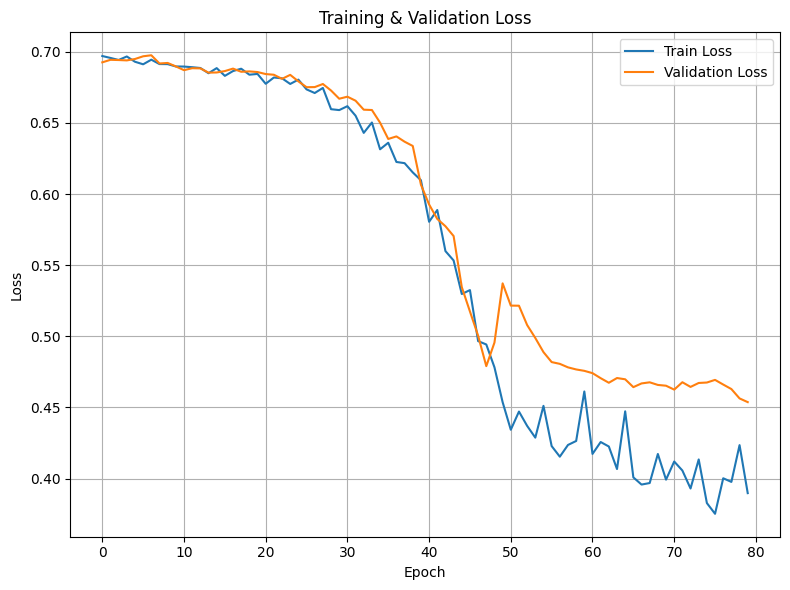


 Final Validation Metrics:
Accuracy : 0.8167
Precision: 0.8167
Recall   : 0.8167
F1 Score : 0.8167
AUC      : 0.8847
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:04<00:00, 39.62it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 46.94it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:37,  4.27s/epoch]

Epoch 1/80 | Train Loss: 0.6934 | Val Loss: 0.6966


Training Progress:   2%|▎         | 2/80 [00:08<05:53,  4.53s/epoch]

Epoch 2/80 | Train Loss: 0.6900 | Val Loss: 0.6954


Training Progress:   4%|▍         | 3/80 [00:13<05:44,  4.47s/epoch]

Epoch 3/80 | Train Loss: 0.6938 | Val Loss: 0.6932


Training Progress:   5%|▌         | 4/80 [00:17<05:31,  4.36s/epoch]

Epoch 4/80 | Train Loss: 0.6865 | Val Loss: 0.6958


Training Progress:   6%|▋         | 5/80 [00:22<05:36,  4.49s/epoch]

Epoch 5/80 | Train Loss: 0.6852 | Val Loss: 0.6932


Training Progress:   8%|▊         | 6/80 [00:26<05:31,  4.48s/epoch]

Epoch 6/80 | Train Loss: 0.6845 | Val Loss: 0.6903


Training Progress:   9%|▉         | 7/80 [00:31<05:23,  4.43s/epoch]

Epoch 7/80 | Train Loss: 0.6817 | Val Loss: 0.6903


Training Progress:  10%|█         | 8/80 [00:35<05:28,  4.57s/epoch]

Epoch 8/80 | Train Loss: 0.6747 | Val Loss: 0.6860


Training Progress:  11%|█▏        | 9/80 [00:40<05:19,  4.51s/epoch]

Epoch 9/80 | Train Loss: 0.6763 | Val Loss: 0.6820


Training Progress:  12%|█▎        | 10/80 [00:44<05:10,  4.44s/epoch]

Epoch 10/80 | Train Loss: 0.6723 | Val Loss: 0.6787


Training Progress:  14%|█▍        | 11/80 [00:49<05:16,  4.59s/epoch]

Epoch 11/80 | Train Loss: 0.6688 | Val Loss: 0.6780


Training Progress:  15%|█▌        | 12/80 [00:53<05:05,  4.50s/epoch]

Epoch 12/80 | Train Loss: 0.6679 | Val Loss: 0.6741


Training Progress:  16%|█▋        | 13/80 [00:58<04:55,  4.41s/epoch]

Epoch 13/80 | Train Loss: 0.6654 | Val Loss: 0.6640


Training Progress:  18%|█▊        | 14/80 [01:02<05:01,  4.56s/epoch]

Epoch 14/80 | Train Loss: 0.6619 | Val Loss: 0.6621


Training Progress:  19%|█▉        | 15/80 [01:07<04:48,  4.44s/epoch]

Epoch 15/80 | Train Loss: 0.6478 | Val Loss: 0.6604


Training Progress:  20%|██        | 16/80 [01:11<04:37,  4.34s/epoch]

Epoch 16/80 | Train Loss: 0.6470 | Val Loss: 0.6648


Training Progress:  21%|██▏       | 17/80 [01:16<04:43,  4.51s/epoch]

Epoch 17/80 | Train Loss: 0.6352 | Val Loss: 0.6574


Training Progress:  22%|██▎       | 18/80 [01:20<04:32,  4.40s/epoch]

Epoch 18/80 | Train Loss: 0.6303 | Val Loss: 0.6471


Training Progress:  24%|██▍       | 19/80 [01:24<04:24,  4.34s/epoch]

Epoch 19/80 | Train Loss: 0.6197 | Val Loss: 0.6362


Training Progress:  25%|██▌       | 20/80 [01:29<04:31,  4.52s/epoch]

Epoch 20/80 | Train Loss: 0.5977 | Val Loss: 0.6282


Training Progress:  26%|██▋       | 21/80 [01:33<04:20,  4.42s/epoch]

Epoch 21/80 | Train Loss: 0.5891 | Val Loss: 0.6148


Training Progress:  28%|██▊       | 22/80 [01:37<04:12,  4.35s/epoch]

Epoch 22/80 | Train Loss: 0.5766 | Val Loss: 0.6036


Training Progress:  29%|██▉       | 23/80 [01:42<04:17,  4.51s/epoch]

Epoch 23/80 | Train Loss: 0.5679 | Val Loss: 0.6126


Training Progress:  30%|███       | 24/80 [01:46<04:07,  4.41s/epoch]

Epoch 24/80 | Train Loss: 0.5381 | Val Loss: 0.5874


Training Progress:  31%|███▏      | 25/80 [01:51<03:59,  4.35s/epoch]

Epoch 25/80 | Train Loss: 0.5182 | Val Loss: 0.5538


Training Progress:  32%|███▎      | 26/80 [01:55<04:03,  4.50s/epoch]

Epoch 26/80 | Train Loss: 0.4986 | Val Loss: 0.5397


Training Progress:  34%|███▍      | 27/80 [02:00<03:54,  4.43s/epoch]

Epoch 27/80 | Train Loss: 0.5031 | Val Loss: 0.5177


Training Progress:  35%|███▌      | 28/80 [02:04<03:48,  4.40s/epoch]

Epoch 28/80 | Train Loss: 0.4569 | Val Loss: 0.5131


Training Progress:  36%|███▋      | 29/80 [02:09<03:51,  4.54s/epoch]

Epoch 29/80 | Train Loss: 0.4430 | Val Loss: 0.4962


Training Progress:  38%|███▊      | 30/80 [02:13<03:42,  4.45s/epoch]

Epoch 30/80 | Train Loss: 0.4334 | Val Loss: 0.4485


Training Progress:  39%|███▉      | 31/80 [02:17<03:33,  4.37s/epoch]

Epoch 31/80 | Train Loss: 0.3960 | Val Loss: 0.4205


Training Progress:  40%|████      | 32/80 [02:22<03:35,  4.48s/epoch]

Epoch 32/80 | Train Loss: 0.3658 | Val Loss: 0.4357


Training Progress:  41%|████▏     | 33/80 [02:26<03:26,  4.39s/epoch]

Epoch 33/80 | Train Loss: 0.3476 | Val Loss: 0.4218


Training Progress:  42%|████▎     | 34/80 [02:30<03:19,  4.33s/epoch]

Epoch 34/80 | Train Loss: 0.3486 | Val Loss: 0.4122


Training Progress:  44%|████▍     | 35/80 [02:35<03:20,  4.46s/epoch]

Epoch 35/80 | Train Loss: 0.3018 | Val Loss: 0.3837


Training Progress:  45%|████▌     | 36/80 [02:39<03:12,  4.38s/epoch]

Epoch 36/80 | Train Loss: 0.3155 | Val Loss: 0.3640


Training Progress:  46%|████▋     | 37/80 [02:43<03:05,  4.31s/epoch]

Epoch 37/80 | Train Loss: 0.2965 | Val Loss: 0.3387


Training Progress:  48%|████▊     | 38/80 [02:48<03:06,  4.45s/epoch]

Epoch 38/80 | Train Loss: 0.2684 | Val Loss: 0.3456


Training Progress:  49%|████▉     | 39/80 [02:52<02:59,  4.37s/epoch]

Epoch 39/80 | Train Loss: 0.2300 | Val Loss: 0.3454


Training Progress:  50%|█████     | 40/80 [02:57<02:52,  4.31s/epoch]

Epoch 40/80 | Train Loss: 0.2389 | Val Loss: 0.3504


Training Progress:  51%|█████▏    | 41/80 [03:01<02:53,  4.45s/epoch]

Epoch 41/80 | Train Loss: 0.2360 | Val Loss: 0.3327


Training Progress:  52%|█████▎    | 42/80 [03:06<02:46,  4.37s/epoch]

Epoch 42/80 | Train Loss: 0.2484 | Val Loss: 0.3491


Training Progress:  54%|█████▍    | 43/80 [03:10<02:39,  4.31s/epoch]

Epoch 43/80 | Train Loss: 0.2095 | Val Loss: 0.3209


Training Progress:  55%|█████▌    | 44/80 [03:15<02:40,  4.45s/epoch]

Epoch 44/80 | Train Loss: 0.2081 | Val Loss: 0.3154


Training Progress:  56%|█████▋    | 45/80 [03:19<02:32,  4.36s/epoch]

Epoch 45/80 | Train Loss: 0.1913 | Val Loss: 0.2973


Training Progress:  57%|█████▊    | 46/80 [03:23<02:26,  4.30s/epoch]

Epoch 46/80 | Train Loss: 0.1786 | Val Loss: 0.2814


Training Progress:  59%|█████▉    | 47/80 [03:28<02:26,  4.44s/epoch]

Epoch 47/80 | Train Loss: 0.2247 | Val Loss: 0.2941


Training Progress:  60%|██████    | 48/80 [03:32<02:19,  4.36s/epoch]

Epoch 48/80 | Train Loss: 0.1873 | Val Loss: 0.3164


Training Progress:  61%|██████▏   | 49/80 [03:36<02:13,  4.30s/epoch]

Epoch 49/80 | Train Loss: 0.1446 | Val Loss: 0.2575


Training Progress:  62%|██████▎   | 50/80 [03:41<02:13,  4.45s/epoch]

Epoch 50/80 | Train Loss: 0.1704 | Val Loss: 0.2240


Training Progress:  64%|██████▍   | 51/80 [03:45<02:06,  4.35s/epoch]

Epoch 51/80 | Train Loss: 0.1748 | Val Loss: 0.2298


Training Progress:  65%|██████▌   | 52/80 [03:49<01:59,  4.29s/epoch]

Epoch 52/80 | Train Loss: 0.1708 | Val Loss: 0.2430


Training Progress:  66%|██████▋   | 53/80 [03:54<02:00,  4.45s/epoch]

Epoch 53/80 | Train Loss: 0.1712 | Val Loss: 0.2538


Training Progress:  68%|██████▊   | 54/80 [03:58<01:53,  4.36s/epoch]

Epoch 54/80 | Train Loss: 0.1637 | Val Loss: 0.2676


Training Progress:  69%|██████▉   | 55/80 [04:02<01:47,  4.30s/epoch]

Epoch 55/80 | Train Loss: 0.1653 | Val Loss: 0.2525


Training Progress:  70%|███████   | 56/80 [04:07<01:47,  4.46s/epoch]

Epoch 56/80 | Train Loss: 0.1837 | Val Loss: 0.2490


Training Progress:  71%|███████▏  | 57/80 [04:11<01:40,  4.39s/epoch]

Epoch 57/80 | Train Loss: 0.1717 | Val Loss: 0.2510


Training Progress:  72%|███████▎  | 58/80 [04:15<01:35,  4.33s/epoch]

Epoch 58/80 | Train Loss: 0.2259 | Val Loss: 0.2382


Training Progress:  74%|███████▍  | 59/80 [04:20<01:34,  4.50s/epoch]

Epoch 59/80 | Train Loss: 0.1678 | Val Loss: 0.2423


Training Progress:  75%|███████▌  | 60/80 [04:24<01:28,  4.41s/epoch]

Epoch 60/80 | Train Loss: 0.1822 | Val Loss: 0.2487


Training Progress:  76%|███████▋  | 61/80 [04:29<01:22,  4.36s/epoch]

Epoch 61/80 | Train Loss: 0.1425 | Val Loss: 0.2503


Training Progress:  78%|███████▊  | 62/80 [04:34<01:20,  4.50s/epoch]

Epoch 62/80 | Train Loss: 0.1816 | Val Loss: 0.2445


Training Progress:  79%|███████▉  | 63/80 [04:38<01:14,  4.41s/epoch]

Epoch 63/80 | Train Loss: 0.1823 | Val Loss: 0.2453


Training Progress:  80%|████████  | 64/80 [04:42<01:09,  4.35s/epoch]

Epoch 64/80 | Train Loss: 0.1853 | Val Loss: 0.2447


Training Progress:  81%|████████▏ | 65/80 [04:47<01:07,  4.49s/epoch]

Epoch 65/80 | Train Loss: 0.2504 | Val Loss: 0.2440


Training Progress:  82%|████████▎ | 66/80 [04:51<01:01,  4.41s/epoch]

Epoch 66/80 | Train Loss: 0.1522 | Val Loss: 0.2420


Training Progress:  84%|████████▍ | 67/80 [04:55<00:56,  4.35s/epoch]

Epoch 67/80 | Train Loss: 0.1259 | Val Loss: 0.2479


Training Progress:  85%|████████▌ | 68/80 [05:00<00:53,  4.50s/epoch]

Epoch 68/80 | Train Loss: 0.1676 | Val Loss: 0.2357


Training Progress:  86%|████████▋ | 69/80 [05:04<00:48,  4.42s/epoch]

Epoch 69/80 | Train Loss: 0.1422 | Val Loss: 0.2394


Training Progress:  88%|████████▊ | 70/80 [05:08<00:43,  4.36s/epoch]

Epoch 70/80 | Train Loss: 0.1738 | Val Loss: 0.2387


Training Progress:  89%|████████▉ | 71/80 [05:13<00:40,  4.49s/epoch]

Epoch 71/80 | Train Loss: 0.1712 | Val Loss: 0.2410


Training Progress:  90%|█████████ | 72/80 [05:17<00:35,  4.40s/epoch]

Epoch 72/80 | Train Loss: 0.1599 | Val Loss: 0.2391


Training Progress:  91%|█████████▏| 73/80 [05:22<00:30,  4.33s/epoch]

Epoch 73/80 | Train Loss: 0.1691 | Val Loss: 0.2506


Training Progress:  92%|█████████▎| 74/80 [05:26<00:26,  4.45s/epoch]

Epoch 74/80 | Train Loss: 0.1341 | Val Loss: 0.2437


Training Progress:  94%|█████████▍| 75/80 [05:31<00:21,  4.37s/epoch]

Epoch 75/80 | Train Loss: 0.1682 | Val Loss: 0.2484


Training Progress:  95%|█████████▌| 76/80 [05:35<00:17,  4.31s/epoch]

Epoch 76/80 | Train Loss: 0.1665 | Val Loss: 0.2491


Training Progress:  96%|█████████▋| 77/80 [05:39<00:13,  4.44s/epoch]

Epoch 77/80 | Train Loss: 0.1680 | Val Loss: 0.2605


Training Progress:  98%|█████████▊| 78/80 [05:44<00:08,  4.35s/epoch]

Epoch 78/80 | Train Loss: 0.1641 | Val Loss: 0.2466


Training Progress:  99%|█████████▉| 79/80 [05:48<00:04,  4.28s/epoch]

Epoch 79/80 | Train Loss: 0.1853 | Val Loss: 0.2479


Training Progress: 100%|██████████| 80/80 [05:52<00:00,  4.41s/epoch]

Epoch 80/80 | Train Loss: 0.1674 | Val Loss: 0.2438


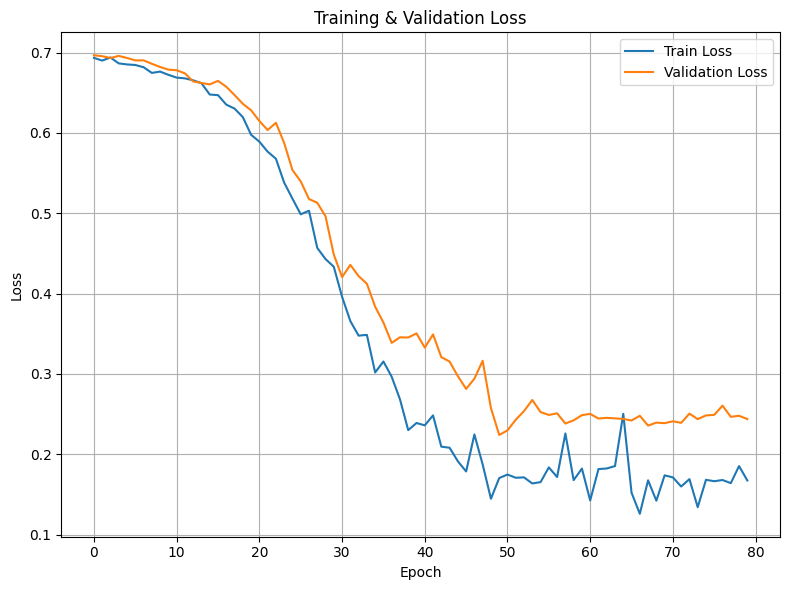


 Final Validation Metrics:
Accuracy : 0.9000
Precision: 0.9286
Recall   : 0.8667
F1 Score : 0.8966
AUC      : 0.9661
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 46.79it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:03<00:00, 36.99it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<05:37,  4.27s/epoch]

Epoch 1/80 | Train Loss: 0.6939 | Val Loss: 0.6945


Training Progress:   2%|▎         | 2/80 [00:08<05:27,  4.20s/epoch]

Epoch 2/80 | Train Loss: 0.6938 | Val Loss: 0.6957


Training Progress:   4%|▍         | 3/80 [00:13<05:45,  4.49s/epoch]

Epoch 3/80 | Train Loss: 0.6894 | Val Loss: 0.6965


Training Progress:   5%|▌         | 4/80 [00:17<05:37,  4.44s/epoch]

Epoch 4/80 | Train Loss: 0.6869 | Val Loss: 0.6971


Training Progress:   6%|▋         | 5/80 [00:21<05:26,  4.36s/epoch]

Epoch 5/80 | Train Loss: 0.6835 | Val Loss: 0.6955


Training Progress:   8%|▊         | 6/80 [00:26<05:35,  4.54s/epoch]

Epoch 6/80 | Train Loss: 0.6853 | Val Loss: 0.6916


Training Progress:   9%|▉         | 7/80 [00:30<05:25,  4.45s/epoch]

Epoch 7/80 | Train Loss: 0.6790 | Val Loss: 0.6883


Training Progress:  10%|█         | 8/80 [00:35<05:15,  4.38s/epoch]

Epoch 8/80 | Train Loss: 0.6814 | Val Loss: 0.6823


Training Progress:  11%|█▏        | 9/80 [00:40<05:23,  4.55s/epoch]

Epoch 9/80 | Train Loss: 0.6763 | Val Loss: 0.6807


Training Progress:  12%|█▎        | 10/80 [00:44<05:11,  4.44s/epoch]

Epoch 10/80 | Train Loss: 0.6676 | Val Loss: 0.6752


Training Progress:  14%|█▍        | 11/80 [00:48<05:01,  4.37s/epoch]

Epoch 11/80 | Train Loss: 0.6636 | Val Loss: 0.6719


Training Progress:  15%|█▌        | 12/80 [00:53<05:06,  4.51s/epoch]

Epoch 12/80 | Train Loss: 0.6605 | Val Loss: 0.6660


Training Progress:  16%|█▋        | 13/80 [00:57<04:55,  4.41s/epoch]

Epoch 13/80 | Train Loss: 0.6516 | Val Loss: 0.6617


Training Progress:  18%|█▊        | 14/80 [01:01<04:45,  4.32s/epoch]

Epoch 14/80 | Train Loss: 0.6429 | Val Loss: 0.6547


Training Progress:  19%|█▉        | 15/80 [01:06<04:50,  4.47s/epoch]

Epoch 15/80 | Train Loss: 0.6414 | Val Loss: 0.6529


Training Progress:  20%|██        | 16/80 [01:10<04:39,  4.37s/epoch]

Epoch 16/80 | Train Loss: 0.6333 | Val Loss: 0.6436


Training Progress:  21%|██▏       | 17/80 [01:14<04:30,  4.30s/epoch]

Epoch 17/80 | Train Loss: 0.6334 | Val Loss: 0.6354


Training Progress:  22%|██▎       | 18/80 [01:19<04:37,  4.47s/epoch]

Epoch 18/80 | Train Loss: 0.5984 | Val Loss: 0.6267


Training Progress:  24%|██▍       | 19/80 [01:23<04:27,  4.38s/epoch]

Epoch 19/80 | Train Loss: 0.5999 | Val Loss: 0.6122


Training Progress:  25%|██▌       | 20/80 [01:27<04:19,  4.32s/epoch]

Epoch 20/80 | Train Loss: 0.5783 | Val Loss: 0.6004


Training Progress:  26%|██▋       | 21/80 [01:32<04:24,  4.48s/epoch]

Epoch 21/80 | Train Loss: 0.5579 | Val Loss: 0.5731


Training Progress:  28%|██▊       | 22/80 [01:37<04:14,  4.39s/epoch]

Epoch 22/80 | Train Loss: 0.5219 | Val Loss: 0.5496


Training Progress:  29%|██▉       | 23/80 [01:41<04:06,  4.33s/epoch]

Epoch 23/80 | Train Loss: 0.4956 | Val Loss: 0.5281


Training Progress:  30%|███       | 24/80 [01:46<04:10,  4.48s/epoch]

Epoch 24/80 | Train Loss: 0.5003 | Val Loss: 0.5150


Training Progress:  31%|███▏      | 25/80 [01:50<04:02,  4.40s/epoch]

Epoch 25/80 | Train Loss: 0.4541 | Val Loss: 0.4769


Training Progress:  32%|███▎      | 26/80 [01:54<03:54,  4.35s/epoch]

Epoch 26/80 | Train Loss: 0.4215 | Val Loss: 0.4303


Training Progress:  34%|███▍      | 27/80 [01:59<03:58,  4.50s/epoch]

Epoch 27/80 | Train Loss: 0.3607 | Val Loss: 0.3776


Training Progress:  35%|███▌      | 28/80 [02:03<03:48,  4.40s/epoch]

Epoch 28/80 | Train Loss: 0.3500 | Val Loss: 0.3816


Training Progress:  36%|███▋      | 29/80 [02:07<03:40,  4.33s/epoch]

Epoch 29/80 | Train Loss: 0.3004 | Val Loss: 0.3705


Training Progress:  38%|███▊      | 30/80 [02:12<03:43,  4.47s/epoch]

Epoch 30/80 | Train Loss: 0.2936 | Val Loss: 0.3212


Training Progress:  39%|███▉      | 31/80 [02:16<03:34,  4.37s/epoch]

Epoch 31/80 | Train Loss: 0.2665 | Val Loss: 0.3565


Training Progress:  40%|████      | 32/80 [02:20<03:26,  4.31s/epoch]

Epoch 32/80 | Train Loss: 0.2443 | Val Loss: 0.2409


Training Progress:  41%|████▏     | 33/80 [02:25<03:30,  4.47s/epoch]

Epoch 33/80 | Train Loss: 0.1931 | Val Loss: 0.2357


Training Progress:  42%|████▎     | 34/80 [02:29<03:22,  4.41s/epoch]

Epoch 34/80 | Train Loss: 0.1507 | Val Loss: 0.2290


Training Progress:  44%|████▍     | 35/80 [02:34<03:15,  4.34s/epoch]

Epoch 35/80 | Train Loss: 0.1689 | Val Loss: 0.2043


Training Progress:  45%|████▌     | 36/80 [02:38<03:17,  4.48s/epoch]

Epoch 36/80 | Train Loss: 0.1509 | Val Loss: 0.1857


Training Progress:  46%|████▋     | 37/80 [02:43<03:08,  4.39s/epoch]

Epoch 37/80 | Train Loss: 0.1648 | Val Loss: 0.1994


Training Progress:  48%|████▊     | 38/80 [02:47<03:01,  4.33s/epoch]

Epoch 38/80 | Train Loss: 0.1925 | Val Loss: 0.2049


Training Progress:  49%|████▉     | 39/80 [02:52<03:03,  4.47s/epoch]

Epoch 39/80 | Train Loss: 0.1424 | Val Loss: 0.1740


Training Progress:  50%|█████     | 40/80 [02:56<02:55,  4.38s/epoch]

Epoch 40/80 | Train Loss: 0.1395 | Val Loss: 0.2722


Training Progress:  51%|█████▏    | 41/80 [03:00<02:48,  4.33s/epoch]

Epoch 41/80 | Train Loss: 0.1529 | Val Loss: 0.1424


Training Progress:  52%|█████▎    | 42/80 [03:05<02:49,  4.47s/epoch]

Epoch 42/80 | Train Loss: 0.1041 | Val Loss: 0.1498


Training Progress:  54%|█████▍    | 43/80 [03:09<02:42,  4.38s/epoch]

Epoch 43/80 | Train Loss: 0.1139 | Val Loss: 0.1556


Training Progress:  55%|█████▌    | 44/80 [03:13<02:35,  4.32s/epoch]

Epoch 44/80 | Train Loss: 0.1122 | Val Loss: 0.1583


Training Progress:  56%|█████▋    | 45/80 [03:18<02:36,  4.46s/epoch]

Epoch 45/80 | Train Loss: 0.1189 | Val Loss: 0.1896


Training Progress:  57%|█████▊    | 46/80 [03:22<02:28,  4.38s/epoch]

Epoch 46/80 | Train Loss: 0.1769 | Val Loss: 0.1496


Training Progress:  59%|█████▉    | 47/80 [03:26<02:23,  4.34s/epoch]

Epoch 47/80 | Train Loss: 0.1205 | Val Loss: 0.2448


Training Progress:  60%|██████    | 48/80 [03:31<02:23,  4.48s/epoch]

Epoch 48/80 | Train Loss: 0.1049 | Val Loss: 0.2621


Training Progress:  61%|██████▏   | 49/80 [03:35<02:16,  4.40s/epoch]

Epoch 49/80 | Train Loss: 0.1131 | Val Loss: 0.1303


Training Progress:  62%|██████▎   | 50/80 [03:39<02:09,  4.33s/epoch]

Epoch 50/80 | Train Loss: 0.0811 | Val Loss: 0.1245


Training Progress:  64%|██████▍   | 51/80 [03:44<02:09,  4.47s/epoch]

Epoch 51/80 | Train Loss: 0.0756 | Val Loss: 0.1185


Training Progress:  65%|██████▌   | 52/80 [03:48<02:02,  4.39s/epoch]

Epoch 52/80 | Train Loss: 0.0529 | Val Loss: 0.1162


Training Progress:  66%|██████▋   | 53/80 [03:53<01:56,  4.32s/epoch]

Epoch 53/80 | Train Loss: 0.0852 | Val Loss: 0.1184


Training Progress:  68%|██████▊   | 54/80 [03:57<01:56,  4.47s/epoch]

Epoch 54/80 | Train Loss: 0.0568 | Val Loss: 0.1126


Training Progress:  69%|██████▉   | 55/80 [04:02<01:49,  4.38s/epoch]

Epoch 55/80 | Train Loss: 0.0909 | Val Loss: 0.1113


Training Progress:  70%|███████   | 56/80 [04:06<01:43,  4.31s/epoch]

Epoch 56/80 | Train Loss: 0.0711 | Val Loss: 0.1075


Training Progress:  71%|███████▏  | 57/80 [04:11<01:42,  4.45s/epoch]

Epoch 57/80 | Train Loss: 0.0681 | Val Loss: 0.1056


Training Progress:  72%|███████▎  | 58/80 [04:15<01:35,  4.36s/epoch]

Epoch 58/80 | Train Loss: 0.0689 | Val Loss: 0.1076


Training Progress:  74%|███████▍  | 59/80 [04:19<01:30,  4.30s/epoch]

Epoch 59/80 | Train Loss: 0.0950 | Val Loss: 0.1070


Training Progress:  75%|███████▌  | 60/80 [04:24<01:28,  4.44s/epoch]

Epoch 60/80 | Train Loss: 0.0773 | Val Loss: 0.1104


Training Progress:  76%|███████▋  | 61/80 [04:28<01:22,  4.36s/epoch]

Epoch 61/80 | Train Loss: 0.0659 | Val Loss: 0.1095


Training Progress:  78%|███████▊  | 62/80 [04:32<01:17,  4.31s/epoch]

Epoch 62/80 | Train Loss: 0.0645 | Val Loss: 0.1132


Training Progress:  79%|███████▉  | 63/80 [04:37<01:15,  4.45s/epoch]

Epoch 63/80 | Train Loss: 0.0746 | Val Loss: 0.1118


Training Progress:  80%|████████  | 64/80 [04:41<01:09,  4.37s/epoch]

Epoch 64/80 | Train Loss: 0.0734 | Val Loss: 0.1105


Training Progress:  81%|████████▏ | 65/80 [04:45<01:04,  4.31s/epoch]

Epoch 65/80 | Train Loss: 0.0488 | Val Loss: 0.1094


Training Progress:  82%|████████▎ | 66/80 [04:50<01:02,  4.45s/epoch]

Epoch 66/80 | Train Loss: 0.0844 | Val Loss: 0.1123


Training Progress:  84%|████████▍ | 67/80 [04:54<00:56,  4.37s/epoch]

Epoch 67/80 | Train Loss: 0.0664 | Val Loss: 0.1121


Training Progress:  85%|████████▌ | 68/80 [04:58<00:51,  4.32s/epoch]

Epoch 68/80 | Train Loss: 0.1300 | Val Loss: 0.1129


Training Progress:  86%|████████▋ | 69/80 [05:03<00:48,  4.45s/epoch]

Epoch 69/80 | Train Loss: 0.0808 | Val Loss: 0.1106


Training Progress:  88%|████████▊ | 70/80 [05:07<00:43,  4.36s/epoch]

Epoch 70/80 | Train Loss: 0.0740 | Val Loss: 0.1111


Training Progress:  89%|████████▉ | 71/80 [05:11<00:38,  4.30s/epoch]

Epoch 71/80 | Train Loss: 0.1012 | Val Loss: 0.1127


Training Progress:  90%|█████████ | 72/80 [05:16<00:35,  4.44s/epoch]

Epoch 72/80 | Train Loss: 0.0657 | Val Loss: 0.1146


Training Progress:  91%|█████████▏| 73/80 [05:20<00:30,  4.38s/epoch]

Epoch 73/80 | Train Loss: 0.0587 | Val Loss: 0.1179


Training Progress:  92%|█████████▎| 74/80 [05:24<00:25,  4.31s/epoch]

Epoch 74/80 | Train Loss: 0.0568 | Val Loss: 0.1145


Training Progress:  94%|█████████▍| 75/80 [05:29<00:22,  4.46s/epoch]

Epoch 75/80 | Train Loss: 0.0723 | Val Loss: 0.1166


Training Progress:  95%|█████████▌| 76/80 [05:33<00:17,  4.37s/epoch]

Epoch 76/80 | Train Loss: 0.0780 | Val Loss: 0.1211


Training Progress:  96%|█████████▋| 77/80 [05:38<00:12,  4.31s/epoch]

Epoch 77/80 | Train Loss: 0.0532 | Val Loss: 0.1179


Training Progress:  98%|█████████▊| 78/80 [05:42<00:08,  4.46s/epoch]

Epoch 78/80 | Train Loss: 0.0780 | Val Loss: 0.1138


Training Progress:  99%|█████████▉| 79/80 [05:47<00:04,  4.38s/epoch]

Epoch 79/80 | Train Loss: 0.0615 | Val Loss: 0.1119


Training Progress: 100%|██████████| 80/80 [05:51<00:00,  4.39s/epoch]

Epoch 80/80 | Train Loss: 0.0447 | Val Loss: 0.1095


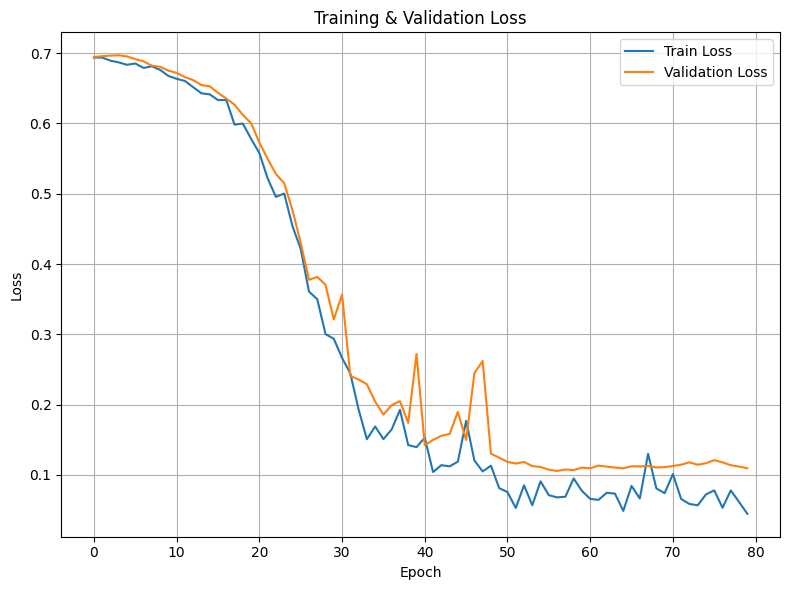


 Final Validation Metrics:
Accuracy : 0.9667
Precision: 0.9375
Recall   : 1.0000
F1 Score : 0.9677
AUC      : 0.9925
Processing train: X_train.npy, y_train.npy


100%|██████████| 180/180 [00:03<00:00, 45.92it/s]


Processing val: X_test.npy, y_test.npy


100%|██████████| 120/120 [00:02<00:00, 46.11it/s]


All images saved in 'dataset/' folder structure.
180 120


Training Progress:   1%|▏         | 1/80 [00:04<06:20,  4.82s/epoch]

Epoch 1/80 | Train Loss: 0.6898 | Val Loss: 0.6911


Training Progress:   2%|▎         | 2/80 [00:09<05:48,  4.46s/epoch]

Epoch 2/80 | Train Loss: 0.6892 | Val Loss: 0.6917


Training Progress:   4%|▍         | 3/80 [00:13<05:33,  4.34s/epoch]

Epoch 3/80 | Train Loss: 0.6835 | Val Loss: 0.6906


Training Progress:   5%|▌         | 4/80 [00:18<05:46,  4.56s/epoch]

Epoch 4/80 | Train Loss: 0.6835 | Val Loss: 0.6916


Training Progress:   6%|▋         | 5/80 [00:22<05:33,  4.44s/epoch]

Epoch 5/80 | Train Loss: 0.6869 | Val Loss: 0.6914


Training Progress:   8%|▊         | 6/80 [00:26<05:23,  4.37s/epoch]

Epoch 6/80 | Train Loss: 0.6743 | Val Loss: 0.6890


Training Progress:   9%|▉         | 7/80 [00:31<05:31,  4.55s/epoch]

Epoch 7/80 | Train Loss: 0.6734 | Val Loss: 0.6855


Training Progress:  10%|█         | 8/80 [00:35<05:19,  4.44s/epoch]

Epoch 8/80 | Train Loss: 0.6694 | Val Loss: 0.6807


Training Progress:  11%|█▏        | 9/80 [00:39<05:10,  4.38s/epoch]

Epoch 9/80 | Train Loss: 0.6616 | Val Loss: 0.6671


Training Progress:  12%|█▎        | 10/80 [00:44<05:17,  4.53s/epoch]

Epoch 10/80 | Train Loss: 0.6461 | Val Loss: 0.6559


Training Progress:  14%|█▍        | 11/80 [00:48<05:05,  4.42s/epoch]

Epoch 11/80 | Train Loss: 0.6436 | Val Loss: 0.6442


Training Progress:  15%|█▌        | 12/80 [00:53<04:55,  4.34s/epoch]

Epoch 12/80 | Train Loss: 0.6370 | Val Loss: 0.6286


Training Progress:  16%|█▋        | 13/80 [00:58<05:01,  4.50s/epoch]

Epoch 13/80 | Train Loss: 0.6207 | Val Loss: 0.6127


Training Progress:  18%|█▊        | 14/80 [01:02<04:50,  4.40s/epoch]

Epoch 14/80 | Train Loss: 0.5972 | Val Loss: 0.5994


Training Progress:  19%|█▉        | 15/80 [01:06<04:40,  4.32s/epoch]

Epoch 15/80 | Train Loss: 0.5859 | Val Loss: 0.5788


Training Progress:  20%|██        | 16/80 [01:11<04:45,  4.47s/epoch]

Epoch 16/80 | Train Loss: 0.5524 | Val Loss: 0.5415


Training Progress:  21%|██▏       | 17/80 [01:15<04:34,  4.36s/epoch]

Epoch 17/80 | Train Loss: 0.5346 | Val Loss: 0.5015


Training Progress:  22%|██▎       | 18/80 [01:19<04:26,  4.29s/epoch]

Epoch 18/80 | Train Loss: 0.4808 | Val Loss: 0.4620


Training Progress:  24%|██▍       | 19/80 [01:24<04:31,  4.45s/epoch]

Epoch 19/80 | Train Loss: 0.4502 | Val Loss: 0.4291


Training Progress:  25%|██▌       | 20/80 [01:28<04:22,  4.37s/epoch]

Epoch 20/80 | Train Loss: 0.3894 | Val Loss: 0.3710


Training Progress:  26%|██▋       | 21/80 [01:32<04:15,  4.32s/epoch]

Epoch 21/80 | Train Loss: 0.3407 | Val Loss: 0.3300


Training Progress:  28%|██▊       | 22/80 [01:37<04:19,  4.48s/epoch]

Epoch 22/80 | Train Loss: 0.3232 | Val Loss: 0.2843


Training Progress:  29%|██▉       | 23/80 [01:41<04:10,  4.39s/epoch]

Epoch 23/80 | Train Loss: 0.2837 | Val Loss: 0.2584


Training Progress:  30%|███       | 24/80 [01:45<04:02,  4.33s/epoch]

Epoch 24/80 | Train Loss: 0.2585 | Val Loss: 0.2511


Training Progress:  31%|███▏      | 25/80 [01:50<04:06,  4.47s/epoch]

Epoch 25/80 | Train Loss: 0.2267 | Val Loss: 0.2121


Training Progress:  32%|███▎      | 26/80 [01:54<03:57,  4.39s/epoch]

Epoch 26/80 | Train Loss: 0.2198 | Val Loss: 0.1805


Training Progress:  34%|███▍      | 27/80 [01:59<03:49,  4.33s/epoch]

Epoch 27/80 | Train Loss: 0.2000 | Val Loss: 0.1525


Training Progress:  35%|███▌      | 28/80 [02:03<03:52,  4.47s/epoch]

Epoch 28/80 | Train Loss: 0.2105 | Val Loss: 0.1318


Training Progress:  36%|███▋      | 29/80 [02:07<03:43,  4.38s/epoch]

Epoch 29/80 | Train Loss: 0.1563 | Val Loss: 0.1265


Training Progress:  38%|███▊      | 30/80 [02:12<03:35,  4.32s/epoch]

Epoch 30/80 | Train Loss: 0.1505 | Val Loss: 0.1309


Training Progress:  39%|███▉      | 31/80 [02:17<03:39,  4.48s/epoch]

Epoch 31/80 | Train Loss: 0.1254 | Val Loss: 0.1320


Training Progress:  40%|████      | 32/80 [02:21<03:30,  4.39s/epoch]

Epoch 32/80 | Train Loss: 0.1279 | Val Loss: 0.1590


Training Progress:  41%|████▏     | 33/80 [02:25<03:23,  4.32s/epoch]

Epoch 33/80 | Train Loss: 0.1471 | Val Loss: 0.1289


Training Progress:  42%|████▎     | 34/80 [02:30<03:25,  4.48s/epoch]

Epoch 34/80 | Train Loss: 0.1037 | Val Loss: 0.0965


Training Progress:  44%|████▍     | 35/80 [02:34<03:17,  4.38s/epoch]

Epoch 35/80 | Train Loss: 0.1112 | Val Loss: 0.1032


Training Progress:  45%|████▌     | 36/80 [02:38<03:09,  4.31s/epoch]

Epoch 36/80 | Train Loss: 0.0873 | Val Loss: 0.1025


Training Progress:  46%|████▋     | 37/80 [02:43<03:12,  4.47s/epoch]

Epoch 37/80 | Train Loss: 0.1111 | Val Loss: 0.0920


Training Progress:  48%|████▊     | 38/80 [02:47<03:03,  4.37s/epoch]

Epoch 38/80 | Train Loss: 0.0855 | Val Loss: 0.0898


Training Progress:  49%|████▉     | 39/80 [02:51<02:56,  4.31s/epoch]

Epoch 39/80 | Train Loss: 0.1087 | Val Loss: 0.0865


Training Progress:  50%|█████     | 40/80 [02:56<02:58,  4.47s/epoch]

Epoch 40/80 | Train Loss: 0.0756 | Val Loss: 0.0914


Training Progress:  51%|█████▏    | 41/80 [03:00<02:51,  4.39s/epoch]

Epoch 41/80 | Train Loss: 0.1108 | Val Loss: 0.1458


Training Progress:  52%|█████▎    | 42/80 [03:04<02:44,  4.33s/epoch]

Epoch 42/80 | Train Loss: 0.0809 | Val Loss: 0.0798


Training Progress:  54%|█████▍    | 43/80 [03:09<02:45,  4.48s/epoch]

Epoch 43/80 | Train Loss: 0.1704 | Val Loss: 0.0656


Training Progress:  55%|█████▌    | 44/80 [03:13<02:37,  4.39s/epoch]

Epoch 44/80 | Train Loss: 0.0702 | Val Loss: 0.0659


Training Progress:  56%|█████▋    | 45/80 [03:18<02:31,  4.32s/epoch]

Epoch 45/80 | Train Loss: 0.0889 | Val Loss: 0.0591


Training Progress:  57%|█████▊    | 46/80 [03:22<02:31,  4.47s/epoch]

Epoch 46/80 | Train Loss: 0.0867 | Val Loss: 0.0765


Training Progress:  59%|█████▉    | 47/80 [03:27<02:24,  4.37s/epoch]

Epoch 47/80 | Train Loss: 0.0648 | Val Loss: 0.0530


Training Progress:  60%|██████    | 48/80 [03:31<02:17,  4.31s/epoch]

Epoch 48/80 | Train Loss: 0.0946 | Val Loss: 0.0483


Training Progress:  61%|██████▏   | 49/80 [03:35<02:17,  4.45s/epoch]

Epoch 49/80 | Train Loss: 0.0516 | Val Loss: 0.0513


Training Progress:  62%|██████▎   | 50/80 [03:40<02:10,  4.36s/epoch]

Epoch 50/80 | Train Loss: 0.0674 | Val Loss: 0.0558


Training Progress:  64%|██████▍   | 51/80 [03:44<02:04,  4.30s/epoch]

Epoch 51/80 | Train Loss: 0.0848 | Val Loss: 0.0617


Training Progress:  65%|██████▌   | 52/80 [03:49<02:04,  4.45s/epoch]

Epoch 52/80 | Train Loss: 0.0516 | Val Loss: 0.0585


Training Progress:  66%|██████▋   | 53/80 [03:53<01:58,  4.37s/epoch]

Epoch 53/80 | Train Loss: 0.0496 | Val Loss: 0.0561


Training Progress:  68%|██████▊   | 54/80 [03:57<01:52,  4.32s/epoch]

Epoch 54/80 | Train Loss: 0.0503 | Val Loss: 0.0552


Training Progress:  69%|██████▉   | 55/80 [04:02<01:51,  4.46s/epoch]

Epoch 55/80 | Train Loss: 0.0483 | Val Loss: 0.0543


Training Progress:  70%|███████   | 56/80 [04:06<01:44,  4.37s/epoch]

Epoch 56/80 | Train Loss: 0.0601 | Val Loss: 0.0523


Training Progress:  71%|███████▏  | 57/80 [04:10<01:39,  4.31s/epoch]

Epoch 57/80 | Train Loss: 0.0390 | Val Loss: 0.0575


Training Progress:  72%|███████▎  | 58/80 [04:15<01:38,  4.46s/epoch]

Epoch 58/80 | Train Loss: 0.0529 | Val Loss: 0.0538


Training Progress:  74%|███████▍  | 59/80 [04:19<01:31,  4.37s/epoch]

Epoch 59/80 | Train Loss: 0.0512 | Val Loss: 0.0563


Training Progress:  75%|███████▌  | 60/80 [04:23<01:26,  4.30s/epoch]

Epoch 60/80 | Train Loss: 0.0568 | Val Loss: 0.0526


Training Progress:  76%|███████▋  | 61/80 [04:28<01:24,  4.46s/epoch]

Epoch 61/80 | Train Loss: 0.0474 | Val Loss: 0.0541


Training Progress:  78%|███████▊  | 62/80 [04:32<01:18,  4.37s/epoch]

Epoch 62/80 | Train Loss: 0.0351 | Val Loss: 0.0549


Training Progress:  79%|███████▉  | 63/80 [04:36<01:13,  4.31s/epoch]

Epoch 63/80 | Train Loss: 0.0504 | Val Loss: 0.0531


Training Progress:  80%|████████  | 64/80 [04:41<01:11,  4.46s/epoch]

Epoch 64/80 | Train Loss: 0.0557 | Val Loss: 0.0530


Training Progress:  81%|████████▏ | 65/80 [04:45<01:05,  4.38s/epoch]

Epoch 65/80 | Train Loss: 0.0515 | Val Loss: 0.0541


Training Progress:  82%|████████▎ | 66/80 [04:50<01:00,  4.32s/epoch]

Epoch 66/80 | Train Loss: 0.0615 | Val Loss: 0.0510


Training Progress:  84%|████████▍ | 67/80 [04:54<00:57,  4.46s/epoch]

Epoch 67/80 | Train Loss: 0.0787 | Val Loss: 0.0523


Training Progress:  85%|████████▌ | 68/80 [04:58<00:52,  4.38s/epoch]

Epoch 68/80 | Train Loss: 0.0560 | Val Loss: 0.0530


Training Progress:  86%|████████▋ | 69/80 [05:03<00:47,  4.31s/epoch]

Epoch 69/80 | Train Loss: 0.1071 | Val Loss: 0.0568


Training Progress:  88%|████████▊ | 70/80 [05:07<00:44,  4.45s/epoch]

Epoch 70/80 | Train Loss: 0.1070 | Val Loss: 0.0498


Training Progress:  89%|████████▉ | 71/80 [05:12<00:39,  4.36s/epoch]

Epoch 71/80 | Train Loss: 0.0494 | Val Loss: 0.0483


Training Progress:  90%|█████████ | 72/80 [05:16<00:34,  4.30s/epoch]

Epoch 72/80 | Train Loss: 0.0496 | Val Loss: 0.0486


Training Progress:  91%|█████████▏| 73/80 [05:20<00:31,  4.44s/epoch]

Epoch 73/80 | Train Loss: 0.0345 | Val Loss: 0.0515


Training Progress:  92%|█████████▎| 74/80 [05:25<00:26,  4.35s/epoch]

Epoch 74/80 | Train Loss: 0.0403 | Val Loss: 0.0526


Training Progress:  94%|█████████▍| 75/80 [05:29<00:21,  4.28s/epoch]

Epoch 75/80 | Train Loss: 0.0531 | Val Loss: 0.0493


Training Progress:  95%|█████████▌| 76/80 [05:33<00:17,  4.42s/epoch]

Epoch 76/80 | Train Loss: 0.0717 | Val Loss: 0.0498


Training Progress:  96%|█████████▋| 77/80 [05:38<00:12,  4.33s/epoch]

Epoch 77/80 | Train Loss: 0.0533 | Val Loss: 0.0477


Training Progress:  98%|█████████▊| 78/80 [05:42<00:08,  4.26s/epoch]

Epoch 78/80 | Train Loss: 0.0638 | Val Loss: 0.0473


Training Progress:  99%|█████████▉| 79/80 [05:46<00:04,  4.41s/epoch]

Epoch 79/80 | Train Loss: 0.0539 | Val Loss: 0.0505


Training Progress: 100%|██████████| 80/80 [05:51<00:00,  4.39s/epoch]

Epoch 80/80 | Train Loss: 0.0900 | Val Loss: 0.0476


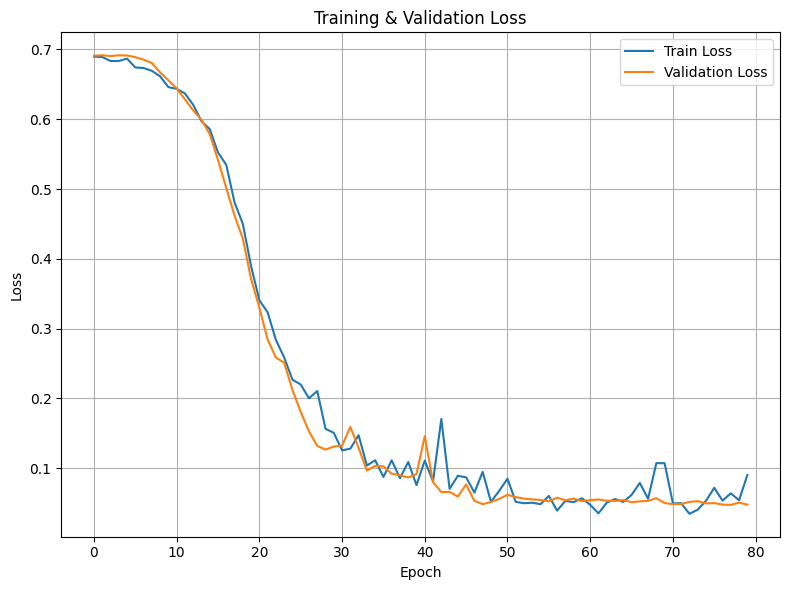


 Final Validation Metrics:
Accuracy : 0.9833
Precision: 0.9677
Recall   : 1.0000
F1 Score : 0.9836
AUC      : 1.0000


In [19]:
architecture = "resnet50"
results[architecture] = {}
names = ["E60-50", "E60-40", "E70-40", "E80-50", "E70-30", "E80-20", "E90-10", "E100-0"]

for name in names:
    datadir ="/content/drive/MyDrive/Datasets_BHT_summary/DATA/" + name

    results[architecture][name] = train_and_validate(datadir, architecture)

In [26]:
import pandas as pd

# Create table: {method: {dataset: accuracy}}
table_data = {}

for arch in results:
    for dataset in results[arch]:
        acc = 100 * results[arch][dataset]["accuracy"]
        if arch not in table_data:
            table_data[arch] = {}
        table_data[arch][dataset] = f"{acc:.2f}"

# Convert to DataFrame
df = pd.DataFrame.from_dict(table_data, orient="index")

df

,E60-50,E60-40,E70-40,E80-50,E70-30,E80-20,E90-10,E100-0
resnet50,50.00,53.33,55.00,70.83,81.67,90.00,96.67,98.33
resnet18,53.33,48.33,60.83,59.17,75.00,87.50,91.67,99.17
